In [1]:
from astropy.io import fits
import numpy as np
from astropy.table import QTable,vstack
import astropy.units as u
import astropy.utils
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import matplotlib.colors
from scipy.stats import chisquare
from scipy.stats import chi2
from scipy.stats import lognorm
from astropy.timeseries import LombScargle
import time
from astropy.visualization import hist
from scipy.optimize import curve_fit
from astropy.timeseries import BoxLeastSquares
from astropy.timeseries import TimeSeries
from astropy.time import Time
from tqdm import tqdm


import functions
#import upsilon

In [2]:
functions.query(90)

SourceID,filter,OID,RA,DEC,numobs,DELTA_SIG_MAG,CONST_CHI2,sf,rmse,LNP_SIG,period,period_c,power,power_c,mean,std,min,max,sigma_mean,sigma_std,upsilon_class,upsilon_prob,upsilon_flag,upsilon_period
int32,str2,str16,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str14,float64,float64,float64
90,zr,1809211300042387,5.083505,59.3114538,76,335.14105224609375,55.45322806162426,0.0,0.2555650770664215,2.0784866526889912e-39,2800.0,2800.0,0.9309604412577608,0.9992448196539399,18.229490280151367,0.2555650770664215,17.943700790405273,18.82109832763672,-1.287727952003479,7.673773765563965,LPV_Mira_AGB_C,0.31,0.0,1328.6934374999983
90,zr,806203100056957,5.0836327,59.3114535,846,567.4482421875,120.79296419281002,0.0,0.3739984333515167,3.247011689208663e-280,2043.207284960579,0.997336033066433,0.9506730073393318,0.47493011002121566,18.124500274658203,0.3739984333515167,17.195171356201172,18.949966430664062,-2.5609970092773438,11.737095832824707,LPV_Mira_AGB_C,0.26,0.0,2267.852326350003


SourceID,filter,OID,RA,DEC,numobs,DELTA_SIG_MAG,CONST_CHI2,sf,rmse,LNP_SIG,period,period_c,power,power_c,mean,std,min,max,sigma_mean,sigma_std,upsilon_class,upsilon_prob,upsilon_flag,upsilon_period
int32,str2,str16,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str14,float64,float64,float64
90,zg,806103100049624,5.0834336,59.3114529,324,188.7042694091797,29.36702577363452,0.0,0.29480019211769104,3.044761670180407e-168,2043.2292424728973,1.0000143393856216,0.9125489407249586,0.43350509622734634,18.898109436035156,0.29480019211769104,18.297286987304688,19.611181259155273,-1.0131325721740723,5.650538921356201,LPV_OSARG_AGB,0.31,0.0,1511.9616666
90,zg,1809111300037244,5.0836547,59.3114469,61,105.74268341064453,13.15463191096567,9.710163884275544e-51,0.2332914173603058,8.208515448671929e-24,2800.0,2800.0,0.8775419792009624,0.9992463068810069,18.989334106445312,0.2332914173603058,18.65045166015625,19.512157440185547,-0.5934993624687195,3.7146499156951904,LPV_Mira_AGB_C,0.29,0.0,1400.243784899998


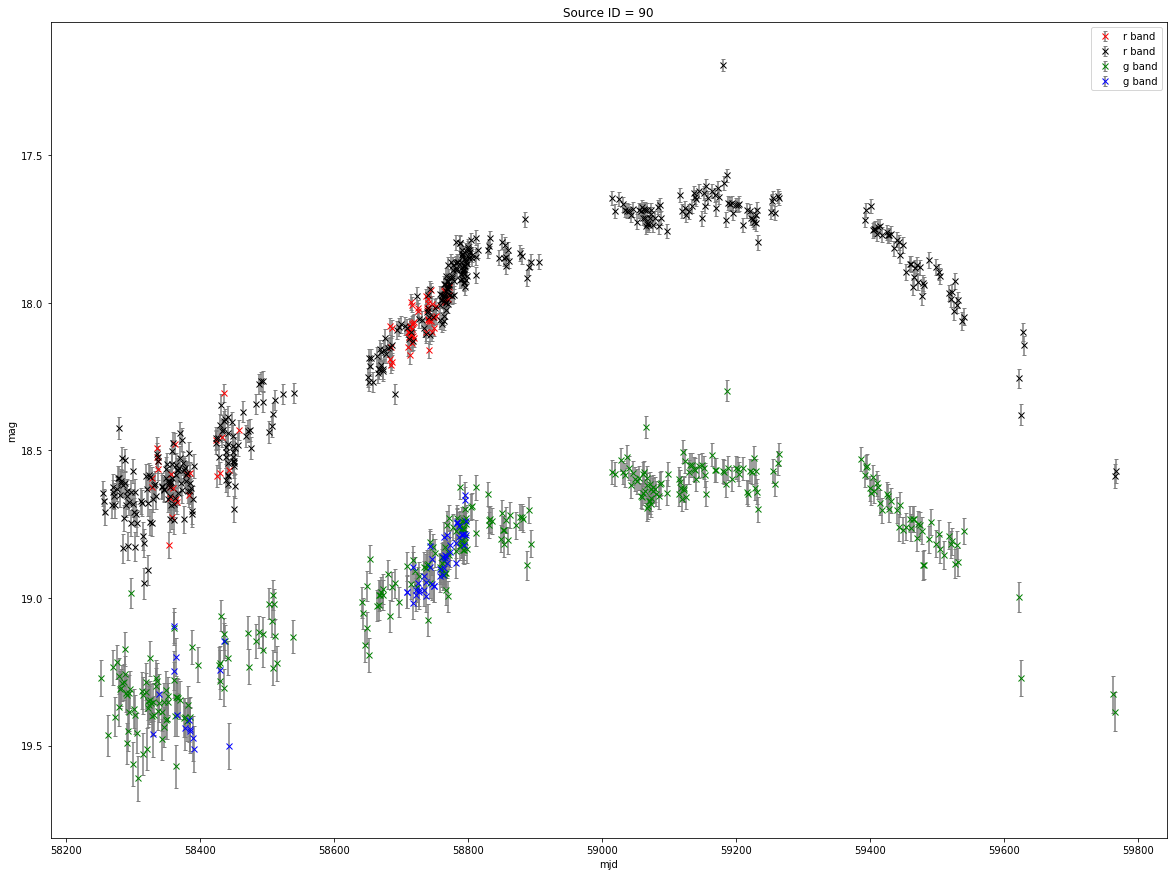

In [3]:
functions.draw_lightcurve(90)

In [4]:
ztf_ID=806203100056957
t=QTable.read('https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?ID='+str(ztf_ID))
#remove bad flags
t=t[t['catflags']==0]
# remove bad days
t=t[(t['mjd']<58481*u.day)|(t['mjd']>58482*u.day)]
t=t[(t['mjd']<58472*u.day)|(t['mjd']>58474*u.day)]
t=t[(t['mjd']<59032*u.day)|(t['mjd']>59033*u.day)]

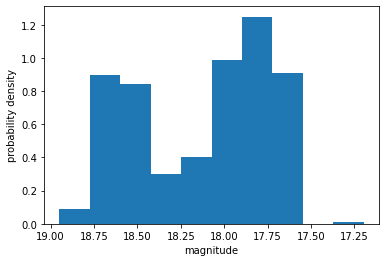

In [5]:
mag=np.array(t['mag'])
histo=plt.hist(mag,bins=10,density=1)
plt.xlabel('magnitude')
plt.ylabel('probability density')
plt.gca().invert_xaxis()

In [6]:
histo

(array([0.01301064, 0.        , 0.91075444, 1.24902109, 0.98880836,
        0.40332973, 0.29924464, 0.84570056, 0.89773391, 0.09107445]),
 array([17.195171, 17.370651, 17.546131, 17.72161 , 17.897089, 18.072569,
        18.248049, 18.423529, 18.599007, 18.774487, 18.949966],
       dtype=float32),
 <BarContainer object of 10 artists>)

In [7]:
x=(histo[1][:-1]+histo[1][1:])/2
y=histo[0]

In [8]:
# 1 peak gaussian
def gaussian1(x,c,mu,sigma):
    return c*np.exp(-(x-mu)**2/(2*sigma**2))

popt_g1,pcov_g1 = curve_fit(gaussian1,x,y,p0=[1,x.mean(),x.std()])

In [9]:
popt_g1

array([ 0.86339237, 18.07271184,  0.51547203])

In [10]:
# 2 peak gaussian
def gaussian2(x,c1,mu1,sigma1,c2,mu2,sigma2):
    return c1 * np.exp(-(x-mu1)**2/(2*sigma1**2))+c2*np.exp(-(x-mu2)**2/(2*sigma2**2))

popt_g2,pcov_g2 = curve_fit(gaussian2,x,y,p0=[1,x.mean(),x.std(),1,x.mean(),x.std()])

In [11]:
# 1 peak lorentzian
def lorentzian(x,c,cen,wid):
    return c*wid**2/((x-cen)**2+wid**2)

popt_l,pcov_l = curve_fit(lorentzian,x,y,p0=[1,x.mean(),x.std()])

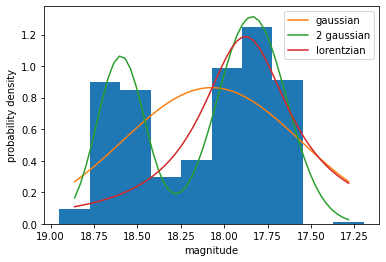

In [12]:
plt.hist(mag,bins=10,density=1)

xx=np.linspace(x.min(),x.max(),50)
plt.plot(xx,gaussian1(xx,popt_g1[0],popt_g1[1],popt_g1[2]),label='gaussian')
plt.plot(xx,gaussian2(xx,popt_g2[0],popt_g2[1],popt_g2[2],popt_g2[3],popt_g2[4],popt_g2[5]),label='2 gaussian')
plt.plot(xx,lorentzian(xx,popt_l[0],popt_l[1],popt_l[2]),label='lorentzian')


plt.xlabel('magnitude')
plt.ylabel('probability density')
plt.gca().invert_xaxis()
plt.legend()

In [13]:
sqerr_gaussian1=((y-gaussian1(x,popt_g1[0],popt_g1[1],popt_g1[2]))**2).sum()
sqerr_gaussian2=((y-gaussian2(x,popt_g2[0],popt_g2[1],popt_g2[2],popt_g2[3],popt_g2[4],popt_g2[5]))**2).sum()
sqerr_lorentzian=((y-lorentzian(x,popt_l[0],popt_l[1],popt_l[2]))**2).sum()
sqerr_gaussian1,sqerr_gaussian2,sqerr_lorentzian

(1.3263598354110846, 0.08064206751272682, 1.2858324961045362)

In [14]:
functions.query(2008)

SourceID,filter,OID,RA,DEC,numobs,DELTA_SIG_MAG,CONST_CHI2,sf,rmse,LNP_SIG,period,period_c,power,power_c,mean,std,min,max,sigma_mean,sigma_std,upsilon_class,upsilon_prob,upsilon_flag,upsilon_period
int32,str2,str16,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str14,float64,float64,float64
2008,zr,806203400030847,5.110891,59.2488888,692,480.68084716796875,9.370025292410064,1.414390394344213e-164,0.0431537926197052,2.7363920650865286e-42,21.617133413881977,0.9999745929464803,0.454655306404008,0.007660250450128612,16.251155853271484,0.0431537926197052,16.16180419921875,16.354297637939453,-0.028389502316713333,3.057053804397583,EB_EC,0.29,0.0,21.59859358428574
2008,zr,1809211300010175,5.1109043,59.2488664,77,569.7900390625,12.8195940842245,2.8548130975724618e-61,0.045768700540065765,4.022650017311482e-24,21.75527775937134,2800.0,0.8127142555311891,0.0025739853043477167,16.215639114379883,0.045768700540065765,16.14676284790039,16.33629035949707,-0.03815987706184387,3.5577316284179688,EB_ESD,0.75,1.0,1.0453921616837123


SourceID,filter,OID,RA,DEC,numobs,DELTA_SIG_MAG,CONST_CHI2,sf,rmse,LNP_SIG,period,period_c,power,power_c,mean,std,min,max,sigma_mean,sigma_std,upsilon_class,upsilon_prob,upsilon_flag,upsilon_period
int32,str2,str16,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str14,float64,float64,float64
2008,zg,806103400000320,5.1108963,59.248881,290,182.97265625,4.030731466818835,2.6455434126168074e-22,0.05399414896965027,6.716040880777474e-14,0.9994859884256547,1.000014139092549,0.23342767327105174,0.24125772654285596,17.681459426879883,0.05399414896965027,17.516620635986328,17.78353500366211,-0.04070346802473068,2.0055160522460938,EB_ESD,0.48,0.0,21.52552758056876
2008,zg,1809111300006633,5.1109104,59.2488647,66,158.75352478027344,4.0040954509383395,2.974605924542952e-06,0.05237360671162605,4.1161247571824625e-11,21.642090858967947,2800.0,0.629287355263702,0.04255981597967369,17.631013870239258,0.05237360671162605,17.517131805419922,17.73626708984375,-0.04601965472102165,1.9873954057693481,EB_EC,0.4,1.0,22.954838911475175


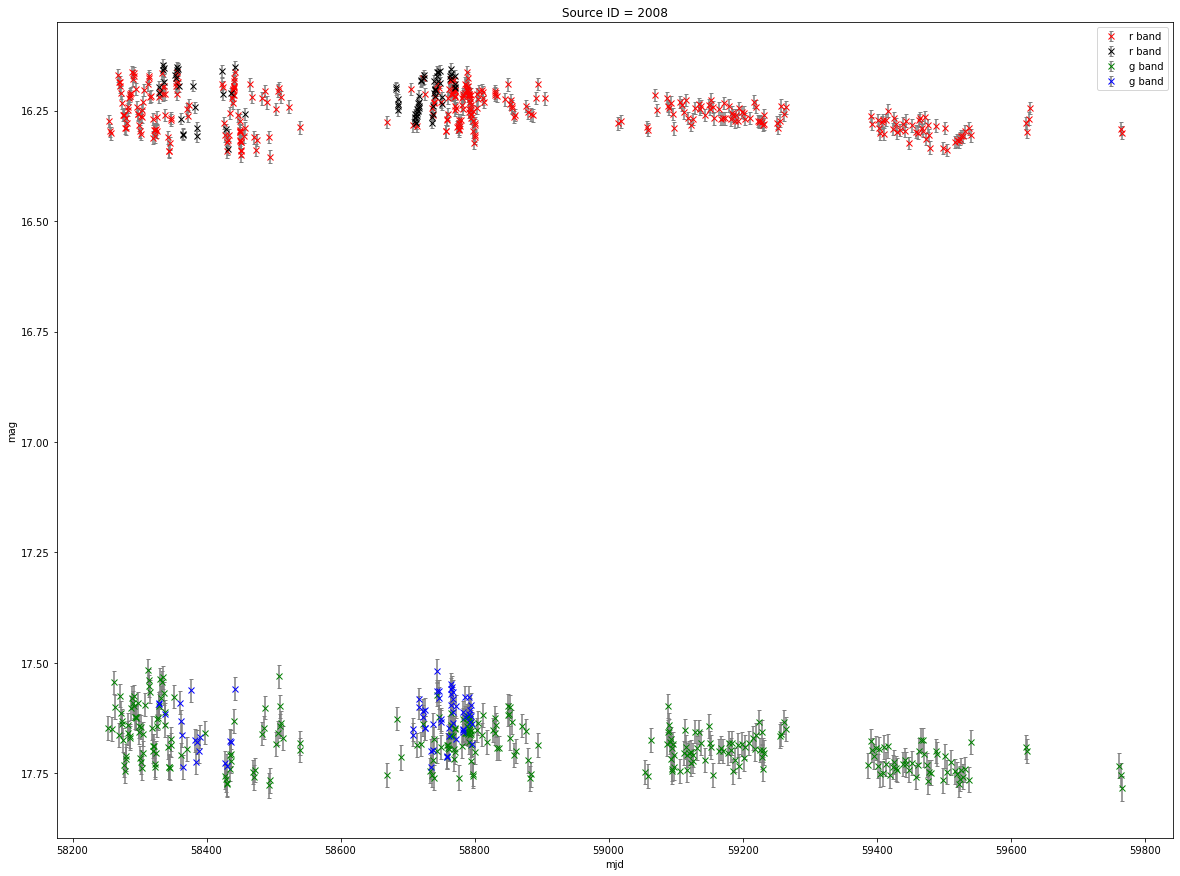

In [15]:
functions.draw_lightcurve(2008)

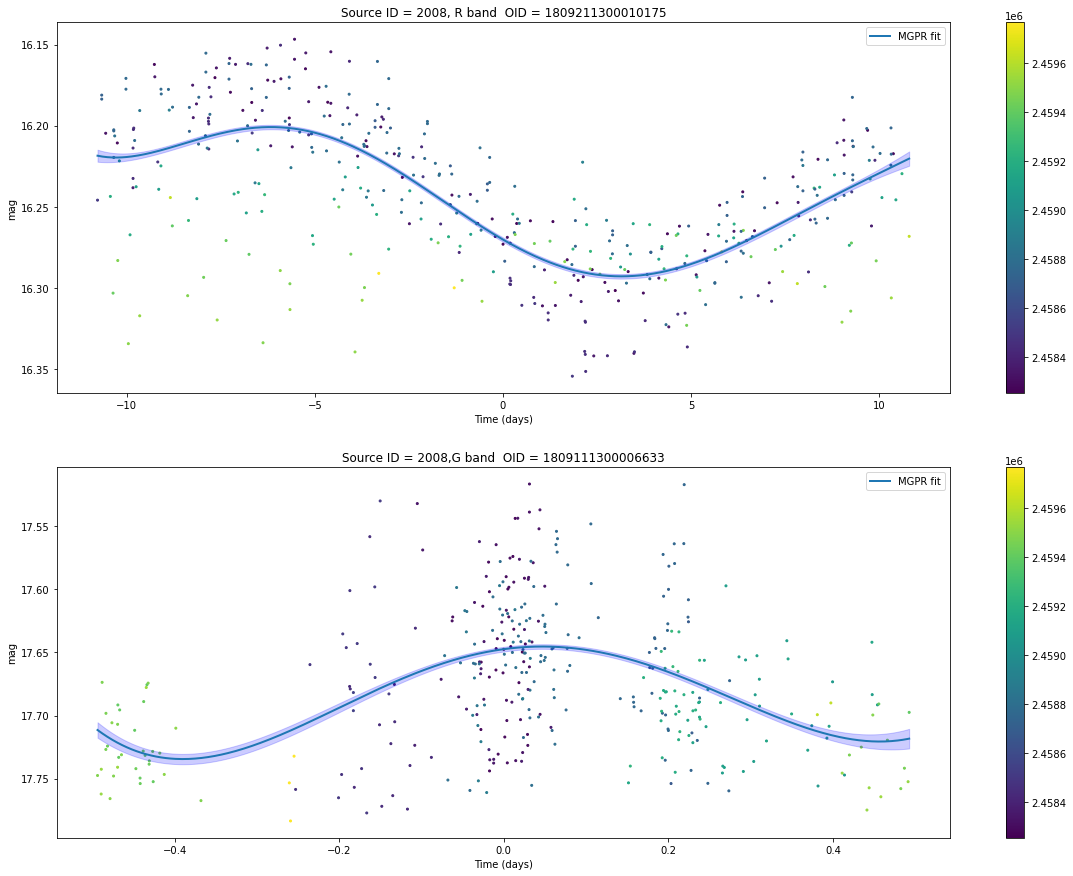

In [16]:
functions.MGPRfit(2008)

In [17]:
def gaussian1(x,c,mu,sigma):
    return c*np.exp(-(x-mu)**2/(2*sigma**2))

def gaussian2(x,c1,mu1,sigma1,c2,mu2,sigma2):
    return c1 * np.exp(-(x-mu1)**2/(2*sigma1**2))+c2*np.exp(-(x-mu2)**2/(2*sigma2**2))

def lorentzian(x,c,cen,wid):
    return c*wid**2/((x-cen)**2+wid**2)

(12.831180714399142, 4.647186581030613, 16.56865763994692)

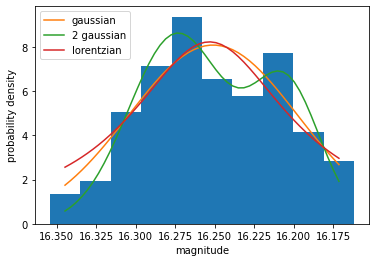

In [18]:
ztf_ID=806203400030847
t=QTable.read('https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?ID='+str(ztf_ID))
#remove bad flags
t=t[t['catflags']==0]
# remove bad days
t=t[(t['mjd']<58481*u.day)|(t['mjd']>58482*u.day)]
t=t[(t['mjd']<58472*u.day)|(t['mjd']>58474*u.day)]
t=t[(t['mjd']<59032*u.day)|(t['mjd']>59033*u.day)]

mag=np.array(t['mag'])

histo=np.histogram(mag,bins=10,density=1)
x=(histo[1][:-1]+histo[1][1:])/2
y=histo[0]

popt_g1,pcov_g1 = curve_fit(gaussian1,x,y,p0=[1,x.mean(),x.std()])
popt_g2,pcov_g2 = curve_fit(gaussian2,x,y,p0=[1,x.mean(),x.std(),1,x.mean(),x.std()])
popt_l,pcov_l = curve_fit(lorentzian,x,y,p0=[1,x.mean(),x.std()])


plt.hist(mag,bins=10,density=1)

xx=np.linspace(x.min(),x.max(),50)
plt.plot(xx,gaussian1(xx,popt_g1[0],popt_g1[1],popt_g1[2]),label='gaussian')
plt.plot(xx,gaussian2(xx,popt_g2[0],popt_g2[1],popt_g2[2],popt_g2[3],popt_g2[4],popt_g2[5]),label='2 gaussian')
plt.plot(xx,lorentzian(xx,popt_l[0],popt_l[1],popt_l[2]),label='lorentzian')


plt.xlabel('magnitude')
plt.ylabel('probability density')
plt.gca().invert_xaxis()
plt.legend()

sqerr_gaussian1=((y-gaussian1(x,popt_g1[0],popt_g1[1],popt_g1[2]))**2).sum()
sqerr_gaussian2=((y-gaussian2(x,popt_g2[0],popt_g2[1],popt_g2[2],popt_g2[3],popt_g2[4],popt_g2[5]))**2).sum()
sqerr_lorentzian=((y-lorentzian(x,popt_l[0],popt_l[1],popt_l[2]))**2).sum()
sqerr_gaussian1,sqerr_gaussian2,sqerr_lorentzian

In [19]:
'''#functions.fit_mag(), copied from functions.py for Matteo
def fit_mag(ztf_ID,plot=False):
    def gaussian1(x,c,mu,sigma):
        return c*np.exp(-(x-mu)**2/(2*sigma**2))

    def gaussian2(x,c1,mu1,sigma1,c2,mu2,sigma2):
        return c1 * np.exp(-(x-mu1)**2/(2*sigma1**2))+c2*np.exp(-(x-mu2)**2/(2*sigma2**2))

    def lorentzian(x,c,cen,wid):
        return c*wid**2/((x-cen)**2+wid**2)
    
    
    try:
        t=QTable.read('https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?ID='+str(ztf_ID))
    except:
        print('2nd download attempt in 30 seconds...')
        time.sleep(30)
        try:
            t=QTable.read('https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?ID='+str(ztf_ID))
        except:
            print('3rd download attempt in 30 seconds...')
            time.sleep(30)
            try:
                t=QTable.read('https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?ID='+str(ztf_ID))
            except:
                print('last download attempt failed')
                    
    
    #remove bad flags
    t=t[t['catflags']==0]
    # remove bad days
    t=t[(t['mjd']<58481*u.day)|(t['mjd']>58482*u.day)]
    t=t[(t['mjd']<58472*u.day)|(t['mjd']>58474*u.day)]
    t=t[(t['mjd']<59032*u.day)|(t['mjd']>59033*u.day)]

    mag=np.array(t['mag'])

    histo=np.histogram(mag,bins=10,density=1)
    x=(histo[1][:-1]+histo[1][1:])/2
    y=histo[0]
    
    if plot:
        plt.hist(mag,bins=10,density=1,alpha=0.5)
        xx=np.linspace(x.min(),x.max(),50)
    
    # 1 gaussian
    try:
        popt_g1,pcov_g1 = curve_fit(gaussian1,x,y,p0=[1,x.mean(),x.std()])
        
        if plot:
            plt.plot(xx,gaussian1(xx,popt_g1[0],popt_g1[1],popt_g1[2]),label='gaussian')
            
        sqerr_gaussian1=((y-gaussian1(x,popt_g1[0],popt_g1[1],popt_g1[2]))**2).sum()
        
    except:
        sqerr_gaussian1=None
        
    # 2 gaussian
    try:
        popt_g2,pcov_g2 = curve_fit(gaussian2,x,y,p0=[1,x.mean(),x.std(),1,x.mean(),x.std()])
        
        if plot:
            plt.plot(xx,gaussian2(xx,popt_g2[0],popt_g2[1],popt_g2[2],popt_g2[3],popt_g2[4],popt_g2[5]),label='2 gaussian')
        
        sqerr_gaussian2=((y-gaussian2(x,popt_g2[0],popt_g2[1],popt_g2[2],popt_g2[3],popt_g2[4],popt_g2[5]))**2).sum()
        
    except:
        sqerr_gaussian2=None
        
    # lorentzian    
    try:    
        popt_l,pcov_l = curve_fit(lorentzian,x,y,p0=[1,x.mean(),x.std()])
        
        if plot:
            plt.plot(xx,lorentzian(xx,popt_l[0],popt_l[1],popt_l[2]),label='lorentzian')
        
        sqerr_lorentzian=((y-lorentzian(x,popt_l[0],popt_l[1],popt_l[2]))**2).sum()
        
    except:
        sqerr_lorentzian=None

    if plot:
        plt.xlabel('magnitude')
        plt.ylabel('probability density')
        plt.gca().invert_xaxis()
        plt.legend()
    return sqerr_gaussian1,sqerr_gaussian2,sqerr_lorentzian
'''

"functions.fit_mag(), copied from functions.py for Matteo\ndef fit_mag(ztf_ID,plot=False):\n    def gaussian1(x,c,mu,sigma):\n        return c*np.exp(-(x-mu)**2/(2*sigma**2))\n\n    def gaussian2(x,c1,mu1,sigma1,c2,mu2,sigma2):\n        return c1 * np.exp(-(x-mu1)**2/(2*sigma1**2))+c2*np.exp(-(x-mu2)**2/(2*sigma2**2))\n\n    def lorentzian(x,c,cen,wid):\n        return c*wid**2/((x-cen)**2+wid**2)\n    \n    \n    try:\n        t=QTable.read('https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?ID='+str(ztf_ID))\n    except:\n        print('2nd download attempt in 30 seconds...')\n        time.sleep(30)\n        try:\n            t=QTable.read('https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?ID='+str(ztf_ID))\n        except:\n            print('3rd download attempt in 30 seconds...')\n            time.sleep(30)\n            try:\n                t=QTable.read('https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?ID='+str(ztf_ID))\n            except:\n          

In [20]:
functions.query(1850)

SourceID,filter,OID,RA,DEC,numobs,DELTA_SIG_MAG,CONST_CHI2,sf,rmse,LNP_SIG,period,period_c,power,power_c,mean,std,min,max,sigma_mean,sigma_std,upsilon_class,upsilon_prob,upsilon_flag,upsilon_period
int32,str2,str16,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str14,float64,float64,float64
1850,zr,806203100056802,5.1627826,59.3338678,794,1297.2017822265625,100.95216786056669,0.0,0.15188229084014893,2.8219302520843922e-05,383.73478252936764,0.997336033066433,0.08717269684140211,0.5482003160102764,16.517696380615234,0.15188229084014893,16.057037353515625,16.6666316986084,-0.356020450592041,10.05529499053955,LPV_SRV_AGB_C,0.34,1.0,412.33678660909146
1850,zr,1809211300054065,5.1628009,59.3338576,65,1363.31396484375,100.417249665904,0.0,0.13076886534690857,0.0454377920026495,382.40917435630683,2800.0,0.2687718330945265,0.9463009142922628,16.54872703552246,0.13076886534690857,16.147106170654297,16.645401000976562,-0.34018266201019287,9.962369918823242,DSCT,0.51,1.0,0.0379377391285726


SourceID,filter,OID,RA,DEC,numobs,DELTA_SIG_MAG,CONST_CHI2,sf,rmse,LNP_SIG,period,period_c,power,power_c,mean,std,min,max,sigma_mean,sigma_std,upsilon_class,upsilon_prob,upsilon_flag,upsilon_period
int32,str2,str16,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str14,float64,float64,float64
1850,zg,806103100035990,5.1628432,59.3338686,352,367.3136291503906,3.8747718951976924,1.4412050224149598e-23,0.042756568640470505,3.473313424941895e-09,0.9972441069114794,1.0000143393856216,0.14576038902822522,0.9062941526907431,17.09967041015625,0.042756568640470505,16.87520980834961,17.224563598632812,-0.02334051951766014,1.9661048650741577,RRL_ab,0.55,1.0,0.49866809584432725
1850,zg,1809111300028337,5.1629102,59.3338721,66,369.758056640625,8.993846355203743,1.4372433772059054e-30,0.062223631888628006,0.010649167817866203,0.14520695221302013,2800.0,0.2991574708729832,0.0018712458136795442,17.083194732666016,0.062223631888628006,16.88591957092285,17.212621688842773,-0.063193678855896,2.9782087802886963,NonVar,0.49,1.0,0.14520845935911914


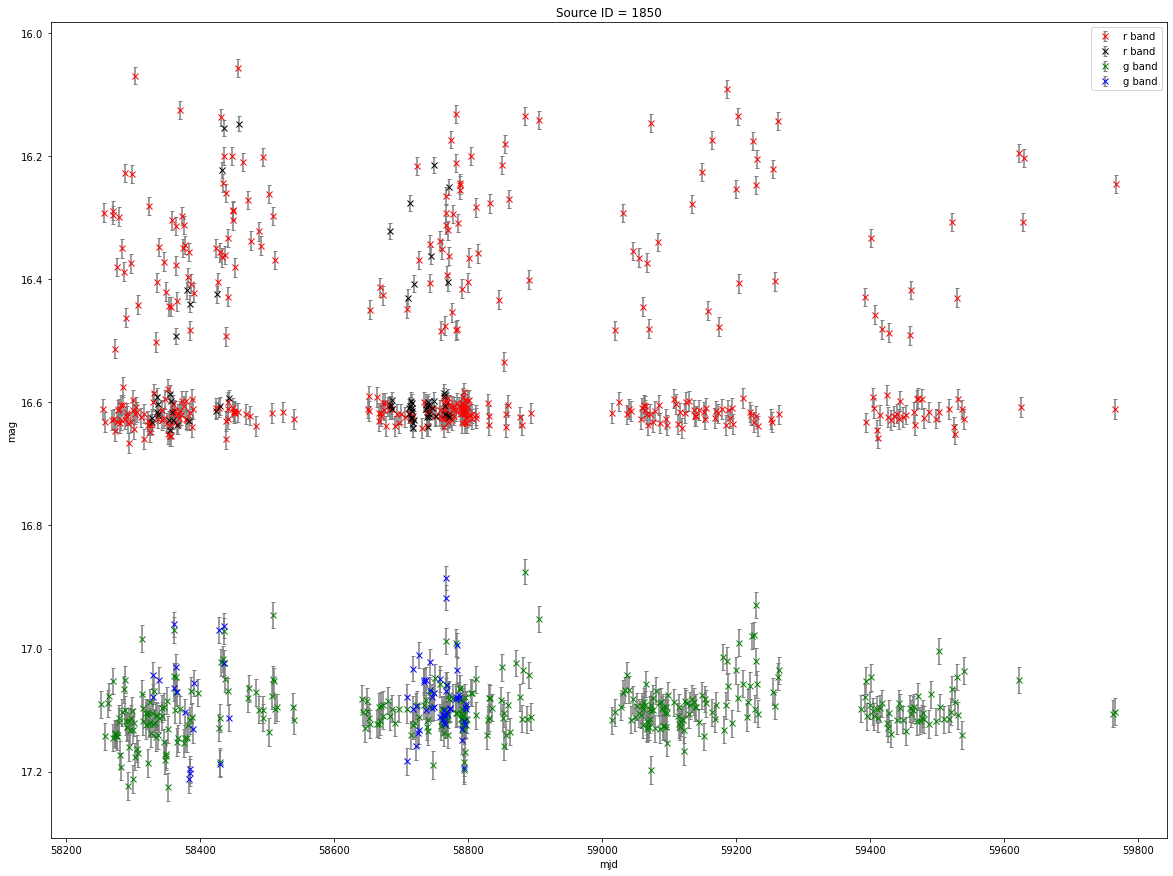

In [21]:
functions.draw_lightcurve(1850)

In [22]:
## this one none of the fit model converges...

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(nan, nan, nan)

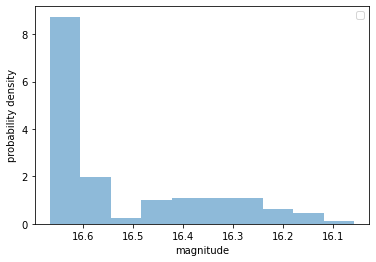

In [23]:
functions.fit_mag(806203100056802,plot=True)

D:\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(2.9824474029252954, 2.982447674094569, 0.9898101037698772)

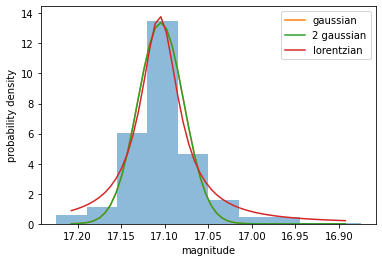

In [24]:
functions.fit_mag(806103100035990,plot=True)

In [25]:
functions.query(184)

SourceID,filter,OID,RA,DEC,numobs,DELTA_SIG_MAG,CONST_CHI2,sf,rmse,LNP_SIG,period,period_c,power,power_c,mean,std,min,max,sigma_mean,sigma_std,upsilon_class,upsilon_prob,upsilon_flag,upsilon_period
int32,str2,str16,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str14,float64,float64,float64
184,zr,806203100057067,5.0986803,59.2984197,836,157.6642608642578,3.072022020197283,6.191108235112681e-12,0.06915326416492462,0.0037812641610262903,1.0002392170030603,0.997336033066433,0.06269523169363354,0.6919892739620936,18.58424949645996,0.06915326416492462,18.270721435546875,18.792484283447266,-0.07682469487190247,1.7559287548065186,LPV_SRV_AGB_O,0.34,1.0,503.96718363333395
184,zr,1809211300066728,5.0986881,59.298406,77,104.58232879638672,2.6054272838502475,0.03935948464308344,0.060274891555309296,0.03406576994449976,0.26687694256657507,2800.0,0.2401746825224701,0.030334011754476125,18.580507278442383,0.060274891555309296,18.415571212768555,18.713054656982422,-0.06434640288352966,1.6074998378753662,NonVar,0.52,1.0,0.03306605871886117


SourceID,filter,OID,RA,DEC,numobs,DELTA_SIG_MAG,CONST_CHI2,sf,rmse,LNP_SIG,period,period_c,power,power_c,mean,std,min,max,sigma_mean,sigma_std,upsilon_class,upsilon_prob,upsilon_flag,upsilon_period
int32,str2,str16,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str14,float64,float64,float64
184,zg,806103100040269,5.0986632,59.2984379,306,64.44194030761719,2.180014628077658,0.13274855025262017,0.10727692395448685,0.05525222333071616,0.18735723799247758,1.0000143393856216,0.06692860825627595,0.0012062296058175665,19.525270462036133,0.10727692395448685,19.186538696289062,20.058429718017578,-0.10165885090827942,1.4843672513961792,NonVar,0.45,1.0,0.05853434592146185
184,zg,1809111300028745,5.098726,59.298429,62,40.239986419677734,2.197042063381515,0.27856224712878896,0.10968253761529922,0.14075485323869813,0.4601377323483966,2800.0,0.2454529009681552,0.020184055197709123,19.479806900024414,0.10968253761529922,19.213882446289062,19.696168899536133,-0.10696635395288467,1.4822852611541748,DSCT,0.57,1.0,0.03492492888035282


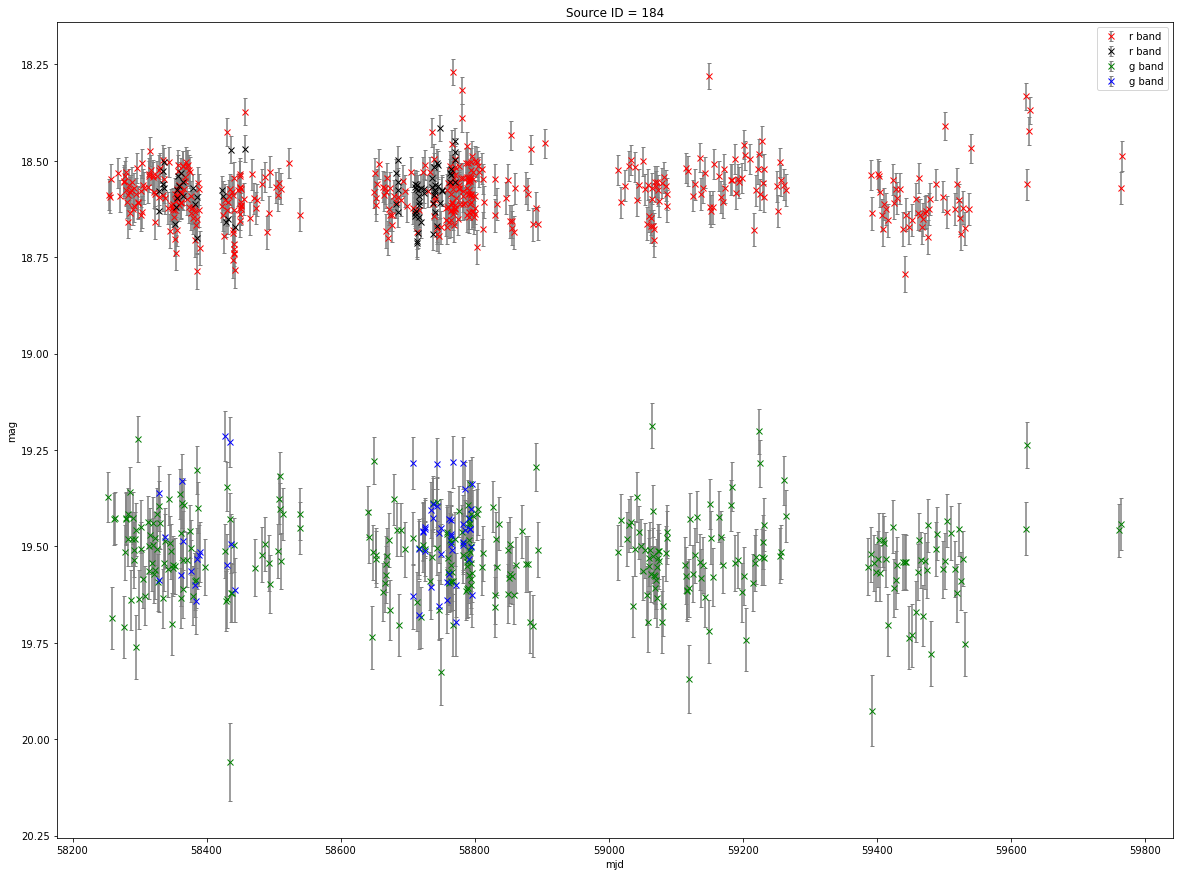

In [27]:
functions.draw_lightcurve(184)

(0.13740454765744844, 0.0966138726972427, 1.3949262624925511)

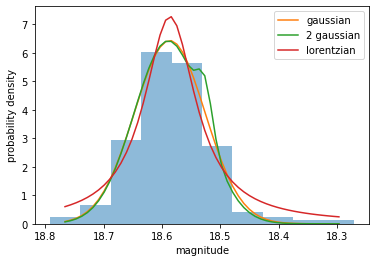

In [28]:
functions.fit_mag(806203100057067,plot=True)

In [29]:
t=QTable.read('t_zr_0918.ecsv')
t.add_column(np.zeros(len(t)),name='gaussian1_err',index=-5)
t.add_column(np.zeros(len(t)),name='gaussian2_err',index=-5)
t.add_column(np.zeros(len(t)),name='lorentzian_err',index=-5)


for i,row in tqdm(enumerate(t),total=len(t)):
    if np.isnan(row['mean']):
        print('This guy has too few observations')
        t[i]['gaussian1_err']=np.nan
        t[i]['gaussian2_err']=np.nan
        t[i]['lorentzian_err']=np.nan
    else:
        sqerr_gaussian1,sqerr_gaussian2,sqerr_lorentzian=functions.fit_mag(str(int(row['OID'])))
        
        t[i]['gaussian1_err']=sqerr_gaussian1
        t[i]['gaussian2_err']=sqerr_gaussian2
        t[i]['lorentzian_err']=sqerr_lorentzian
        
        #_=input('debug')
        
        
t.write('t_zr_0923.ecsv')
astropy.utils.data.clear_download_cache()

  0%|▏                                                                              | 7/4099 [00:20<2:53:55,  2.55s/it]

This guy has too few observations
This guy has too few observations


  0%|▏                                                                             | 12/4099 [00:26<1:54:23,  1.68s/it]

This guy has too few observations


  0%|▎                                                                             | 18/4099 [00:36<1:59:46,  1.76s/it]

This guy has too few observations


  0%|▍                                                                             | 20/4099 [00:38<1:37:02,  1.43s/it]D:\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
  1%|▍                                                                             | 23/4099 [00:45<2:11:12,  1.93s/it]

This guy has too few observations
This guy has too few observations


  1%|▌                                                                             | 31/4099 [01:02<2:51:43,  2.53s/it]

This guy has too few observations
2nd download attempt in 30 seconds...


  1%|▋                                                                             | 38/4099 [01:57<4:37:30,  4.10s/it]

This guy has too few observations


  1%|▊                                                                             | 41/4099 [02:04<3:17:52,  2.93s/it]

This guy has too few observations


  1%|▊                                                                             | 43/4099 [02:05<2:17:12,  2.03s/it]

This guy has too few observations


  1%|▉                                                                             | 47/4099 [02:11<2:02:05,  1.81s/it]

This guy has too few observations
This guy has too few observations


  1%|▉                                                                             | 50/4099 [02:15<1:40:41,  1.49s/it]

This guy has too few observations


  1%|█                                                                             | 54/4099 [02:21<1:45:21,  1.56s/it]

This guy has too few observations


  1%|█▏                                                                            | 60/4099 [02:36<3:13:11,  2.87s/it]

This guy has too few observations


  2%|█▏                                                                            | 62/4099 [02:39<2:29:18,  2.22s/it]

This guy has too few observations


  2%|█▎                                                                            | 68/4099 [02:51<2:49:49,  2.53s/it]

This guy has too few observations


  2%|█▍                                                                            | 73/4099 [02:58<2:13:46,  1.99s/it]

This guy has too few observations


  2%|█▍                                                                            | 76/4099 [03:02<1:51:17,  1.66s/it]

This guy has too few observations


  2%|█▌                                                                            | 80/4099 [03:13<2:32:48,  2.28s/it]

This guy has too few observations


  2%|█▋                                                                            | 87/4099 [03:32<3:38:02,  3.26s/it]

This guy has too few observations


  2%|█▊                                                                            | 92/4099 [03:42<2:44:51,  2.47s/it]

This guy has too few observations


  2%|█▊                                                                            | 98/4099 [03:54<2:43:34,  2.45s/it]

This guy has too few observations
This guy has too few observations


  3%|█▉                                                                           | 105/4099 [04:11<2:45:10,  2.48s/it]

This guy has too few observations


  3%|██                                                                           | 107/4099 [04:16<2:45:42,  2.49s/it]

This guy has too few observations


  3%|██▏                                                                          | 116/4099 [04:39<3:17:26,  2.97s/it]

This guy has too few observations


  3%|██▎                                                                          | 121/4099 [04:52<2:54:52,  2.64s/it]

2nd download attempt in 30 seconds...


  3%|██▎                                                                         | 123/4099 [05:36<11:21:40, 10.29s/it]

This guy has too few observations


  3%|██▎                                                                          | 125/4099 [05:38<6:41:42,  6.07s/it]

This guy has too few observations


  3%|██▌                                                                          | 137/4099 [06:09<2:41:40,  2.45s/it]

This guy has too few observations


  3%|██▌                                                                          | 139/4099 [06:10<1:54:45,  1.74s/it]

This guy has too few observations


  3%|██▋                                                                          | 142/4099 [06:17<2:11:06,  1.99s/it]

This guy has too few observations


  4%|██▊                                                                          | 150/4099 [06:36<2:20:02,  2.13s/it]

This guy has too few observations
This guy has too few observations


  4%|██▉                                                                          | 159/4099 [06:57<2:43:02,  2.48s/it]

This guy has too few observations
This guy has too few observations


  4%|███▏                                                                         | 169/4099 [07:17<2:29:33,  2.28s/it]

This guy has too few observations


  4%|███▍                                                                         | 180/4099 [07:41<2:18:54,  2.13s/it]

This guy has too few observations


  5%|███▍                                                                         | 185/4099 [07:54<2:42:51,  2.50s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


  5%|███▌                                                                         | 192/4099 [08:06<2:33:07,  2.35s/it]

This guy has too few observations


  5%|███▊                                                                         | 205/4099 [08:42<3:08:53,  2.91s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


  5%|████                                                                         | 216/4099 [09:01<2:35:08,  2.40s/it]

This guy has too few observations


  5%|████                                                                         | 219/4099 [09:05<2:06:16,  1.95s/it]

This guy has too few observations


  5%|████▏                                                                        | 223/4099 [09:15<2:56:33,  2.73s/it]

This guy has too few observations


  6%|████▎                                                                        | 229/4099 [09:28<2:51:00,  2.65s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


  6%|████▍                                                                        | 234/4099 [09:33<1:41:20,  1.57s/it]

This guy has too few observations
This guy has too few observations


  6%|████▋                                                                        | 250/4099 [10:09<2:26:20,  2.28s/it]

This guy has too few observations
This guy has too few observations


  6%|████▉                                                                        | 263/4099 [10:40<2:28:39,  2.33s/it]

This guy has too few observations


  6%|████▉                                                                        | 266/4099 [10:44<1:46:46,  1.67s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


  7%|█████▏                                                                       | 276/4099 [11:05<3:03:42,  2.88s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


  7%|█████▎                                                                       | 282/4099 [11:16<2:17:39,  2.16s/it]

This guy has too few observations


  7%|█████▎                                                                       | 286/4099 [11:23<2:13:01,  2.09s/it]

This guy has too few observations


  7%|█████▍                                                                       | 289/4099 [11:30<2:34:21,  2.43s/it]

This guy has too few observations


  7%|█████▋                                                                       | 300/4099 [12:00<2:39:25,  2.52s/it]

This guy has too few observations


  7%|█████▋                                                                       | 303/4099 [12:06<2:31:58,  2.40s/it]

This guy has too few observations


  8%|█████▊                                                                       | 310/4099 [12:23<2:29:24,  2.37s/it]

This guy has too few observations


  8%|██████                                                                       | 326/4099 [13:04<3:27:57,  3.31s/it]

This guy has too few observations


  8%|██████▏                                                                      | 329/4099 [13:12<3:07:38,  2.99s/it]

2nd download attempt in 30 seconds...


  8%|██████▏                                                                     | 331/4099 [13:56<10:43:59, 10.25s/it]

This guy has too few observations


  8%|██████▎                                                                      | 338/4099 [14:14<3:50:00,  3.67s/it]

This guy has too few observations
This guy has too few observations


  9%|██████▌                                                                      | 349/4099 [14:41<2:58:09,  2.85s/it]

This guy has too few observations


  9%|██████▋                                                                      | 357/4099 [15:02<3:07:42,  3.01s/it]

This guy has too few observations


  9%|██████▊                                                                      | 360/4099 [15:09<2:58:41,  2.87s/it]

This guy has too few observations


  9%|██████▉                                                                      | 366/4099 [15:24<2:35:20,  2.50s/it]

This guy has too few observations


  9%|███████                                                                      | 373/4099 [15:40<3:04:17,  2.97s/it]

2nd download attempt in 30 seconds...


  9%|██████▉                                                                     | 374/4099 [16:22<14:41:52, 14.20s/it]

This guy has too few observations


  9%|███████                                                                      | 378/4099 [16:31<5:59:43,  5.80s/it]

This guy has too few observations
This guy has too few observations


  9%|███████▎                                                                     | 387/4099 [16:51<2:53:06,  2.80s/it]

This guy has too few observations


  9%|███████▎                                                                     | 389/4099 [16:53<2:03:07,  1.99s/it]

2nd download attempt in 30 seconds...


 10%|███████▎                                                                     | 392/4099 [17:41<7:51:18,  7.63s/it]

This guy has too few observations


 10%|███████▍                                                                     | 394/4099 [17:45<5:08:35,  5.00s/it]

This guy has too few observations


 10%|███████▍                                                                     | 396/4099 [17:46<3:31:40,  3.43s/it]

This guy has too few observations


 10%|███████▌                                                                     | 401/4099 [17:59<3:06:11,  3.02s/it]

This guy has too few observations


 10%|███████▉                                                                     | 424/4099 [19:08<3:20:14,  3.27s/it]

This guy has too few observations


 10%|████████                                                                     | 426/4099 [19:11<2:38:26,  2.59s/it]

This guy has too few observations
This guy has too few observations


 11%|████████                                                                     | 431/4099 [19:19<2:12:49,  2.17s/it]

2nd download attempt in 30 seconds...


 11%|████████                                                                    | 432/4099 [20:01<11:42:16, 11.49s/it]

This guy has too few observations


 11%|████████▏                                                                    | 434/4099 [20:03<7:21:52,  7.23s/it]

This guy has too few observations


 11%|████████▍                                                                    | 446/4099 [20:35<2:57:45,  2.92s/it]

This guy has too few observations


 11%|████████▍                                                                    | 451/4099 [20:47<2:25:01,  2.39s/it]

This guy has too few observations


 11%|████████▌                                                                    | 455/4099 [20:53<1:50:49,  1.82s/it]

This guy has too few observations


 11%|████████▋                                                                    | 462/4099 [21:07<2:06:21,  2.08s/it]

This guy has too few observations


 11%|████████▋                                                                    | 465/4099 [21:10<1:34:02,  1.55s/it]

This guy has too few observations


 11%|████████▊                                                                    | 469/4099 [21:20<2:25:32,  2.41s/it]

This guy has too few observations


 12%|████████▊                                                                    | 472/4099 [21:27<2:21:59,  2.35s/it]

This guy has too few observations


 12%|████████▉                                                                    | 474/4099 [21:28<1:47:13,  1.77s/it]

This guy has too few observations
This guy has too few observations


 12%|████████▉                                                                    | 477/4099 [21:32<1:32:52,  1.54s/it]

This guy has too few observations
This guy has too few observations


 12%|█████████                                                                    | 481/4099 [21:36<1:18:33,  1.30s/it]

This guy has too few observations


 12%|█████████▏                                                                   | 488/4099 [21:52<1:57:09,  1.95s/it]

This guy has too few observations
This guy has too few observations


 12%|█████████▏                                                                   | 491/4099 [21:55<1:36:35,  1.61s/it]

This guy has too few observations


 12%|█████████▎                                                                   | 497/4099 [22:10<2:18:29,  2.31s/it]

This guy has too few observations
This guy has too few observations


 12%|█████████▍                                                                   | 503/4099 [22:18<1:42:26,  1.71s/it]

This guy has too few observations
This guy has too few observations


 12%|█████████▌                                                                   | 506/4099 [22:20<1:05:43,  1.10s/it]

This guy has too few observations


 12%|█████████▌                                                                   | 509/4099 [22:26<1:33:04,  1.56s/it]

This guy has too few observations


 13%|█████████▋                                                                   | 514/4099 [22:36<1:45:52,  1.77s/it]

This guy has too few observations


 13%|█████████▋                                                                   | 519/4099 [22:47<2:00:38,  2.02s/it]

This guy has too few observations


 13%|█████████▊                                                                   | 523/4099 [22:53<1:47:11,  1.80s/it]

This guy has too few observations


 13%|█████████▉                                                                   | 526/4099 [23:00<2:04:34,  2.09s/it]

This guy has too few observations
This guy has too few observations


 13%|█████████▉                                                                   | 531/4099 [23:10<2:05:08,  2.10s/it]

This guy has too few observations
This guy has too few observations


 13%|██████████                                                                   | 536/4099 [23:17<1:49:06,  1.84s/it]

This guy has too few observations


 13%|██████████▏                                                                  | 541/4099 [23:25<1:39:42,  1.68s/it]

This guy has too few observations


 13%|██████████▎                                                                  | 549/4099 [23:44<2:14:01,  2.27s/it]

This guy has too few observations


 13%|██████████▎                                                                  | 551/4099 [23:47<1:49:24,  1.85s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 14%|██████████▋                                                                  | 571/4099 [24:27<2:52:41,  2.94s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 14%|██████████▊                                                                  | 576/4099 [24:33<1:46:26,  1.81s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 14%|██████████▉                                                                  | 582/4099 [24:39<1:19:52,  1.36s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 14%|███████████                                                                  | 589/4099 [24:52<1:59:03,  2.04s/it]

This guy has too few observations
This guy has too few observations


 14%|███████████▏                                                                 | 593/4099 [24:56<1:33:59,  1.61s/it]

This guy has too few observations


 15%|███████████▍                                                                 | 611/4099 [25:34<2:15:31,  2.33s/it]

This guy has too few observations


 15%|███████████▌                                                                 | 616/4099 [25:46<2:05:17,  2.16s/it]

This guy has too few observations


 15%|███████████▋                                                                 | 620/4099 [25:55<2:08:47,  2.22s/it]

This guy has too few observations


 15%|███████████▊                                                                 | 626/4099 [26:07<1:58:06,  2.04s/it]

This guy has too few observations


 15%|███████████▊                                                                 | 631/4099 [26:17<1:50:30,  1.91s/it]

This guy has too few observations
This guy has too few observations


 15%|███████████▉                                                                 | 634/4099 [26:20<1:24:39,  1.47s/it]

This guy has too few observations
This guy has too few observations


 16%|████████████                                                                 | 639/4099 [26:25<1:13:37,  1.28s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 16%|████████████                                                                 | 645/4099 [26:34<1:34:56,  1.65s/it]

This guy has too few observations


 16%|████████████▏                                                                | 647/4099 [26:36<1:22:02,  1.43s/it]

This guy has too few observations


 16%|████████████▏                                                                | 649/4099 [26:38<1:12:41,  1.26s/it]

This guy has too few observations


 16%|████████████▍                                                                | 662/4099 [27:06<2:33:45,  2.68s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 16%|████████████▋                                                                | 674/4099 [27:31<2:25:19,  2.55s/it]

This guy has too few observations
This guy has too few observations


 17%|████████████▊                                                                | 680/4099 [27:42<2:04:27,  2.18s/it]

This guy has too few observations


 17%|████████████▊                                                                | 684/4099 [27:49<1:48:58,  1.91s/it]

This guy has too few observations
This guy has too few observations


 17%|████████████▉                                                                | 689/4099 [27:58<1:57:48,  2.07s/it]

This guy has too few observations


 17%|█████████████                                                                | 695/4099 [28:10<2:05:04,  2.20s/it]

This guy has too few observations


 17%|█████████████                                                                | 697/4099 [28:11<1:29:33,  1.58s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 17%|█████████████▌                                                                 | 702/4099 [28:14<50:51,  1.11it/s]

This guy has too few observations
This guy has too few observations


 17%|█████████████▎                                                               | 706/4099 [28:21<1:20:41,  1.43s/it]

This guy has too few observations


 17%|█████████████▎                                                               | 710/4099 [28:28<1:31:38,  1.62s/it]

This guy has too few observations
This guy has too few observations


 17%|█████████████▍                                                               | 713/4099 [28:30<1:09:33,  1.23s/it]

2nd download attempt in 30 seconds...


 17%|█████████████▍                                                               | 714/4099 [29:14<8:15:38,  8.79s/it]

This guy has too few observations


 17%|█████████████▍                                                               | 716/4099 [29:16<5:48:24,  6.18s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 18%|█████████████▌                                                               | 721/4099 [29:23<3:14:35,  3.46s/it]

This guy has too few observations


 18%|█████████████▌                                                               | 725/4099 [29:32<2:58:03,  3.17s/it]

This guy has too few observations
This guy has too few observations


 18%|█████████████▋                                                               | 728/4099 [29:36<2:11:40,  2.34s/it]

This guy has too few observations


 18%|█████████████▊                                                               | 735/4099 [29:49<1:50:36,  1.97s/it]

This guy has too few observations
This guy has too few observations


 18%|█████████████▉                                                               | 740/4099 [29:57<2:02:05,  2.18s/it]

This guy has too few observations
This guy has too few observations


 18%|██████████████                                                               | 746/4099 [30:08<2:04:30,  2.23s/it]

This guy has too few observations
This guy has too few observations


 18%|██████████████▏                                                              | 756/4099 [30:27<2:07:51,  2.29s/it]

This guy has too few observations
This guy has too few observations


 19%|██████████████▎                                                              | 763/4099 [30:41<2:17:19,  2.47s/it]

This guy has too few observations


 19%|██████████████▎                                                              | 765/4099 [30:43<1:36:22,  1.73s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 19%|██████████████▌                                                              | 773/4099 [31:01<2:18:26,  2.50s/it]

This guy has too few observations


 19%|██████████████▌                                                              | 777/4099 [31:10<2:16:18,  2.46s/it]

This guy has too few observations


 19%|██████████████▋                                                              | 785/4099 [31:36<3:39:17,  3.97s/it]

This guy has too few observations


 19%|██████████████▊                                                              | 789/4099 [31:46<2:49:18,  3.07s/it]

This guy has too few observations
This guy has too few observations
2nd download attempt in 30 seconds...


 19%|██████████████▉                                                              | 792/4099 [32:28<8:05:35,  8.81s/it]

This guy has too few observations


 19%|██████████████▉                                                              | 795/4099 [32:32<4:56:43,  5.39s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 19%|███████████████                                                              | 799/4099 [32:34<2:33:51,  2.80s/it]

This guy has too few observations


 20%|███████████████                                                              | 801/4099 [32:36<2:06:52,  2.31s/it]

This guy has too few observations


 20%|███████████████                                                              | 803/4099 [32:37<1:40:50,  1.84s/it]

This guy has too few observations


 20%|███████████████                                                              | 805/4099 [32:39<1:26:22,  1.57s/it]

This guy has too few observations
This guy has too few observations


 20%|███████████████▏                                                             | 808/4099 [32:40<1:05:34,  1.20s/it]

This guy has too few observations


 20%|███████████████▎                                                             | 812/4099 [32:52<1:55:22,  2.11s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 20%|███████████████▊                                                               | 821/4099 [32:53<41:49,  1.31it/s]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 20%|███████████████▉                                                               | 827/4099 [33:01<56:48,  1.04s/it]

This guy has too few observations
2nd download attempt in 30 seconds...


 20%|███████████████▌                                                             | 829/4099 [33:46<6:02:49,  6.66s/it]

This guy has too few observations


 20%|███████████████▌                                                             | 831/4099 [33:50<4:58:05,  5.47s/it]

This guy has too few observations


 20%|███████████████▋                                                             | 837/4099 [34:03<3:14:50,  3.58s/it]

This guy has too few observations


 21%|███████████████▊                                                             | 841/4099 [34:10<2:11:51,  2.43s/it]

This guy has too few observations


 21%|███████████████▊                                                             | 843/4099 [34:13<1:50:35,  2.04s/it]

This guy has too few observations
This guy has too few observations


 21%|███████████████▉                                                             | 846/4099 [34:14<1:11:11,  1.31s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 21%|████████████████▍                                                              | 855/4099 [34:16<29:51,  1.81it/s]

This guy has too few observations
This guy has too few observations


 21%|████████████████▌                                                              | 859/4099 [34:20<38:19,  1.41it/s]

This guy has too few observations


 21%|████████████████▌                                                              | 861/4099 [34:22<44:58,  1.20it/s]

This guy has too few observations
This guy has too few observations


 21%|████████████████▏                                                            | 865/4099 [34:31<1:20:13,  1.49s/it]

This guy has too few observations
This guy has too few observations


 21%|████████████████▍                                                            | 874/4099 [34:53<2:31:43,  2.82s/it]

This guy has too few observations
This guy has too few observations


 21%|████████████████▌                                                            | 879/4099 [34:59<1:36:00,  1.79s/it]

This guy has too few observations
This guy has too few observations


 22%|████████████████▌                                                            | 882/4099 [35:00<1:01:49,  1.15s/it]

This guy has too few observations


 22%|████████████████▌                                                            | 884/4099 [35:06<1:29:52,  1.68s/it]

This guy has too few observations
This guy has too few observations


 22%|████████████████▋                                                            | 887/4099 [35:08<1:07:18,  1.26s/it]

This guy has too few observations


 22%|████████████████▋                                                            | 891/4099 [35:18<1:45:16,  1.97s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 22%|█████████████████▎                                                             | 896/4099 [35:19<53:46,  1.01s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 22%|█████████████████▎                                                             | 901/4099 [35:21<39:24,  1.35it/s]

This guy has too few observations


 22%|█████████████████▍                                                             | 904/4099 [35:25<50:56,  1.05it/s]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 22%|█████████████████▋                                                             | 915/4099 [35:35<58:23,  1.10s/it]

This guy has too few observations
This guy has too few observations


 22%|█████████████████▋                                                             | 918/4099 [35:36<47:43,  1.11it/s]

This guy has too few observations


 23%|█████████████████▎                                                           | 923/4099 [35:52<2:30:15,  2.84s/it]

This guy has too few observations


 23%|█████████████████▍                                                           | 925/4099 [35:59<2:42:37,  3.07s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 23%|█████████████████▍                                                           | 931/4099 [36:01<1:12:40,  1.38s/it]

This guy has too few observations


 23%|█████████████████▌                                                           | 933/4099 [36:03<1:08:17,  1.29s/it]

This guy has too few observations


 23%|█████████████████▌                                                           | 935/4099 [36:11<1:41:18,  1.92s/it]

This guy has too few observations


 23%|█████████████████▋                                                           | 939/4099 [36:20<1:59:20,  2.27s/it]

This guy has too few observations
This guy has too few observations


 23%|█████████████████▋                                                           | 942/4099 [36:22<1:21:07,  1.54s/it]

This guy has too few observations


 23%|█████████████████▊                                                           | 945/4099 [36:26<1:17:30,  1.47s/it]

This guy has too few observations
This guy has too few observations


 23%|█████████████████▊                                                           | 949/4099 [36:33<1:25:38,  1.63s/it]

This guy has too few observations
This guy has too few observations


 23%|█████████████████▉                                                           | 953/4099 [36:37<1:12:22,  1.38s/it]

This guy has too few observations
This guy has too few observations


 23%|██████████████████▍                                                            | 956/4099 [36:39<53:27,  1.02s/it]

This guy has too few observations


 23%|██████████████████                                                           | 960/4099 [36:47<1:31:31,  1.75s/it]

This guy has too few observations


 24%|██████████████████▏                                                          | 967/4099 [37:07<2:35:24,  2.98s/it]

This guy has too few observations
This guy has too few observations


 24%|██████████████████▏                                                          | 970/4099 [37:11<1:50:54,  2.13s/it]

This guy has too few observations


 24%|██████████████████▎                                                          | 974/4099 [37:20<2:16:02,  2.61s/it]

This guy has too few observations


 24%|██████████████████▍                                                          | 979/4099 [37:29<1:54:54,  2.21s/it]

This guy has too few observations


 24%|██████████████████▍                                                          | 981/4099 [37:31<1:21:25,  1.57s/it]

This guy has too few observations
This guy has too few observations


 24%|██████████████████▌                                                          | 985/4099 [37:39<1:43:47,  2.00s/it]

This guy has too few observations


 24%|██████████████████▌                                                          | 987/4099 [37:40<1:24:05,  1.62s/it]

2nd download attempt in 30 seconds...


 24%|██████████████████▌                                                          | 990/4099 [38:30<5:57:09,  6.89s/it]

This guy has too few observations
This guy has too few observations


 24%|██████████████████▋                                                          | 998/4099 [38:49<2:52:35,  3.34s/it]

This guy has too few observations


 24%|██████████████████▌                                                         | 1002/4099 [38:58<2:18:34,  2.68s/it]

This guy has too few observations
This guy has too few observations


 25%|██████████████████▋                                                         | 1008/4099 [39:08<1:38:12,  1.91s/it]

This guy has too few observations
This guy has too few observations


 25%|██████████████████▊                                                         | 1013/4099 [39:13<1:16:30,  1.49s/it]

This guy has too few observations
This guy has too few observations


 25%|██████████████████▊                                                         | 1018/4099 [39:23<1:40:27,  1.96s/it]

This guy has too few observations


 25%|██████████████████▉                                                         | 1022/4099 [39:32<1:43:22,  2.02s/it]

This guy has too few observations


 25%|███████████████████                                                         | 1025/4099 [39:40<2:00:15,  2.35s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 25%|███████████████████                                                         | 1031/4099 [39:47<1:27:26,  1.71s/it]

This guy has too few observations
This guy has too few observations


 25%|███████████████████▏                                                        | 1037/4099 [39:59<1:40:41,  1.97s/it]

This guy has too few observations


 25%|███████████████████▎                                                        | 1039/4099 [40:01<1:25:30,  1.68s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 25%|███████████████████▍                                                        | 1045/4099 [40:10<1:31:27,  1.80s/it]

This guy has too few observations


 26%|███████████████████▍                                                        | 1047/4099 [40:12<1:16:55,  1.51s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 26%|███████████████████▍                                                        | 1051/4099 [40:19<1:20:48,  1.59s/it]

This guy has too few observations


 26%|███████████████████▌                                                        | 1054/4099 [40:23<1:16:48,  1.51s/it]

This guy has too few observations


 26%|███████████████████▌                                                        | 1058/4099 [40:30<1:21:46,  1.61s/it]

This guy has too few observations


 26%|███████████████████▋                                                        | 1065/4099 [40:47<1:48:50,  2.15s/it]

This guy has too few observations


 26%|███████████████████▊                                                        | 1067/4099 [40:49<1:25:39,  1.70s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 26%|███████████████████▉                                                        | 1073/4099 [40:55<1:04:40,  1.28s/it]

This guy has too few observations
This guy has too few observations


 26%|███████████████████▉                                                        | 1077/4099 [41:00<1:05:20,  1.30s/it]

This guy has too few observations


 26%|████████████████████                                                        | 1083/4099 [41:12<1:35:43,  1.90s/it]

This guy has too few observations
This guy has too few observations


 27%|████████████████████▏                                                       | 1087/4099 [41:16<1:06:39,  1.33s/it]

This guy has too few observations


 27%|████████████████████▏                                                       | 1090/4099 [41:23<1:37:03,  1.94s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 27%|████████████████████▎                                                       | 1095/4099 [41:27<1:03:21,  1.27s/it]

This guy has too few observations
This guy has too few observations


 27%|████████████████████▍                                                       | 1099/4099 [41:34<1:23:15,  1.67s/it]

This guy has too few observations


 27%|████████████████████▍                                                       | 1102/4099 [41:38<1:15:37,  1.51s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 27%|█████████████████████                                                         | 1107/4099 [41:42<59:13,  1.19s/it]

This guy has too few observations
This guy has too few observations


 27%|████████████████████▌                                                       | 1110/4099 [41:46<1:05:25,  1.31s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 27%|████████████████████▋                                                       | 1115/4099 [41:54<1:14:54,  1.51s/it]

This guy has too few observations


 27%|████████████████████▊                                                       | 1121/4099 [42:11<2:31:30,  3.05s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 27%|████████████████████▉                                                       | 1126/4099 [42:13<1:06:07,  1.33s/it]

This guy has too few observations


 28%|████████████████████▉                                                       | 1128/4099 [42:16<1:10:12,  1.42s/it]

This guy has too few observations


 28%|████████████████████▉                                                       | 1130/4099 [42:19<1:08:00,  1.37s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 28%|█████████████████████▏                                                      | 1141/4099 [42:37<1:31:18,  1.85s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 28%|█████████████████████▊                                                        | 1147/4099 [42:41<50:36,  1.03s/it]

This guy has too few observations
This guy has too few observations


 28%|█████████████████████▎                                                      | 1151/4099 [42:47<1:02:38,  1.27s/it]

2nd download attempt in 30 seconds...


 28%|█████████████████████▍                                                      | 1153/4099 [43:35<6:06:07,  7.46s/it]

This guy has too few observations


 28%|█████████████████████▍                                                      | 1155/4099 [43:41<4:49:24,  5.90s/it]

This guy has too few observations


 28%|█████████████████████▌                                                      | 1160/4099 [43:56<3:29:13,  4.27s/it]

This guy has too few observations
This guy has too few observations


 28%|█████████████████████▌                                                      | 1164/4099 [44:00<1:54:26,  2.34s/it]

This guy has too few observations


 28%|█████████████████████▌                                                      | 1166/4099 [44:02<1:34:05,  1.92s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 29%|█████████████████████▊                                                      | 1174/4099 [44:12<1:13:59,  1.52s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 29%|██████████████████████▍                                                       | 1178/4099 [44:13<46:35,  1.04it/s]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 29%|██████████████████████▍                                                       | 1182/4099 [44:15<35:25,  1.37it/s]

This guy has too few observations


 29%|██████████████████████                                                      | 1189/4099 [44:32<1:32:33,  1.91s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 29%|██████████████████████▋                                                       | 1193/4099 [44:33<50:38,  1.05s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 29%|██████████████████████▊                                                       | 1197/4099 [44:37<47:21,  1.02it/s]

This guy has too few observations


 29%|██████████████████████▊                                                       | 1199/4099 [44:38<44:23,  1.09it/s]

This guy has too few observations


 29%|██████████████████████▎                                                     | 1203/4099 [44:48<1:17:40,  1.61s/it]

This guy has too few observations


 30%|██████████████████████▍                                                     | 1210/4099 [45:06<1:52:06,  2.33s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 30%|██████████████████████▋                                                     | 1225/4099 [45:32<1:37:10,  2.03s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 30%|███████████████████████▍                                                      | 1230/4099 [45:34<47:26,  1.01it/s]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 30%|███████████████████████▍                                                      | 1234/4099 [45:36<36:03,  1.32it/s]

This guy has too few observations
This guy has too few observations


 30%|██████████████████████▉                                                     | 1239/4099 [45:46<1:11:55,  1.51s/it]

This guy has too few observations
This guy has too few observations


 30%|███████████████████████▋                                                      | 1242/4099 [45:47<54:09,  1.14s/it]

This guy has too few observations


 30%|███████████████████████                                                     | 1244/4099 [45:54<1:22:53,  1.74s/it]

This guy has too few observations
This guy has too few observations


 30%|███████████████████████                                                     | 1247/4099 [45:56<1:01:10,  1.29s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 31%|███████████████████████▏                                                    | 1252/4099 [46:02<1:03:50,  1.35s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 31%|███████████████████████▉                                                      | 1257/4099 [46:04<41:07,  1.15it/s]

This guy has too few observations
This guy has too few observations


 31%|███████████████████████▍                                                    | 1262/4099 [46:15<1:15:38,  1.60s/it]

This guy has too few observations


 31%|███████████████████████▍                                                    | 1266/4099 [46:21<1:19:57,  1.69s/it]

This guy has too few observations


 31%|███████████████████████▌                                                    | 1268/4099 [46:23<1:07:04,  1.42s/it]

This guy has too few observations


 31%|███████████████████████▌                                                    | 1270/4099 [46:25<1:00:57,  1.29s/it]

This guy has too few observations
This guy has too few observations


 31%|███████████████████████▋                                                    | 1276/4099 [46:36<1:22:05,  1.74s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 31%|███████████████████████▋                                                    | 1280/4099 [46:42<1:15:37,  1.61s/it]

This guy has too few observations


 31%|███████████████████████▊                                                    | 1285/4099 [46:53<1:54:44,  2.45s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 31%|███████████████████████▉                                                    | 1290/4099 [47:00<1:30:00,  1.92s/it]

This guy has too few observations
This guy has too few observations


 32%|████████████████████████                                                    | 1298/4099 [47:21<2:37:26,  3.37s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 32%|████████████████████████▏                                                   | 1304/4099 [47:31<2:04:41,  2.68s/it]

This guy has too few observations


 32%|████████████████████████▏                                                   | 1307/4099 [47:37<1:46:44,  2.29s/it]

This guy has too few observations
This guy has too few observations


 32%|████████████████████████▎                                                   | 1313/4099 [47:51<1:56:42,  2.51s/it]

This guy has too few observations


 32%|████████████████████████▍                                                   | 1316/4099 [47:56<1:34:39,  2.04s/it]

This guy has too few observations


 32%|████████████████████████▍                                                   | 1318/4099 [47:58<1:23:01,  1.79s/it]

This guy has too few observations


 32%|████████████████████████▌                                                   | 1324/4099 [48:16<2:23:54,  3.11s/it]

This guy has too few observations


 32%|████████████████████████▌                                                   | 1327/4099 [48:25<2:14:27,  2.91s/it]

This guy has too few observations


 32%|████████████████████████▋                                                   | 1332/4099 [48:36<2:11:40,  2.86s/it]

This guy has too few observations


 33%|████████████████████████▋                                                   | 1334/4099 [48:38<1:31:09,  1.98s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 33%|████████████████████████▊                                                   | 1339/4099 [48:44<1:15:50,  1.65s/it]

This guy has too few observations


 33%|████████████████████████▉                                                   | 1343/4099 [48:55<2:02:05,  2.66s/it]

This guy has too few observations


 33%|████████████████████████▉                                                   | 1348/4099 [49:04<1:36:54,  2.11s/it]

This guy has too few observations
This guy has too few observations


 33%|█████████████████████████                                                   | 1352/4099 [49:09<1:18:10,  1.71s/it]

This guy has too few observations
This guy has too few observations


 33%|█████████████████████████▏                                                  | 1360/4099 [49:23<1:33:19,  2.04s/it]

This guy has too few observations


 33%|█████████████████████████▎                                                  | 1362/4099 [49:25<1:17:17,  1.69s/it]

2nd download attempt in 30 seconds...


 33%|█████████████████████████▎                                                  | 1363/4099 [50:07<8:25:31, 11.09s/it]

This guy has too few observations
This guy has too few observations


 34%|█████████████████████████▍                                                  | 1374/4099 [50:30<2:33:19,  3.38s/it]

This guy has too few observations


 34%|█████████████████████████▌                                                  | 1377/4099 [50:38<2:09:09,  2.85s/it]

This guy has too few observations


 34%|█████████████████████████▌                                                  | 1379/4099 [50:41<1:40:24,  2.22s/it]

This guy has too few observations


 34%|█████████████████████████▋                                                  | 1383/4099 [50:49<1:38:31,  2.18s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 34%|█████████████████████████▊                                                  | 1389/4099 [50:55<1:03:38,  1.41s/it]

This guy has too few observations


 34%|█████████████████████████▉                                                  | 1400/4099 [51:29<2:54:43,  3.88s/it]

This guy has too few observations


 34%|██████████████████████████▏                                                 | 1412/4099 [52:02<2:30:16,  3.36s/it]

This guy has too few observations


 34%|██████████████████████████▏                                                 | 1414/4099 [52:04<1:40:03,  2.24s/it]

This guy has too few observations


 35%|██████████████████████████▎                                                 | 1417/4099 [52:11<1:41:00,  2.26s/it]

This guy has too few observations
This guy has too few observations


 35%|██████████████████████████▎                                                 | 1421/4099 [52:20<1:51:23,  2.50s/it]

This guy has too few observations


 35%|██████████████████████████▍                                                 | 1423/4099 [52:24<1:40:56,  2.26s/it]

This guy has too few observations


 35%|██████████████████████████▍                                                 | 1426/4099 [52:27<1:19:40,  1.79s/it]

This guy has too few observations


 35%|██████████████████████████▌                                                 | 1430/4099 [52:34<1:19:21,  1.78s/it]

This guy has too few observations
This guy has too few observations


 35%|██████████████████████████▌                                                 | 1434/4099 [52:38<1:00:53,  1.37s/it]

This guy has too few observations
This guy has too few observations


 35%|███████████████████████████▎                                                  | 1437/4099 [52:40<47:37,  1.07s/it]

This guy has too few observations
This guy has too few observations


 35%|███████████████████████████▍                                                  | 1440/4099 [52:45<57:49,  1.30s/it]

This guy has too few observations
This guy has too few observations


 35%|██████████████████████████▊                                                 | 1445/4099 [52:52<1:03:20,  1.43s/it]

This guy has too few observations


 35%|██████████████████████████▊                                                 | 1447/4099 [52:55<1:02:26,  1.41s/it]

This guy has too few observations
This guy has too few observations


 35%|███████████████████████████▋                                                  | 1452/4099 [53:00<57:59,  1.31s/it]

This guy has too few observations
2nd download attempt in 30 seconds...


 36%|███████████████████████████                                                 | 1457/4099 [53:52<3:57:14,  5.39s/it]

This guy has too few observations
This guy has too few observations


 36%|███████████████████████████▏                                                | 1468/4099 [54:16<1:48:10,  2.47s/it]

This guy has too few observations
This guy has too few observations


 36%|███████████████████████████▎                                                | 1471/4099 [54:18<1:05:19,  1.49s/it]

This guy has too few observations


 36%|███████████████████████████▎                                                | 1473/4099 [54:24<1:29:16,  2.04s/it]

This guy has too few observations


 36%|███████████████████████████▎                                                | 1476/4099 [54:27<1:11:49,  1.64s/it]

This guy has too few observations


 36%|███████████████████████████▌                                                | 1484/4099 [54:48<1:45:09,  2.41s/it]

This guy has too few observations


 36%|███████████████████████████▌                                                | 1486/4099 [54:52<1:35:36,  2.20s/it]

This guy has too few observations


 36%|███████████████████████████▌                                                | 1488/4099 [54:53<1:11:13,  1.64s/it]

This guy has too few observations
This guy has too few observations


 36%|███████████████████████████▋                                                | 1495/4099 [55:09<1:30:12,  2.08s/it]

This guy has too few observations


 37%|███████████████████████████▊                                                | 1499/4099 [55:16<1:20:15,  1.85s/it]

This guy has too few observations
This guy has too few observations


 37%|████████████████████████████▌                                                 | 1502/4099 [55:18<52:49,  1.22s/it]

This guy has too few observations
This guy has too few observations


 37%|███████████████████████████▉                                                | 1506/4099 [55:24<1:00:59,  1.41s/it]

This guy has too few observations


 37%|███████████████████████████▉                                                | 1510/4099 [55:34<1:30:46,  2.10s/it]

This guy has too few observations


 37%|████████████████████████████                                                | 1515/4099 [55:43<1:24:19,  1.96s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 37%|████████████████████████████▉                                                 | 1520/4099 [55:47<54:02,  1.26s/it]

This guy has too few observations


 37%|████████████████████████████▎                                               | 1525/4099 [55:57<1:24:43,  1.97s/it]

This guy has too few observations


 37%|████████████████████████████▍                                               | 1534/4099 [56:23<1:58:20,  2.77s/it]

This guy has too few observations
This guy has too few observations


 37%|████████████████████████████▍                                               | 1537/4099 [56:26<1:13:35,  1.72s/it]

This guy has too few observations


 38%|████████████████████████████▌                                               | 1540/4099 [56:29<1:04:49,  1.52s/it]

This guy has too few observations
2nd download attempt in 30 seconds...


 38%|████████████████████████████▌                                               | 1542/4099 [57:15<6:30:22,  9.16s/it]

This guy has too few observations


 38%|████████████████████████████▋                                               | 1546/4099 [57:21<3:25:25,  4.83s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 38%|████████████████████████████▋                                               | 1550/4099 [57:22<1:40:10,  2.36s/it]

This guy has too few observations
This guy has too few observations


 38%|████████████████████████████▊                                               | 1554/4099 [57:28<1:22:14,  1.94s/it]

This guy has too few observations
This guy has too few observations


 38%|████████████████████████████▉                                               | 1558/4099 [57:33<1:08:46,  1.62s/it]

This guy has too few observations


 38%|████████████████████████████▉                                               | 1561/4099 [57:36<1:03:56,  1.51s/it]

This guy has too few observations


 38%|█████████████████████████████                                               | 1565/4099 [57:47<1:38:50,  2.34s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 38%|█████████████████████████████▉                                                | 1570/4099 [57:49<47:02,  1.12s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 38%|█████████████████████████████▉                                                | 1575/4099 [57:50<32:07,  1.31it/s]

2nd download attempt in 30 seconds...


 38%|█████████████████████████████▏                                              | 1576/4099 [58:33<3:57:34,  5.65s/it]

This guy has too few observations
This guy has too few observations


 39%|█████████████████████████████▍                                              | 1589/4099 [59:05<1:53:04,  2.70s/it]

This guy has too few observations
This guy has too few observations


 39%|█████████████████████████████▌                                              | 1592/4099 [59:07<1:03:09,  1.51s/it]

This guy has too few observations
This guy has too few observations


 39%|█████████████████████████████▌                                              | 1595/4099 [59:11<1:01:09,  1.47s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 39%|██████████████████████████████▌                                               | 1603/4099 [59:18<52:42,  1.27s/it]

This guy has too few observations


 39%|█████████████████████████████▊                                              | 1605/4099 [59:22<1:02:06,  1.49s/it]

This guy has too few observations


 39%|█████████████████████████████▊                                              | 1610/4099 [59:35<1:40:34,  2.42s/it]

This guy has too few observations
This guy has too few observations


 39%|█████████████████████████████▉                                              | 1616/4099 [59:45<1:22:24,  1.99s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 40%|██████████████████████████████▊                                               | 1621/4099 [59:48<50:58,  1.23s/it]

This guy has too few observations
This guy has too few observations


 40%|██████████████████████████████▉                                               | 1624/4099 [59:50<39:23,  1.05it/s]

This guy has too few observations
This guy has too few observations


 40%|██████████████████████████████▉                                               | 1627/4099 [59:52<36:29,  1.13it/s]

This guy has too few observations


 40%|██████████████████████████████▎                                             | 1633/4099 [1:00:02<57:55,  1.41s/it]

This guy has too few observations


 40%|█████████████████████████████▌                                            | 1637/4099 [1:00:09<1:09:19,  1.69s/it]

This guy has too few observations


 40%|██████████████████████████████▍                                             | 1639/4099 [1:00:11<57:52,  1.41s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 40%|██████████████████████████████▍                                             | 1643/4099 [1:00:13<34:54,  1.17it/s]

This guy has too few observations


 40%|██████████████████████████████▌                                             | 1646/4099 [1:00:16<38:34,  1.06it/s]

This guy has too few observations


 40%|██████████████████████████████▌                                             | 1648/4099 [1:00:18<40:32,  1.01it/s]

This guy has too few observations


 40%|██████████████████████████████▌                                             | 1650/4099 [1:00:20<37:35,  1.09it/s]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 41%|██████████████████████████████▊                                             | 1665/4099 [1:00:23<17:25,  2.33it/s]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 41%|██████████████████████████████▉                                             | 1671/4099 [1:00:28<24:42,  1.64it/s]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 41%|███████████████████████████████▏                                            | 1679/4099 [1:00:38<56:52,  1.41s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 41%|███████████████████████████████▏                                            | 1683/4099 [1:00:40<37:37,  1.07it/s]

This guy has too few observations
This guy has too few observations


 41%|██████████████████████████████▍                                           | 1687/4099 [1:00:49<1:07:47,  1.69s/it]

This guy has too few observations


 41%|██████████████████████████████▌                                           | 1692/4099 [1:00:59<1:32:35,  2.31s/it]

This guy has too few observations


 41%|██████████████████████████████▌                                           | 1694/4099 [1:01:01<1:09:19,  1.73s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 41%|██████████████████████████████▋                                           | 1700/4099 [1:01:11<1:14:02,  1.85s/it]

This guy has too few observations


 42%|██████████████████████████████▋                                           | 1703/4099 [1:01:15<1:01:51,  1.55s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 42%|███████████████████████████████▋                                            | 1707/4099 [1:01:16<38:13,  1.04it/s]

This guy has too few observations


 42%|███████████████████████████████▋                                            | 1709/4099 [1:01:18<37:36,  1.06it/s]

This guy has too few observations


 42%|███████████████████████████████▋                                            | 1712/4099 [1:01:22<43:14,  1.09s/it]

This guy has too few observations


 42%|███████████████████████████████▊                                            | 1715/4099 [1:01:25<43:46,  1.10s/it]

This guy has too few observations


 42%|███████████████████████████████                                           | 1718/4099 [1:01:33<1:17:03,  1.94s/it]

This guy has too few observations


 42%|███████████████████████████████                                           | 1720/4099 [1:01:34<1:01:57,  1.56s/it]

This guy has too few observations


 42%|███████████████████████████████                                           | 1722/4099 [1:01:40<1:17:17,  1.95s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 42%|████████████████████████████████                                            | 1727/4099 [1:01:42<42:21,  1.07s/it]

This guy has too few observations


 42%|████████████████████████████████                                            | 1729/4099 [1:01:44<44:05,  1.12s/it]

This guy has too few observations


 42%|████████████████████████████████                                            | 1731/4099 [1:01:46<41:36,  1.05s/it]

This guy has too few observations
This guy has too few observations


 42%|████████████████████████████████▏                                           | 1736/4099 [1:01:53<49:54,  1.27s/it]

This guy has too few observations


 42%|███████████████████████████████▍                                          | 1742/4099 [1:02:07<1:21:04,  2.06s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 43%|████████████████████████████████▎                                           | 1746/4099 [1:02:09<45:10,  1.15s/it]

This guy has too few observations


 43%|███████████████████████████████▌                                          | 1750/4099 [1:02:19<1:14:44,  1.91s/it]

This guy has too few observations


 43%|███████████████████████████████▋                                          | 1756/4099 [1:02:32<1:19:34,  2.04s/it]

This guy has too few observations


 43%|███████████████████████████████▋                                          | 1758/4099 [1:02:33<1:00:18,  1.55s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 43%|████████████████████████████████▋                                           | 1763/4099 [1:02:37<44:28,  1.14s/it]

This guy has too few observations


 43%|████████████████████████████████▋                                           | 1766/4099 [1:02:42<51:32,  1.33s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 43%|████████████████████████████████▉                                           | 1776/4099 [1:02:52<50:52,  1.31s/it]

This guy has too few observations


 44%|████████████████████████████████▏                                         | 1784/4099 [1:03:12<1:47:13,  2.78s/it]

This guy has too few observations


 44%|████████████████████████████████▏                                         | 1786/4099 [1:03:14<1:19:01,  2.05s/it]

This guy has too few observations


 44%|████████████████████████████████▎                                         | 1789/4099 [1:03:18<1:05:54,  1.71s/it]

This guy has too few observations


 44%|█████████████████████████████████▏                                          | 1791/4099 [1:03:20<52:06,  1.35s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 44%|█████████████████████████████████▎                                          | 1795/4099 [1:03:21<33:11,  1.16it/s]

This guy has too few observations


 44%|█████████████████████████████████▎                                          | 1799/4099 [1:03:27<45:07,  1.18s/it]

This guy has too few observations


 44%|████████████████████████████████▌                                         | 1803/4099 [1:03:36<1:24:27,  2.21s/it]

This guy has too few observations


 44%|████████████████████████████████▌                                         | 1807/4099 [1:03:42<1:04:55,  1.70s/it]

This guy has too few observations


 44%|████████████████████████████████▋                                         | 1810/4099 [1:03:48<1:24:13,  2.21s/it]

This guy has too few observations


 44%|████████████████████████████████▋                                         | 1812/4099 [1:03:50<1:04:36,  1.69s/it]

This guy has too few observations


 44%|████████████████████████████████▊                                         | 1816/4099 [1:03:59<1:14:56,  1.97s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 44%|█████████████████████████████████▊                                          | 1822/4099 [1:04:05<52:27,  1.38s/it]

This guy has too few observations


 44%|████████████████████████████████▉                                         | 1824/4099 [1:04:09<1:03:23,  1.67s/it]

This guy has too few observations


 45%|█████████████████████████████████▊                                          | 1826/4099 [1:04:11<54:52,  1.45s/it]

This guy has too few observations
This guy has too few observations


 45%|█████████████████████████████████▉                                          | 1829/4099 [1:04:13<42:23,  1.12s/it]

This guy has too few observations
This guy has too few observations


 45%|█████████████████████████████████▉                                          | 1832/4099 [1:04:17<43:17,  1.15s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 45%|██████████████████████████████████                                          | 1836/4099 [1:04:19<33:11,  1.14it/s]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 45%|█████████████████████████████████▍                                        | 1849/4099 [1:04:46<1:36:28,  2.57s/it]

This guy has too few observations


 45%|█████████████████████████████████▍                                        | 1851/4099 [1:04:48<1:11:41,  1.91s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 45%|██████████████████████████████████▍                                         | 1856/4099 [1:04:54<55:16,  1.48s/it]

This guy has too few observations


 45%|█████████████████████████████████▌                                        | 1862/4099 [1:05:08<1:18:30,  2.11s/it]

This guy has too few observations


 46%|█████████████████████████████████▋                                        | 1867/4099 [1:05:21<1:28:54,  2.39s/it]

This guy has too few observations


 46%|█████████████████████████████████▋                                        | 1869/4099 [1:05:23<1:06:57,  1.80s/it]

This guy has too few observations


 46%|██████████████████████████████████▋                                         | 1871/4099 [1:05:24<52:09,  1.40s/it]

This guy has too few observations


 46%|█████████████████████████████████▊                                        | 1876/4099 [1:05:39<1:45:38,  2.85s/it]

This guy has too few observations


 46%|█████████████████████████████████▉                                        | 1878/4099 [1:05:44<1:41:56,  2.75s/it]

This guy has too few observations


 46%|█████████████████████████████████▉                                        | 1881/4099 [1:05:52<1:47:30,  2.91s/it]

This guy has too few observations


 46%|██████████████████████████████████                                        | 1884/4099 [1:06:00<1:54:43,  3.11s/it]

This guy has too few observations


 46%|██████████████████████████████████                                        | 1886/4099 [1:06:02<1:23:53,  2.27s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 46%|██████████████████████████████████                                        | 1890/4099 [1:06:07<1:04:29,  1.75s/it]

This guy has too few observations
This guy has too few observations


 46%|███████████████████████████████████                                         | 1893/4099 [1:06:09<50:00,  1.36s/it]

This guy has too few observations
This guy has too few observations


 46%|███████████████████████████████████▏                                        | 1896/4099 [1:06:12<45:08,  1.23s/it]

This guy has too few observations


 46%|██████████████████████████████████▎                                       | 1900/4099 [1:06:23<1:06:40,  1.82s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 47%|██████████████████████████████████▍                                       | 1910/4099 [1:06:45<1:44:22,  2.86s/it]

2nd download attempt in 30 seconds...


 47%|██████████████████████████████████▌                                       | 1912/4099 [1:07:30<6:24:37, 10.55s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 47%|██████████████████████████████████▌                                       | 1916/4099 [1:07:31<2:37:35,  4.33s/it]

This guy has too few observations


 47%|██████████████████████████████████▋                                       | 1918/4099 [1:07:33<1:59:13,  3.28s/it]

This guy has too few observations
This guy has too few observations


 47%|██████████████████████████████████▊                                       | 1926/4099 [1:07:53<1:53:45,  3.14s/it]

This guy has too few observations


 47%|██████████████████████████████████▊                                       | 1928/4099 [1:07:55<1:19:57,  2.21s/it]

This guy has too few observations


 47%|██████████████████████████████████▊                                       | 1930/4099 [1:07:57<1:01:43,  1.71s/it]

This guy has too few observations


 47%|██████████████████████████████████▉                                       | 1933/4099 [1:08:07<1:32:12,  2.55s/it]

This guy has too few observations


 47%|██████████████████████████████████▉                                       | 1936/4099 [1:08:14<1:26:39,  2.40s/it]

This guy has too few observations


 47%|███████████████████████████████████                                       | 1940/4099 [1:08:21<1:18:02,  2.17s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 47%|███████████████████████████████████▏                                      | 1946/4099 [1:08:31<1:10:04,  1.95s/it]

This guy has too few observations


 48%|███████████████████████████████████▏                                      | 1948/4099 [1:08:36<1:21:14,  2.27s/it]

This guy has too few observations


 48%|███████████████████████████████████▏                                      | 1950/4099 [1:08:38<1:04:29,  1.80s/it]

This guy has too few observations


 48%|███████████████████████████████████▎                                      | 1953/4099 [1:08:42<1:01:06,  1.71s/it]

This guy has too few observations


 48%|███████████████████████████████████▎                                      | 1956/4099 [1:08:49<1:14:15,  2.08s/it]

This guy has too few observations


 48%|███████████████████████████████████▍                                      | 1960/4099 [1:08:59<1:19:15,  2.22s/it]

This guy has too few observations


 48%|███████████████████████████████████▍                                      | 1965/4099 [1:09:09<1:15:35,  2.13s/it]

This guy has too few observations


 48%|███████████████████████████████████▌                                      | 1969/4099 [1:09:19<1:40:47,  2.84s/it]

This guy has too few observations


 48%|███████████████████████████████████▌                                      | 1971/4099 [1:09:21<1:13:26,  2.07s/it]

This guy has too few observations


 48%|████████████████████████████████████▌                                       | 1973/4099 [1:09:22<56:01,  1.58s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 48%|████████████████████████████████████▋                                       | 1978/4099 [1:09:27<44:27,  1.26s/it]

This guy has too few observations
This guy has too few observations


 48%|███████████████████████████████████▊                                      | 1986/4099 [1:09:46<1:25:58,  2.44s/it]

This guy has too few observations


 49%|███████████████████████████████████▉                                      | 1989/4099 [1:09:50<1:07:25,  1.92s/it]

This guy has too few observations


 49%|████████████████████████████████████▉                                       | 1991/4099 [1:09:52<51:22,  1.46s/it]

This guy has too few observations


 49%|████████████████████████████████████▉                                       | 1993/4099 [1:09:54<45:15,  1.29s/it]

This guy has too few observations


 49%|████████████████████████████████████▉                                       | 1995/4099 [1:09:56<42:06,  1.20s/it]

This guy has too few observations
This guy has too few observations


 49%|█████████████████████████████████████                                       | 1998/4099 [1:09:58<35:19,  1.01s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 49%|█████████████████████████████████████▏                                      | 2004/4099 [1:10:02<29:51,  1.17it/s]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 49%|█████████████████████████████████████▏                                      | 2008/4099 [1:10:05<29:43,  1.17it/s]

This guy has too few observations


 49%|█████████████████████████████████████▎                                      | 2010/4099 [1:10:07<29:56,  1.16it/s]

This guy has too few observations


 49%|█████████████████████████████████████▎                                      | 2013/4099 [1:10:13<46:27,  1.34s/it]

This guy has too few observations


 49%|████████████████████████████████████▍                                     | 2019/4099 [1:10:27<1:10:13,  2.03s/it]

This guy has too few observations
This guy has too few observations


 49%|████████████████████████████████████▌                                     | 2023/4099 [1:10:35<1:23:35,  2.42s/it]

This guy has too few observations


 49%|████████████████████████████████████▌                                     | 2027/4099 [1:10:42<1:07:15,  1.95s/it]

This guy has too few observations
This guy has too few observations


 50%|████████████████████████████████████▋                                     | 2033/4099 [1:10:53<1:16:10,  2.21s/it]

This guy has too few observations


 50%|████████████████████████████████████▊                                     | 2037/4099 [1:11:05<1:40:43,  2.93s/it]

2nd download attempt in 30 seconds...


 50%|████████████████████████████████████▊                                     | 2038/4099 [1:11:47<7:24:52, 12.95s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 50%|████████████████████████████████████▉                                     | 2048/4099 [1:12:05<1:58:25,  3.46s/it]

This guy has too few observations
This guy has too few observations


 50%|█████████████████████████████████████                                     | 2052/4099 [1:12:11<1:22:57,  2.43s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 50%|██████████████████████████████████████                                      | 2056/4099 [1:12:14<48:04,  1.41s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 50%|██████████████████████████████████████▏                                     | 2060/4099 [1:12:17<40:45,  1.20s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 50%|██████████████████████████████████████▎                                     | 2065/4099 [1:12:25<49:46,  1.47s/it]

This guy has too few observations
This guy has too few observations


 50%|██████████████████████████████████████▎                                     | 2068/4099 [1:12:26<39:22,  1.16s/it]

This guy has too few observations
This guy has too few observations


 51%|█████████████████████████████████████▍                                    | 2073/4099 [1:12:40<1:16:43,  2.27s/it]

This guy has too few observations
This guy has too few observations


 51%|██████████████████████████████████████▌                                     | 2077/4099 [1:12:43<56:02,  1.66s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 51%|██████████████████████████████████████▌                                     | 2082/4099 [1:12:45<32:13,  1.04it/s]

This guy has too few observations


 51%|█████████████████████████████████████▋                                    | 2086/4099 [1:12:55<1:05:11,  1.94s/it]

This guy has too few observations


 51%|█████████████████████████████████████▋                                    | 2088/4099 [1:13:01<1:14:58,  2.24s/it]

This guy has too few observations
This guy has too few observations


 51%|██████████████████████████████████████▊                                     | 2091/4099 [1:13:03<52:31,  1.57s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 51%|██████████████████████████████████████▊                                     | 2096/4099 [1:13:07<43:14,  1.30s/it]

This guy has too few observations


 51%|█████████████████████████████████████▉                                    | 2100/4099 [1:13:21<1:29:17,  2.68s/it]

This guy has too few observations
This guy has too few observations


 51%|██████████████████████████████████████▉                                     | 2103/4099 [1:13:23<59:04,  1.78s/it]

This guy has too few observations
This guy has too few observations


 51%|███████████████████████████████████████                                     | 2106/4099 [1:13:24<41:17,  1.24s/it]

This guy has too few observations
2nd download attempt in 30 seconds...


 51%|██████████████████████████████████████                                    | 2109/4099 [1:14:11<3:32:28,  6.41s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 52%|██████████████████████████████████████▏                                   | 2116/4099 [1:14:15<1:30:58,  2.75s/it]

This guy has too few observations


 52%|██████████████████████████████████████▎                                   | 2119/4099 [1:14:20<1:21:13,  2.46s/it]

This guy has too few observations


 52%|██████████████████████████████████████▎                                   | 2122/4099 [1:14:23<1:05:13,  1.98s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 52%|███████████████████████████████████████▌                                    | 2132/4099 [1:14:33<53:26,  1.63s/it]

This guy has too few observations


 52%|███████████████████████████████████████▌                                    | 2135/4099 [1:14:36<45:31,  1.39s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 52%|███████████████████████████████████████▋                                    | 2142/4099 [1:14:47<59:06,  1.81s/it]

This guy has too few observations


 52%|██████████████████████████████████████▋                                   | 2144/4099 [1:14:53<1:13:59,  2.27s/it]

This guy has too few observations
This guy has too few observations


 52%|███████████████████████████████████████▊                                    | 2147/4099 [1:14:55<49:32,  1.52s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 52%|███████████████████████████████████████▉                                    | 2151/4099 [1:14:58<36:09,  1.11s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 53%|███████████████████████████████████████▉                                    | 2157/4099 [1:15:05<38:18,  1.18s/it]

This guy has too few observations


 53%|████████████████████████████████████████                                    | 2160/4099 [1:15:11<47:43,  1.48s/it]

This guy has too few observations
This guy has too few observations


 53%|████████████████████████████████████████                                    | 2163/4099 [1:15:13<36:33,  1.13s/it]

This guy has too few observations
This guy has too few observations


 53%|████████████████████████████████████████▏                                   | 2167/4099 [1:15:20<46:10,  1.43s/it]

This guy has too few observations
This guy has too few observations


 53%|████████████████████████████████████████▏                                   | 2170/4099 [1:15:22<37:06,  1.15s/it]

This guy has too few observations
This guy has too few observations


 53%|████████████████████████████████████████▎                                   | 2175/4099 [1:15:31<59:44,  1.86s/it]

This guy has too few observations
This guy has too few observations


 53%|███████████████████████████████████████▎                                  | 2178/4099 [1:15:38<1:02:24,  1.95s/it]

This guy has too few observations
This guy has too few observations


 53%|████████████████████████████████████████▍                                   | 2181/4099 [1:15:39<46:19,  1.45s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 53%|████████████████████████████████████████▌                                   | 2190/4099 [1:15:50<46:30,  1.46s/it]

This guy has too few observations


 53%|████████████████████████████████████████▋                                   | 2192/4099 [1:15:51<41:32,  1.31s/it]

2nd download attempt in 30 seconds...


 54%|███████████████████████████████████████▌                                  | 2194/4099 [1:16:36<3:35:03,  6.77s/it]

This guy has too few observations
This guy has too few observations


 54%|███████████████████████████████████████▋                                  | 2198/4099 [1:16:44<2:18:44,  4.38s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 54%|███████████████████████████████████████▊                                  | 2205/4099 [1:16:49<1:05:36,  2.08s/it]

This guy has too few observations


 54%|████████████████████████████████████████▉                                   | 2207/4099 [1:16:51<57:38,  1.83s/it]

This guy has too few observations


 54%|████████████████████████████████████████▉                                   | 2209/4099 [1:16:53<51:39,  1.64s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 54%|█████████████████████████████████████████                                   | 2216/4099 [1:16:58<38:24,  1.22s/it]

This guy has too few observations


 54%|█████████████████████████████████████████                                   | 2218/4099 [1:17:01<39:23,  1.26s/it]

This guy has too few observations


 54%|█████████████████████████████████████████▏                                  | 2220/4099 [1:17:05<43:03,  1.38s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 54%|█████████████████████████████████████████▏                                  | 2224/4099 [1:17:06<29:54,  1.04it/s]

This guy has too few observations
This guy has too few observations


 54%|█████████████████████████████████████████▎                                  | 2229/4099 [1:17:13<38:44,  1.24s/it]

2nd download attempt in 30 seconds...


 54%|████████████████████████████████████████▎                                 | 2231/4099 [1:17:58<3:46:23,  7.27s/it]

This guy has too few observations
This guy has too few observations


 55%|████████████████████████████████████████▍                                 | 2237/4099 [1:18:16<2:16:52,  4.41s/it]

This guy has too few observations
This guy has too few observations


 55%|████████████████████████████████████████▍                                 | 2240/4099 [1:18:18<1:18:23,  2.53s/it]

This guy has too few observations
This guy has too few observations


 55%|█████████████████████████████████████████▌                                  | 2243/4099 [1:18:21<57:23,  1.86s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 55%|█████████████████████████████████████████▋                                  | 2247/4099 [1:18:25<46:05,  1.49s/it]

This guy has too few observations
This guy has too few observations


 55%|█████████████████████████████████████████▋                                  | 2250/4099 [1:18:27<38:31,  1.25s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 55%|█████████████████████████████████████████▊                                  | 2255/4099 [1:18:31<31:05,  1.01s/it]

This guy has too few observations


 55%|█████████████████████████████████████████▉                                  | 2259/4099 [1:18:39<49:33,  1.62s/it]

This guy has too few observations


 55%|█████████████████████████████████████████▉                                  | 2261/4099 [1:18:41<42:56,  1.40s/it]

This guy has too few observations


 55%|█████████████████████████████████████████▉                                  | 2263/4099 [1:18:42<36:57,  1.21s/it]

This guy has too few observations


 55%|██████████████████████████████████████████                                  | 2268/4099 [1:18:53<57:12,  1.87s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 56%|█████████████████████████████████████████                                 | 2275/4099 [1:19:08<1:21:26,  2.68s/it]

This guy has too few observations
This guy has too few observations


 56%|██████████████████████████████████████████▏                                 | 2278/4099 [1:19:10<52:06,  1.72s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 56%|██████████████████████████████████████████▍                                 | 2290/4099 [1:19:21<40:31,  1.34s/it]

This guy has too few observations


 56%|█████████████████████████████████████████▍                                | 2296/4099 [1:19:38<1:16:39,  2.55s/it]

This guy has too few observations


 56%|██████████████████████████████████████████▌                                 | 2298/4099 [1:19:40<56:38,  1.89s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 56%|██████████████████████████████████████████▋                                 | 2303/4099 [1:19:46<48:26,  1.62s/it]

This guy has too few observations


 56%|██████████████████████████████████████████▋                                 | 2305/4099 [1:19:49<47:24,  1.59s/it]

This guy has too few observations
This guy has too few observations


 56%|██████████████████████████████████████████▊                                 | 2309/4099 [1:19:55<49:15,  1.65s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 56%|██████████████████████████████████████████▉                                 | 2315/4099 [1:20:00<38:21,  1.29s/it]

This guy has too few observations


 57%|█████████████████████████████████████████▊                                | 2319/4099 [1:20:11<1:01:55,  2.09s/it]

This guy has too few observations
This guy has too few observations


 57%|███████████████████████████████████████████                                 | 2323/4099 [1:20:16<50:06,  1.69s/it]

2nd download attempt in 30 seconds...


 57%|█████████████████████████████████████████▉                                | 2324/4099 [1:20:59<5:08:16, 10.42s/it]

This guy has too few observations
This guy has too few observations


 57%|██████████████████████████████████████████                                | 2327/4099 [1:21:01<2:52:34,  5.84s/it]

This guy has too few observations


 57%|██████████████████████████████████████████                                | 2332/4099 [1:21:15<2:06:25,  4.29s/it]

This guy has too few observations


 57%|██████████████████████████████████████████▏                               | 2334/4099 [1:21:17<1:26:49,  2.95s/it]

This guy has too few observations
This guy has too few observations


 57%|██████████████████████████████████████████▏                               | 2338/4099 [1:21:23<1:02:29,  2.13s/it]

This guy has too few observations
This guy has too few observations


 57%|███████████████████████████████████████████▍                                | 2341/4099 [1:21:25<43:04,  1.47s/it]

2nd download attempt in 30 seconds...


 57%|██████████████████████████████████████████▎                               | 2346/4099 [1:22:20<2:24:52,  4.96s/it]

This guy has too few observations


 57%|██████████████████████████████████████████▍                               | 2349/4099 [1:22:27<1:40:34,  3.45s/it]

This guy has too few observations


 57%|██████████████████████████████████████████▍                               | 2354/4099 [1:22:36<1:11:56,  2.47s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 58%|███████████████████████████████████████████▊                                | 2361/4099 [1:22:38<25:02,  1.16it/s]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 58%|███████████████████████████████████████████▊                                | 2366/4099 [1:22:44<34:08,  1.18s/it]

This guy has too few observations


 58%|███████████████████████████████████████████▉                                | 2370/4099 [1:22:53<49:43,  1.73s/it]

This guy has too few observations


 58%|███████████████████████████████████████████▉                                | 2372/4099 [1:22:54<40:40,  1.41s/it]

This guy has too few observations


 58%|████████████████████████████████████████████                                | 2374/4099 [1:22:56<35:36,  1.24s/it]

This guy has too few observations
This guy has too few observations


 58%|████████████████████████████████████████████                                | 2377/4099 [1:22:59<34:50,  1.21s/it]

This guy has too few observations


 58%|████████████████████████████████████████████                                | 2379/4099 [1:23:03<37:18,  1.30s/it]

This guy has too few observations


 58%|████████████████████████████████████████████▏                               | 2384/4099 [1:23:09<41:03,  1.44s/it]

This guy has too few observations


 58%|███████████████████████████████████████████▏                              | 2393/4099 [1:23:38<1:26:03,  3.03s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 59%|████████████████████████████████████████████▌                               | 2401/4099 [1:23:41<26:52,  1.05it/s]

This guy has too few observations
This guy has too few observations


 59%|████████████████████████████████████████████▌                               | 2404/4099 [1:23:42<23:46,  1.19it/s]

This guy has too few observations
This guy has too few observations


 59%|████████████████████████████████████████████▋                               | 2408/4099 [1:23:53<45:57,  1.63s/it]

This guy has too few observations


 59%|████████████████████████████████████████████▋                               | 2410/4099 [1:23:55<40:27,  1.44s/it]

This guy has too few observations
This guy has too few observations


 59%|████████████████████████████████████████████▋                               | 2413/4099 [1:23:57<33:28,  1.19s/it]

This guy has too few observations


 59%|████████████████████████████████████████████▊                               | 2415/4099 [1:23:59<30:59,  1.10s/it]

This guy has too few observations


 59%|████████████████████████████████████████████▊                               | 2417/4099 [1:24:02<33:50,  1.21s/it]

This guy has too few observations
This guy has too few observations


 59%|████████████████████████████████████████████▉                               | 2422/4099 [1:24:09<40:45,  1.46s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 59%|█████████████████████████████████████████████                               | 2429/4099 [1:24:11<19:42,  1.41it/s]

This guy has too few observations


 59%|█████████████████████████████████████████████                               | 2431/4099 [1:24:13<23:26,  1.19it/s]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 59%|█████████████████████████████████████████████▏                              | 2435/4099 [1:24:15<19:51,  1.40it/s]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 60%|█████████████████████████████████████████████▎                              | 2441/4099 [1:24:18<15:55,  1.74it/s]

This guy has too few observations


 60%|█████████████████████████████████████████████▎                              | 2444/4099 [1:24:25<29:12,  1.06s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 60%|█████████████████████████████████████████████▍                              | 2452/4099 [1:24:35<32:14,  1.17s/it]

2nd download attempt in 30 seconds...


 60%|████████████████████████████████████████████▎                             | 2453/4099 [1:25:17<2:48:27,  6.14s/it]

This guy has too few observations


 60%|████████████████████████████████████████████▎                             | 2456/4099 [1:25:25<2:17:50,  5.03s/it]

This guy has too few observations
This guy has too few observations


 60%|████████████████████████████████████████████▍                             | 2462/4099 [1:25:37<1:27:10,  3.19s/it]

This guy has too few observations


 60%|████████████████████████████████████████████▍                             | 2464/4099 [1:25:39<1:03:23,  2.33s/it]

This guy has too few observations


 60%|█████████████████████████████████████████████▋                              | 2466/4099 [1:25:42<58:24,  2.15s/it]

This guy has too few observations


 60%|████████████████████████████████████████████▌                             | 2468/4099 [1:25:48<1:06:52,  2.46s/it]

This guy has too few observations


 60%|█████████████████████████████████████████████▊                              | 2470/4099 [1:25:50<52:35,  1.94s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 60%|█████████████████████████████████████████████▉                              | 2479/4099 [1:26:05<55:18,  2.05s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 61%|██████████████████████████████████████████████                              | 2484/4099 [1:26:09<35:47,  1.33s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 61%|██████████████████████████████████████████████▏                             | 2490/4099 [1:26:14<30:13,  1.13s/it]

This guy has too few observations
This guy has too few observations


 61%|██████████████████████████████████████████████▏                             | 2494/4099 [1:26:17<28:48,  1.08s/it]

2nd download attempt in 30 seconds...


 61%|█████████████████████████████████████████████                             | 2495/4099 [1:27:02<3:40:12,  8.24s/it]

This guy has too few observations


 61%|█████████████████████████████████████████████                             | 2497/4099 [1:27:06<2:45:18,  6.19s/it]

This guy has too few observations


 61%|█████████████████████████████████████████████                             | 2499/4099 [1:27:08<2:00:51,  4.53s/it]

This guy has too few observations
This guy has too few observations


 61%|█████████████████████████████████████████████▏                            | 2502/4099 [1:27:09<1:18:30,  2.95s/it]

This guy has too few observations
This guy has too few observations


 61%|█████████████████████████████████████████████▏                            | 2505/4099 [1:27:14<1:04:04,  2.41s/it]

This guy has too few observations
This guy has too few observations


 61%|██████████████████████████████████████████████▌                             | 2509/4099 [1:27:18<49:02,  1.85s/it]

This guy has too few observations


 61%|██████████████████████████████████████████████▌                             | 2512/4099 [1:27:24<54:56,  2.08s/it]

This guy has too few observations


 61%|██████████████████████████████████████████████▌                             | 2514/4099 [1:27:26<44:38,  1.69s/it]

2nd download attempt in 30 seconds...


 61%|█████████████████████████████████████████████▍                            | 2516/4099 [1:28:13<3:37:44,  8.25s/it]

This guy has too few observations
This guy has too few observations


 61%|█████████████████████████████████████████████▍                            | 2519/4099 [1:28:18<2:12:03,  5.02s/it]

This guy has too few observations
This guy has too few observations


 62%|█████████████████████████████████████████████▌                            | 2527/4099 [1:28:36<1:20:42,  3.08s/it]

This guy has too few observations


 62%|█████████████████████████████████████████████▋                            | 2531/4099 [1:28:49<1:30:44,  3.47s/it]

This guy has too few observations
This guy has too few observations


 62%|██████████████████████████████████████████████▉                             | 2534/4099 [1:28:51<52:08,  2.00s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 62%|███████████████████████████████████████████████                             | 2539/4099 [1:28:53<29:09,  1.12s/it]

This guy has too few observations


 62%|███████████████████████████████████████████████▏                            | 2543/4099 [1:28:59<35:42,  1.38s/it]

This guy has too few observations


 62%|███████████████████████████████████████████████▏                            | 2546/4099 [1:29:04<40:20,  1.56s/it]

This guy has too few observations


 62%|███████████████████████████████████████████████▎                            | 2549/4099 [1:29:10<51:06,  1.98s/it]

This guy has too few observations


 62%|███████████████████████████████████████████████▎                            | 2551/4099 [1:29:13<46:38,  1.81s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 62%|███████████████████████████████████████████████▍                            | 2556/4099 [1:29:16<27:22,  1.06s/it]

This guy has too few observations


 63%|██████████████████████████████████████████████▎                           | 2565/4099 [1:29:41<1:21:08,  3.17s/it]

This guy has too few observations


 63%|██████████████████████████████████████████████▌                           | 2578/4099 [1:30:23<1:09:30,  2.74s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 63%|███████████████████████████████████████████████▉                            | 2585/4099 [1:30:36<59:05,  2.34s/it]

This guy has too few observations


 63%|███████████████████████████████████████████████▉                            | 2588/4099 [1:30:39<44:32,  1.77s/it]

This guy has too few observations
This guy has too few observations


 63%|████████████████████████████████████████████████                            | 2594/4099 [1:30:52<54:55,  2.19s/it]

This guy has too few observations
This guy has too few observations


 63%|████████████████████████████████████████████████▏                           | 2601/4099 [1:31:05<50:30,  2.02s/it]

This guy has too few observations


 64%|████████████████████████████████████████████████▎                           | 2603/4099 [1:31:08<46:14,  1.85s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 64%|████████████████████████████████████████████████▍                           | 2611/4099 [1:31:20<52:21,  2.11s/it]

This guy has too few observations


 64%|████████████████████████████████████████████████▍                           | 2614/4099 [1:31:24<43:51,  1.77s/it]

This guy has too few observations


 64%|████████████████████████████████████████████████▌                           | 2616/4099 [1:31:27<41:22,  1.67s/it]

This guy has too few observations
This guy has too few observations
2nd download attempt in 30 seconds...


 64%|███████████████████████████████████████████████▎                          | 2620/4099 [1:32:11<2:32:49,  6.20s/it]

This guy has too few observations
This guy has too few observations


 64%|███████████████████████████████████████████████▎                          | 2623/4099 [1:32:13<1:33:22,  3.80s/it]

This guy has too few observations


 64%|███████████████████████████████████████████████▍                          | 2625/4099 [1:32:16<1:16:20,  3.11s/it]

This guy has too few observations


 64%|███████████████████████████████████████████████▌                          | 2634/4099 [1:32:40<1:08:52,  2.82s/it]

This guy has too few observations


 64%|████████████████████████████████████████████████▉                           | 2640/4099 [1:32:53<58:20,  2.40s/it]

This guy has too few observations


 64%|████████████████████████████████████████████████▉                           | 2642/4099 [1:32:55<44:50,  1.85s/it]

This guy has too few observations


 65%|█████████████████████████████████████████████████                           | 2644/4099 [1:32:58<41:22,  1.71s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 65%|█████████████████████████████████████████████████▏                          | 2653/4099 [1:33:10<38:10,  1.58s/it]

This guy has too few observations


 65%|█████████████████████████████████████████████████▎                          | 2657/4099 [1:33:19<49:50,  2.07s/it]

This guy has too few observations


 65%|████████████████████████████████████████████████▏                         | 2666/4099 [1:33:45<1:08:48,  2.88s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 65%|█████████████████████████████████████████████████▌                          | 2671/4099 [1:33:50<39:29,  1.66s/it]

This guy has too few observations
This guy has too few observations


 65%|█████████████████████████████████████████████████▌                          | 2675/4099 [1:33:57<44:42,  1.88s/it]

This guy has too few observations
This guy has too few observations


 65%|█████████████████████████████████████████████████▋                          | 2678/4099 [1:33:58<31:27,  1.33s/it]

This guy has too few observations


 65%|█████████████████████████████████████████████████▋                          | 2681/4099 [1:34:06<44:07,  1.87s/it]

This guy has too few observations


 65%|█████████████████████████████████████████████████▊                          | 2684/4099 [1:34:10<39:20,  1.67s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 66%|█████████████████████████████████████████████████▊                          | 2689/4099 [1:34:14<28:32,  1.21s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 66%|█████████████████████████████████████████████████▉                          | 2696/4099 [1:34:23<35:27,  1.52s/it]

This guy has too few observations


 66%|██████████████████████████████████████████████████                          | 2698/4099 [1:34:25<30:52,  1.32s/it]

This guy has too few observations


 66%|██████████████████████████████████████████████████                          | 2701/4099 [1:34:32<39:00,  1.67s/it]

This guy has too few observations
This guy has too few observations


 66%|██████████████████████████████████████████████████▏                         | 2704/4099 [1:34:33<27:58,  1.20s/it]

This guy has too few observations


 66%|████████████████████████████████████████████████▉                         | 2710/4099 [1:34:49<1:01:39,  2.66s/it]

This guy has too few observations


 66%|██████████████████████████████████████████████████▎                         | 2712/4099 [1:34:52<50:42,  2.19s/it]

This guy has too few observations


 66%|██████████████████████████████████████████████████▎                         | 2714/4099 [1:34:55<43:44,  1.89s/it]

This guy has too few observations
This guy has too few observations


 66%|██████████████████████████████████████████████████▍                         | 2720/4099 [1:35:07<44:49,  1.95s/it]

This guy has too few observations


 66%|██████████████████████████████████████████████████▍                         | 2722/4099 [1:35:11<48:25,  2.11s/it]

This guy has too few observations
This guy has too few observations


 67%|██████████████████████████████████████████████████▌                         | 2727/4099 [1:35:20<47:51,  2.09s/it]

This guy has too few observations
This guy has too few observations


 67%|██████████████████████████████████████████████████▌                         | 2730/4099 [1:35:22<31:42,  1.39s/it]

This guy has too few observations


 67%|██████████████████████████████████████████████████▊                         | 2740/4099 [1:35:47<51:54,  2.29s/it]

This guy has too few observations


 67%|██████████████████████████████████████████████████▊                         | 2742/4099 [1:35:50<42:58,  1.90s/it]

This guy has too few observations


 67%|██████████████████████████████████████████████████▉                         | 2747/4099 [1:36:05<59:51,  2.66s/it]

This guy has too few observations


 67%|███████████████████████████████████████████████████                         | 2751/4099 [1:36:12<47:12,  2.10s/it]

This guy has too few observations


 67%|███████████████████████████████████████████████████                         | 2757/4099 [1:36:25<45:50,  2.05s/it]

This guy has too few observations


 67%|█████████████████████████████████████████████████▊                        | 2761/4099 [1:36:37<1:11:11,  3.19s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 67%|███████████████████████████████████████████████████▎                        | 2765/4099 [1:36:40<41:18,  1.86s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 68%|███████████████████████████████████████████████████▍                        | 2773/4099 [1:36:55<44:47,  2.03s/it]

This guy has too few observations


 68%|███████████████████████████████████████████████████▍                        | 2775/4099 [1:36:59<43:39,  1.98s/it]

This guy has too few observations


 68%|██████████████████████████████████████████████████▏                       | 2783/4099 [1:37:19<1:01:03,  2.78s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 68%|███████████████████████████████████████████████████▋                        | 2791/4099 [1:37:37<56:42,  2.60s/it]

This guy has too few observations
This guy has too few observations


 68%|███████████████████████████████████████████████████▊                        | 2794/4099 [1:37:44<51:49,  2.38s/it]

This guy has too few observations


 68%|███████████████████████████████████████████████████▊                        | 2797/4099 [1:37:48<44:23,  2.05s/it]

This guy has too few observations


 68%|███████████████████████████████████████████████████▉                        | 2800/4099 [1:37:56<54:14,  2.51s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 68%|███████████████████████████████████████████████████▉                        | 2804/4099 [1:37:59<33:53,  1.57s/it]

This guy has too few observations
This guy has too few observations


 68%|████████████████████████████████████████████████████                        | 2807/4099 [1:38:01<27:36,  1.28s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 69%|████████████████████████████████████████████████████▏                       | 2813/4099 [1:38:03<16:43,  1.28it/s]

This guy has too few observations


 69%|████████████████████████████████████████████████████▏                       | 2815/4099 [1:38:06<18:35,  1.15it/s]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
2nd download attempt in 30 seconds...


 69%|███████████████████████████████████████████████████                       | 2825/4099 [1:38:49<1:01:19,  2.89s/it]

This guy has too few observations


 69%|████████████████████████████████████████████████████▍                       | 2828/4099 [1:38:54<55:15,  2.61s/it]

This guy has too few observations


 69%|████████████████████████████████████████████████████▍                       | 2830/4099 [1:38:57<50:24,  2.38s/it]

This guy has too few observations


 69%|████████████████████████████████████████████████████▌                       | 2832/4099 [1:39:02<51:26,  2.44s/it]

This guy has too few observations


 69%|████████████████████████████████████████████████████▌                       | 2836/4099 [1:39:07<40:54,  1.94s/it]

This guy has too few observations


 69%|████████████████████████████████████████████████████▋                       | 2840/4099 [1:39:19<50:53,  2.43s/it]

This guy has too few observations
This guy has too few observations


 69%|████████████████████████████████████████████████████▋                       | 2844/4099 [1:39:24<38:34,  1.84s/it]

This guy has too few observations
This guy has too few observations


 69%|████████████████████████████████████████████████████▊                       | 2847/4099 [1:39:27<29:52,  1.43s/it]

This guy has too few observations


 70%|████████████████████████████████████████████████████▊                       | 2849/4099 [1:39:30<31:01,  1.49s/it]

This guy has too few observations


 70%|████████████████████████████████████████████████████▊                       | 2851/4099 [1:39:32<28:04,  1.35s/it]

This guy has too few observations


 70%|████████████████████████████████████████████████████▉                       | 2858/4099 [1:39:53<55:35,  2.69s/it]

This guy has too few observations


 70%|███████████████████████████████████████████████████▋                      | 2863/4099 [1:40:07<1:03:09,  3.07s/it]

This guy has too few observations


 70%|█████████████████████████████████████████████████████▏                      | 2868/4099 [1:40:17<51:16,  2.50s/it]

This guy has too few observations


 70%|█████████████████████████████████████████████████████▏                      | 2871/4099 [1:40:22<41:24,  2.02s/it]

This guy has too few observations


 70%|███████████████████████████████████████████████████▉                      | 2877/4099 [1:40:41<1:04:01,  3.14s/it]

This guy has too few observations


 70%|███████████████████████████████████████████████████▉                      | 2879/4099 [1:40:46<1:00:25,  2.97s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 71%|█████████████████████████████████████████████████████▌                      | 2892/4099 [1:41:04<53:28,  2.66s/it]

This guy has too few observations


 71%|█████████████████████████████████████████████████████▋                      | 2894/4099 [1:41:07<43:26,  2.16s/it]

This guy has too few observations
This guy has too few observations


 71%|█████████████████████████████████████████████████████▋                      | 2897/4099 [1:41:11<36:22,  1.82s/it]

This guy has too few observations
This guy has too few observations


 71%|█████████████████████████████████████████████████████▊                      | 2900/4099 [1:41:12<27:05,  1.36s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 71%|█████████████████████████████████████████████████████▊                      | 2905/4099 [1:41:14<17:12,  1.16it/s]

This guy has too few observations


 71%|█████████████████████████████████████████████████████▉                      | 2910/4099 [1:41:25<40:13,  2.03s/it]

2nd download attempt in 30 seconds...


 71%|████████████████████████████████████████████████████▌                     | 2911/4099 [1:42:07<3:23:35, 10.28s/it]

This guy has too few observations


 71%|████████████████████████████████████████████████████▋                     | 2918/4099 [1:42:27<1:27:24,  4.44s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 71%|██████████████████████████████████████████████████████▏                     | 2922/4099 [1:42:30<43:00,  2.19s/it]

This guy has too few observations


 71%|██████████████████████████████████████████████████████▎                     | 2926/4099 [1:42:41<55:00,  2.81s/it]

This guy has too few observations


 71%|██████████████████████████████████████████████████████▎                     | 2928/4099 [1:42:43<41:18,  2.12s/it]

This guy has too few observations


 72%|██████████████████████████████████████████████████████▎                     | 2931/4099 [1:42:50<49:05,  2.52s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 72%|██████████████████████████████████████████████████████▍                     | 2938/4099 [1:42:52<19:35,  1.01s/it]

This guy has too few observations


 72%|██████████████████████████████████████████████████████▌                     | 2940/4099 [1:42:57<25:58,  1.34s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 72%|██████████████████████████████████████████████████████▌                     | 2946/4099 [1:43:08<30:12,  1.57s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 72%|██████████████████████████████████████████████████████▋                     | 2952/4099 [1:43:14<26:49,  1.40s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 72%|██████████████████████████████████████████████████████▉                     | 2960/4099 [1:43:16<13:20,  1.42it/s]

This guy has too few observations


 72%|██████████████████████████████████████████████████████▉                     | 2962/4099 [1:43:18<14:20,  1.32it/s]

This guy has too few observations


 72%|██████████████████████████████████████████████████████▉                     | 2964/4099 [1:43:21<17:17,  1.09it/s]

This guy has too few observations
This guy has too few observations


 72%|███████████████████████████████████████████████████████                     | 2969/4099 [1:43:27<20:56,  1.11s/it]

This guy has too few observations


 73%|███████████████████████████████████████████████████████                     | 2973/4099 [1:43:36<35:27,  1.89s/it]

This guy has too few observations


 73%|███████████████████████████████████████████████████████▎                    | 2981/4099 [1:43:56<40:59,  2.20s/it]

This guy has too few observations


 73%|███████████████████████████████████████████████████████▍                    | 2987/4099 [1:44:11<43:24,  2.34s/it]

This guy has too few observations
This guy has too few observations


 73%|███████████████████████████████████████████████████████▍                    | 2990/4099 [1:44:13<27:16,  1.48s/it]

This guy has too few observations


 73%|███████████████████████████████████████████████████████▌                    | 2998/4099 [1:44:30<36:56,  2.01s/it]

This guy has too few observations
This guy has too few observations


 73%|███████████████████████████████████████████████████████▋                    | 3001/4099 [1:44:35<32:49,  1.79s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 73%|███████████████████████████████████████████████████████▊                    | 3008/4099 [1:44:40<22:15,  1.22s/it]

This guy has too few observations


 73%|███████████████████████████████████████████████████████▊                    | 3010/4099 [1:44:43<23:05,  1.27s/it]

This guy has too few observations
This guy has too few observations


 74%|███████████████████████████████████████████████████████▉                    | 3016/4099 [1:44:55<39:48,  2.21s/it]

This guy has too few observations


 74%|███████████████████████████████████████████████████████▉                    | 3018/4099 [1:44:57<30:31,  1.69s/it]

This guy has too few observations
This guy has too few observations


 74%|████████████████████████████████████████████████████████                    | 3022/4099 [1:45:00<23:28,  1.31s/it]

This guy has too few observations


 74%|████████████████████████████████████████████████████████                    | 3026/4099 [1:45:15<54:10,  3.03s/it]

This guy has too few observations
This guy has too few observations


 74%|████████████████████████████████████████████████████████▏                   | 3029/4099 [1:45:20<41:19,  2.32s/it]

This guy has too few observations


 74%|████████████████████████████████████████████████████████▏                   | 3031/4099 [1:45:22<33:21,  1.87s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 74%|████████████████████████████████████████████████████████▎                   | 3037/4099 [1:45:34<42:40,  2.41s/it]

This guy has too few observations
This guy has too few observations


 74%|████████████████████████████████████████████████████████▎                   | 3040/4099 [1:45:35<29:04,  1.65s/it]

This guy has too few observations


 74%|████████████████████████████████████████████████████████▍                   | 3045/4099 [1:45:47<35:37,  2.03s/it]

This guy has too few observations


 74%|████████████████████████████████████████████████████████▌                   | 3049/4099 [1:45:59<50:56,  2.91s/it]

This guy has too few observations


 74%|████████████████████████████████████████████████████████▌                   | 3051/4099 [1:46:01<36:34,  2.09s/it]

This guy has too few observations
This guy has too few observations


 75%|████████████████████████████████████████████████████████▊                   | 3064/4099 [1:46:39<52:55,  3.07s/it]

This guy has too few observations


 75%|████████████████████████████████████████████████████████▊                   | 3066/4099 [1:46:41<34:41,  2.02s/it]

This guy has too few observations


 75%|████████████████████████████████████████████████████████▉                   | 3068/4099 [1:46:42<27:02,  1.57s/it]

This guy has too few observations


 75%|████████████████████████████████████████████████████████▉                   | 3071/4099 [1:46:51<40:23,  2.36s/it]

This guy has too few observations


 75%|████████████████████████████████████████████████████████▉                   | 3074/4099 [1:46:58<44:40,  2.62s/it]

This guy has too few observations


 75%|█████████████████████████████████████████████████████████                   | 3076/4099 [1:47:04<46:58,  2.76s/it]

This guy has too few observations


 75%|█████████████████████████████████████████████████████████                   | 3079/4099 [1:47:14<50:01,  2.94s/it]

2nd download attempt in 30 seconds...


 75%|███████████████████████████████████████████████████████▋                  | 3083/4099 [1:48:02<1:39:46,  5.89s/it]

This guy has too few observations


 75%|███████████████████████████████████████████████████████▋                  | 3086/4099 [1:48:11<1:12:23,  4.29s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 76%|█████████████████████████████████████████████████████████▍                  | 3097/4099 [1:48:31<43:08,  2.58s/it]

This guy has too few observations


 76%|█████████████████████████████████████████████████████████▍                  | 3099/4099 [1:48:33<31:05,  1.87s/it]

2nd download attempt in 30 seconds...


 76%|████████████████████████████████████████████████████████                  | 3102/4099 [1:49:23<2:13:19,  8.02s/it]

This guy has too few observations


 76%|█████████████████████████████████████████████████████████▋                  | 3112/4099 [1:49:50<45:52,  2.79s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 76%|█████████████████████████████████████████████████████████▊                  | 3116/4099 [1:49:52<22:40,  1.38s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 76%|█████████████████████████████████████████████████████████▉                  | 3124/4099 [1:49:57<16:14,  1.00it/s]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 76%|██████████████████████████████████████████████████████████                  | 3129/4099 [1:50:01<13:56,  1.16it/s]

This guy has too few observations


 76%|██████████████████████████████████████████████████████████                  | 3132/4099 [1:50:06<18:02,  1.12s/it]

This guy has too few observations
This guy has too few observations


 76%|██████████████████████████████████████████████████████████▏                 | 3135/4099 [1:50:08<15:20,  1.05it/s]

This guy has too few observations


 77%|██████████████████████████████████████████████████████████▏                 | 3137/4099 [1:50:14<25:21,  1.58s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 77%|██████████████████████████████████████████████████████████▎                 | 3144/4099 [1:50:28<35:47,  2.25s/it]

This guy has too few observations


 77%|██████████████████████████████████████████████████████████▍                 | 3153/4099 [1:50:50<38:29,  2.44s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 77%|██████████████████████████████████████████████████████████▌                 | 3157/4099 [1:50:52<19:39,  1.25s/it]

This guy has too few observations
This guy has too few observations


 77%|██████████████████████████████████████████████████████████▋                 | 3163/4099 [1:51:04<28:59,  1.86s/it]

2nd download attempt in 30 seconds...


 77%|█████████████████████████████████████████████████████████▏                | 3165/4099 [1:51:51<2:30:28,  9.67s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 77%|█████████████████████████████████████████████████████████▏                | 3170/4099 [1:51:59<1:09:41,  4.50s/it]

This guy has too few observations


 77%|█████████████████████████████████████████████████████████▎                | 3172/4099 [1:52:05<1:02:20,  4.03s/it]

This guy has too few observations


 78%|██████████████████████████████████████████████████████████▉                 | 3178/4099 [1:52:19<43:22,  2.83s/it]

This guy has too few observations


 78%|██████████████████████████████████████████████████████████▉                 | 3182/4099 [1:52:29<39:22,  2.58s/it]

This guy has too few observations


 78%|███████████████████████████████████████████████████████████                 | 3188/4099 [1:52:38<26:04,  1.72s/it]

This guy has too few observations


 78%|███████████████████████████████████████████████████████████▏                | 3190/4099 [1:52:44<34:20,  2.27s/it]

This guy has too few observations


 78%|███████████████████████████████████████████████████████████▏                | 3192/4099 [1:52:45<26:11,  1.73s/it]

This guy has too few observations
This guy has too few observations
2nd download attempt in 30 seconds...


 78%|█████████████████████████████████████████████████████████▋                | 3196/4099 [1:53:30<1:36:14,  6.39s/it]

This guy has too few observations


 78%|█████████████████████████████████████████████████████████▊                | 3199/4099 [1:53:41<1:18:51,  5.26s/it]

2nd download attempt in 30 seconds...


 78%|█████████████████████████████████████████████████████████▊                | 3200/4099 [1:54:23<3:17:49, 13.20s/it]

This guy has too few observations


 78%|█████████████████████████████████████████████████████████▊                | 3205/4099 [1:54:37<1:33:50,  6.30s/it]

This guy has too few observations


 78%|███████████████████████████████████████████████████████████▍                | 3208/4099 [1:54:41<51:48,  3.49s/it]

This guy has too few observations


 78%|███████████████████████████████████████████████████████████▌                | 3211/4099 [1:54:48<42:38,  2.88s/it]

This guy has too few observations


 78%|███████████████████████████████████████████████████████████▌                | 3215/4099 [1:54:56<37:22,  2.54s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 79%|███████████████████████████████████████████████████████████▋                | 3220/4099 [1:55:04<31:34,  2.16s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 79%|███████████████████████████████████████████████████████████▊                | 3228/4099 [1:55:15<27:53,  1.92s/it]

This guy has too few observations


 79%|███████████████████████████████████████████████████████████▉                | 3230/4099 [1:55:18<24:33,  1.70s/it]

This guy has too few observations
This guy has too few observations


 79%|███████████████████████████████████████████████████████████▉                | 3234/4099 [1:55:25<26:04,  1.81s/it]

This guy has too few observations
This guy has too few observations


 79%|████████████████████████████████████████████████████████████                | 3237/4099 [1:55:27<18:47,  1.31s/it]

This guy has too few observations


 79%|████████████████████████████████████████████████████████████                | 3241/4099 [1:55:34<23:35,  1.65s/it]

This guy has too few observations


 79%|████████████████████████████████████████████████████████████▏               | 3243/4099 [1:55:35<18:56,  1.33s/it]

This guy has too few observations
This guy has too few observations
2nd download attempt in 30 seconds...


 79%|██████████████████████████████████████████████████████████▋               | 3252/4099 [1:56:38<1:01:57,  4.39s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 79%|████████████████████████████████████████████████████████████▍               | 3257/4099 [1:56:42<28:26,  2.03s/it]

This guy has too few observations


 80%|████████████████████████████████████████████████████████████▍               | 3259/4099 [1:56:43<24:11,  1.73s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 80%|████████████████████████████████████████████████████████████▍               | 3263/4099 [1:56:46<17:21,  1.25s/it]

This guy has too few observations
This guy has too few observations


 80%|████████████████████████████████████████████████████████████▌               | 3266/4099 [1:56:48<14:01,  1.01s/it]

2nd download attempt in 30 seconds...


 80%|██████████████████████████████████████████████████████████▉               | 3268/4099 [1:57:33<1:21:52,  5.91s/it]

This guy has too few observations


 80%|███████████████████████████████████████████████████████████               | 3271/4099 [1:57:40<1:01:44,  4.47s/it]

This guy has too few observations


 80%|████████████████████████████████████████████████████████████▋               | 3274/4099 [1:57:48<48:44,  3.54s/it]

This guy has too few observations


 80%|████████████████████████████████████████████████████████████▊               | 3278/4099 [1:57:55<37:20,  2.73s/it]

This guy has too few observations


 80%|████████████████████████████████████████████████████████████▊               | 3280/4099 [1:57:59<32:21,  2.37s/it]

2nd download attempt in 30 seconds...


 80%|███████████████████████████████████████████████████████████▏              | 3281/4099 [1:58:42<2:33:25, 11.25s/it]

This guy has too few observations


 80%|███████████████████████████████████████████████████████████▎              | 3284/4099 [1:58:45<1:22:43,  6.09s/it]

This guy has too few observations
This guy has too few observations


 80%|████████████████████████████████████████████████████████████▉               | 3287/4099 [1:58:49<51:59,  3.84s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 80%|█████████████████████████████████████████████████████████████               | 3291/4099 [1:58:51<30:12,  2.24s/it]

This guy has too few observations


 80%|█████████████████████████████████████████████████████████████               | 3294/4099 [1:59:02<36:52,  2.75s/it]

This guy has too few observations


 80%|█████████████████████████████████████████████████████████████               | 3296/4099 [1:59:05<31:14,  2.33s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 81%|█████████████████████████████████████████████████████████████▎              | 3304/4099 [1:59:13<21:25,  1.62s/it]

This guy has too few observations
This guy has too few observations


 81%|█████████████████████████████████████████████████████████████▎              | 3307/4099 [1:59:15<17:23,  1.32s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 81%|█████████████████████████████████████████████████████████████▍              | 3314/4099 [1:59:20<13:38,  1.04s/it]

This guy has too few observations


 81%|█████████████████████████████████████████████████████████████▍              | 3316/4099 [1:59:25<17:45,  1.36s/it]

This guy has too few observations
This guy has too few observations


 81%|█████████████████████████████████████████████████████████████▌              | 3321/4099 [1:59:37<30:55,  2.39s/it]

This guy has too few observations


 81%|█████████████████████████████████████████████████████████████▌              | 3323/4099 [1:59:39<24:52,  1.92s/it]

This guy has too few observations


 81%|█████████████████████████████████████████████████████████████▋              | 3325/4099 [1:59:41<21:01,  1.63s/it]

This guy has too few observations


 81%|█████████████████████████████████████████████████████████████▋              | 3327/4099 [1:59:47<25:37,  1.99s/it]

This guy has too few observations


 81%|█████████████████████████████████████████████████████████████▊              | 3333/4099 [2:00:02<31:21,  2.46s/it]

This guy has too few observations


 81%|█████████████████████████████████████████████████████████████▊              | 3335/4099 [2:00:07<29:07,  2.29s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 81%|█████████████████████████████████████████████████████████████▉              | 3339/4099 [2:00:09<16:49,  1.33s/it]

This guy has too few observations


 82%|█████████████████████████████████████████████████████████████▉              | 3341/4099 [2:00:10<15:13,  1.21s/it]

This guy has too few observations


 82%|█████████████████████████████████████████████████████████████▉              | 3343/4099 [2:00:14<16:58,  1.35s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 82%|██████████████████████████████████████████████████████████████              | 3348/4099 [2:00:16<11:12,  1.12it/s]

This guy has too few observations


 82%|██████████████████████████████████████████████████████████████▏             | 3351/4099 [2:00:21<14:09,  1.14s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 82%|██████████████████████████████████████████████████████████████▏             | 3357/4099 [2:00:27<13:25,  1.09s/it]

This guy has too few observations


 82%|██████████████████████████████████████████████████████████████▎             | 3360/4099 [2:00:32<15:32,  1.26s/it]

This guy has too few observations


 82%|██████████████████████████████████████████████████████████████▍             | 3365/4099 [2:00:43<28:09,  2.30s/it]

This guy has too few observations


 82%|██████████████████████████████████████████████████████████████▍             | 3367/4099 [2:00:47<27:16,  2.24s/it]

This guy has too few observations


 82%|██████████████████████████████████████████████████████████████▌             | 3371/4099 [2:00:57<27:09,  2.24s/it]

This guy has too few observations


 82%|██████████████████████████████████████████████████████████████▌             | 3373/4099 [2:00:59<21:54,  1.81s/it]

This guy has too few observations


 82%|██████████████████████████████████████████████████████████████▌             | 3375/4099 [2:01:01<18:25,  1.53s/it]

This guy has too few observations


 83%|██████████████████████████████████████████████████████████████▋             | 3383/4099 [2:01:23<35:54,  3.01s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 83%|██████████████████████████████████████████████████████████████▉             | 3392/4099 [2:01:35<21:53,  1.86s/it]

This guy has too few observations


 83%|██████████████████████████████████████████████████████████████▉             | 3395/4099 [2:01:38<18:25,  1.57s/it]

This guy has too few observations


 83%|██████████████████████████████████████████████████████████████▉             | 3397/4099 [2:01:44<23:56,  2.05s/it]

This guy has too few observations
This guy has too few observations


 83%|███████████████████████████████████████████████████████████████             | 3401/4099 [2:01:50<21:47,  1.87s/it]

This guy has too few observations
This guy has too few observations


 83%|███████████████████████████████████████████████████████████████▏            | 3405/4099 [2:01:56<20:14,  1.75s/it]

This guy has too few observations


 83%|███████████████████████████████████████████████████████████████▎            | 3412/4099 [2:02:19<34:13,  2.99s/it]

This guy has too few observations


 83%|███████████████████████████████████████████████████████████████▎            | 3414/4099 [2:02:21<24:19,  2.13s/it]

This guy has too few observations
This guy has too few observations


 83%|███████████████████████████████████████████████████████████████▎            | 3417/4099 [2:02:26<20:40,  1.82s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 83%|███████████████████████████████████████████████████████████████▍            | 3421/4099 [2:02:28<13:36,  1.20s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 84%|███████████████████████████████████████████████████████████████▌            | 3429/4099 [2:02:37<14:30,  1.30s/it]

This guy has too few observations


 84%|███████████████████████████████████████████████████████████████▌            | 3431/4099 [2:02:42<17:52,  1.61s/it]

This guy has too few observations
This guy has too few observations
2nd download attempt in 30 seconds...


 84%|█████████████████████████████████████████████████████████████▉            | 3434/4099 [2:03:24<1:14:19,  6.71s/it]

This guy has too few observations


 84%|███████████████████████████████████████████████████████████████▋            | 3436/4099 [2:03:27<58:29,  5.29s/it]

This guy has too few observations
This guy has too few observations


 84%|███████████████████████████████████████████████████████████████▊            | 3439/4099 [2:03:29<38:38,  3.51s/it]

This guy has too few observations


 84%|███████████████████████████████████████████████████████████████▊            | 3443/4099 [2:03:39<32:38,  2.99s/it]

This guy has too few observations
This guy has too few observations


 84%|███████████████████████████████████████████████████████████████▉            | 3447/4099 [2:03:49<30:31,  2.81s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 84%|████████████████████████████████████████████████████████████████            | 3456/4099 [2:03:51<10:45,  1.00s/it]

2nd download attempt in 30 seconds...


 84%|████████████████████████████████████████████████████████████████▏           | 3459/4099 [2:04:48<58:31,  5.49s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 85%|████████████████████████████████████████████████████████████████▎           | 3470/4099 [2:04:59<25:22,  2.42s/it]

This guy has too few observations


 85%|████████████████████████████████████████████████████████████████▎           | 3472/4099 [2:05:00<22:06,  2.12s/it]

This guy has too few observations


 85%|████████████████████████████████████████████████████████████████▍           | 3476/4099 [2:05:06<20:10,  1.94s/it]

This guy has too few observations


 85%|████████████████████████████████████████████████████████████████▌           | 3479/4099 [2:05:14<25:02,  2.42s/it]

This guy has too few observations


 85%|████████████████████████████████████████████████████████████████▌           | 3483/4099 [2:05:24<23:22,  2.28s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 85%|████████████████████████████████████████████████████████████████▋           | 3487/4099 [2:05:29<17:43,  1.74s/it]

2nd download attempt in 30 seconds...


 85%|██████████████████████████████████████████████████████████████▉           | 3488/4099 [2:06:11<1:25:34,  8.40s/it]

This guy has too few observations
This guy has too few observations


 85%|████████████████████████████████████████████████████████████████▋           | 3491/4099 [2:06:17<59:01,  5.83s/it]

This guy has too few observations
This guy has too few observations


 85%|████████████████████████████████████████████████████████████████▊           | 3494/4099 [2:06:19<38:45,  3.84s/it]

This guy has too few observations


 85%|████████████████████████████████████████████████████████████████▊           | 3496/4099 [2:06:21<31:05,  3.09s/it]

This guy has too few observations


 85%|████████████████████████████████████████████████████████████████▉           | 3501/4099 [2:06:31<22:53,  2.30s/it]

This guy has too few observations
This guy has too few observations


 86%|█████████████████████████████████████████████████████████████████           | 3507/4099 [2:06:48<27:30,  2.79s/it]

This guy has too few observations
This guy has too few observations


 86%|█████████████████████████████████████████████████████████████████           | 3510/4099 [2:06:50<18:00,  1.84s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 86%|█████████████████████████████████████████████████████████████████▏          | 3516/4099 [2:06:52<09:03,  1.07it/s]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 86%|█████████████████████████████████████████████████████████████████▎          | 3521/4099 [2:06:57<09:52,  1.02s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 86%|█████████████████████████████████████████████████████████████████▍          | 3526/4099 [2:06:59<06:44,  1.42it/s]

This guy has too few observations
This guy has too few observations


 86%|█████████████████████████████████████████████████████████████████▌          | 3533/4099 [2:07:19<25:53,  2.75s/it]

This guy has too few observations
2nd download attempt in 30 seconds...


 86%|█████████████████████████████████████████████████████████████████▋          | 3542/4099 [2:08:24<34:40,  3.74s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 87%|█████████████████████████████████████████████████████████████████▋          | 3546/4099 [2:08:26<15:56,  1.73s/it]

This guy has too few observations


 87%|█████████████████████████████████████████████████████████████████▊          | 3550/4099 [2:08:34<17:01,  1.86s/it]

This guy has too few observations
This guy has too few observations


 87%|█████████████████████████████████████████████████████████████████▉          | 3558/4099 [2:08:57<26:57,  2.99s/it]

This guy has too few observations


 87%|██████████████████████████████████████████████████████████████████          | 3560/4099 [2:09:00<21:06,  2.35s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 87%|██████████████████████████████████████████████████████████████████          | 3565/4099 [2:09:02<11:00,  1.24s/it]

This guy has too few observations


 87%|██████████████████████████████████████████████████████████████████▏         | 3568/4099 [2:09:07<12:49,  1.45s/it]

This guy has too few observations


 87%|██████████████████████████████████████████████████████████████████▏         | 3570/4099 [2:09:08<10:54,  1.24s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 87%|██████████████████████████████████████████████████████████████████▎         | 3577/4099 [2:09:13<07:31,  1.16it/s]

This guy has too few observations


 87%|██████████████████████████████████████████████████████████████████▎         | 3579/4099 [2:09:15<07:31,  1.15it/s]

This guy has too few observations


 87%|██████████████████████████████████████████████████████████████████▍         | 3583/4099 [2:09:23<12:29,  1.45s/it]

This guy has too few observations
This guy has too few observations


 88%|██████████████████████████████████████████████████████████████████▌         | 3591/4099 [2:09:41<22:14,  2.63s/it]

This guy has too few observations


 88%|██████████████████████████████████████████████████████████████████▋         | 3595/4099 [2:09:51<19:40,  2.34s/it]

This guy has too few observations


 88%|██████████████████████████████████████████████████████████████████▋         | 3600/4099 [2:10:07<26:37,  3.20s/it]

This guy has too few observations


 88%|██████████████████████████████████████████████████████████████████▊         | 3602/4099 [2:10:09<18:19,  2.21s/it]

This guy has too few observations
This guy has too few observations


 88%|██████████████████████████████████████████████████████████████████▉         | 3609/4099 [2:10:26<22:59,  2.81s/it]

This guy has too few observations
This guy has too few observations


 88%|██████████████████████████████████████████████████████████████████▉         | 3613/4099 [2:10:35<21:35,  2.67s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 88%|███████████████████████████████████████████████████████████████████         | 3617/4099 [2:10:40<15:17,  1.90s/it]

2nd download attempt in 30 seconds...


 88%|█████████████████████████████████████████████████████████████████▎        | 3618/4099 [2:11:21<1:06:07,  8.25s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 88%|███████████████████████████████████████████████████████████████████▏        | 3626/4099 [2:11:31<30:04,  3.81s/it]

This guy has too few observations


 89%|███████████████████████████████████████████████████████████████████▎        | 3628/4099 [2:11:33<24:21,  3.10s/it]

This guy has too few observations


 89%|███████████████████████████████████████████████████████████████████▍        | 3635/4099 [2:11:52<22:56,  2.97s/it]

This guy has too few observations


 89%|███████████████████████████████████████████████████████████████████▍        | 3638/4099 [2:11:56<16:47,  2.19s/it]

This guy has too few observations


 89%|███████████████████████████████████████████████████████████████████▌        | 3641/4099 [2:12:00<12:49,  1.68s/it]

This guy has too few observations
This guy has too few observations


 89%|███████████████████████████████████████████████████████████████████▌        | 3644/4099 [2:12:01<08:41,  1.15s/it]

This guy has too few observations


 89%|███████████████████████████████████████████████████████████████████▊        | 3656/4099 [2:12:41<25:10,  3.41s/it]

This guy has too few observations
This guy has too few observations


 89%|███████████████████████████████████████████████████████████████████▉        | 3661/4099 [2:12:52<19:58,  2.74s/it]

This guy has too few observations


 89%|███████████████████████████████████████████████████████████████████▉        | 3665/4099 [2:13:01<21:02,  2.91s/it]

This guy has too few observations


 89%|███████████████████████████████████████████████████████████████████▉        | 3667/4099 [2:13:03<15:07,  2.10s/it]

This guy has too few observations


 90%|████████████████████████████████████████████████████████████████████        | 3669/4099 [2:13:07<14:36,  2.04s/it]

This guy has too few observations
This guy has too few observations


 90%|████████████████████████████████████████████████████████████████████        | 3673/4099 [2:13:14<13:35,  1.91s/it]

This guy has too few observations


 90%|████████████████████████████████████████████████████████████████████▏       | 3675/4099 [2:13:16<11:07,  1.57s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 90%|████████████████████████████████████████████████████████████████████▏       | 3679/4099 [2:13:22<10:38,  1.52s/it]

This guy has too few observations


 90%|████████████████████████████████████████████████████████████████████▏       | 3681/4099 [2:13:24<09:25,  1.35s/it]

This guy has too few observations


 90%|████████████████████████████████████████████████████████████████████▎       | 3683/4099 [2:13:26<08:42,  1.25s/it]

This guy has too few observations


 90%|████████████████████████████████████████████████████████████████████▎       | 3685/4099 [2:13:28<07:55,  1.15s/it]

This guy has too few observations
This guy has too few observations


 90%|████████████████████████████████████████████████████████████████████▍       | 3691/4099 [2:13:42<13:13,  1.94s/it]

This guy has too few observations


 90%|████████████████████████████████████████████████████████████████████▍       | 3694/4099 [2:13:48<14:06,  2.09s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 90%|████████████████████████████████████████████████████████████████████▋       | 3702/4099 [2:14:03<15:58,  2.42s/it]

This guy has too few observations
This guy has too few observations


 90%|████████████████████████████████████████████████████████████████████▋       | 3707/4099 [2:14:10<12:19,  1.89s/it]

This guy has too few observations


 90%|████████████████████████████████████████████████████████████████████▊       | 3709/4099 [2:14:12<10:01,  1.54s/it]

This guy has too few observations


 91%|████████████████████████████████████████████████████████████████████▊       | 3711/4099 [2:14:16<10:26,  1.61s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 91%|████████████████████████████████████████████████████████████████████▉       | 3715/4099 [2:14:18<07:15,  1.13s/it]

This guy has too few observations
This guy has too few observations


 91%|████████████████████████████████████████████████████████████████████▉       | 3719/4099 [2:14:23<07:53,  1.25s/it]

This guy has too few observations


 91%|█████████████████████████████████████████████████████████████████████       | 3722/4099 [2:14:30<11:05,  1.77s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 91%|█████████████████████████████████████████████████████████████████████       | 3727/4099 [2:14:34<07:49,  1.26s/it]

This guy has too few observations
This guy has too few observations


 91%|█████████████████████████████████████████████████████████████████████▏      | 3730/4099 [2:14:36<06:30,  1.06s/it]

This guy has too few observations


 91%|█████████████████████████████████████████████████████████████████████▏      | 3732/4099 [2:14:39<06:45,  1.10s/it]

This guy has too few observations
This guy has too few observations


 91%|█████████████████████████████████████████████████████████████████████▎      | 3738/4099 [2:14:50<11:38,  1.94s/it]

This guy has too few observations


 91%|█████████████████████████████████████████████████████████████████████▎      | 3740/4099 [2:14:52<09:37,  1.61s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 91%|█████████████████████████████████████████████████████████████████████▍      | 3747/4099 [2:15:04<10:53,  1.86s/it]

This guy has too few observations
This guy has too few observations


 91%|█████████████████████████████████████████████████████████████████████▌      | 3750/4099 [2:15:10<11:19,  1.95s/it]

This guy has too few observations


 92%|█████████████████████████████████████████████████████████████████████▌      | 3752/4099 [2:15:12<09:31,  1.65s/it]

This guy has too few observations
This guy has too few observations


 92%|█████████████████████████████████████████████████████████████████████▌      | 3755/4099 [2:15:14<07:20,  1.28s/it]

This guy has too few observations


 92%|█████████████████████████████████████████████████████████████████████▋      | 3757/4099 [2:15:20<09:22,  1.65s/it]

This guy has too few observations


 92%|█████████████████████████████████████████████████████████████████████▋      | 3759/4099 [2:15:21<08:06,  1.43s/it]

This guy has too few observations
This guy has too few observations


 92%|█████████████████████████████████████████████████████████████████████▊      | 3763/4099 [2:15:29<09:02,  1.62s/it]

This guy has too few observations


 92%|█████████████████████████████████████████████████████████████████████▊      | 3765/4099 [2:15:31<08:39,  1.55s/it]

This guy has too few observations


 92%|█████████████████████████████████████████████████████████████████████▊      | 3767/4099 [2:15:35<09:14,  1.67s/it]

This guy has too few observations
This guy has too few observations


 92%|█████████████████████████████████████████████████████████████████████▉      | 3773/4099 [2:15:51<16:18,  3.00s/it]

This guy has too few observations


 92%|██████████████████████████████████████████████████████████████████████      | 3776/4099 [2:16:03<19:02,  3.54s/it]

This guy has too few observations
This guy has too few observations


 92%|██████████████████████████████████████████████████████████████████████      | 3780/4099 [2:16:07<12:04,  2.27s/it]

This guy has too few observations


 92%|██████████████████████████████████████████████████████████████████████▏     | 3784/4099 [2:16:19<14:15,  2.72s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 92%|██████████████████████████████████████████████████████████████████████▎     | 3791/4099 [2:16:27<09:23,  1.83s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 93%|██████████████████████████████████████████████████████████████████████▍     | 3796/4099 [2:16:31<06:12,  1.23s/it]

2nd download attempt in 30 seconds...


 93%|██████████████████████████████████████████████████████████████████████▍     | 3799/4099 [2:17:25<37:38,  7.53s/it]

This guy has too few observations


 93%|██████████████████████████████████████████████████████████████████████▍     | 3802/4099 [2:17:33<23:47,  4.81s/it]

This guy has too few observations


 93%|██████████████████████████████████████████████████████████████████████▌     | 3804/4099 [2:17:35<16:31,  3.36s/it]

This guy has too few observations


 93%|██████████████████████████████████████████████████████████████████████▌     | 3808/4099 [2:17:46<15:40,  3.23s/it]

2nd download attempt in 30 seconds...


 93%|████████████████████████████████████████████████████████████████████▊     | 3809/4099 [2:18:29<1:02:00, 12.83s/it]

This guy has too few observations


 93%|██████████████████████████████████████████████████████████████████████▋     | 3811/4099 [2:18:31<38:12,  7.96s/it]

This guy has too few observations
This guy has too few observations


 93%|██████████████████████████████████████████████████████████████████████▋     | 3814/4099 [2:18:37<24:45,  5.21s/it]

This guy has too few observations


 93%|██████████████████████████████████████████████████████████████████████▊     | 3817/4099 [2:18:43<18:05,  3.85s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 93%|██████████████████████████████████████████████████████████████████████▊     | 3821/4099 [2:18:49<12:16,  2.65s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 93%|██████████████████████████████████████████████████████████████████████▉     | 3826/4099 [2:18:54<08:23,  1.85s/it]

This guy has too few observations


 93%|██████████████████████████████████████████████████████████████████████▉     | 3828/4099 [2:18:57<07:43,  1.71s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 94%|███████████████████████████████████████████████████████████████████████     | 3833/4099 [2:19:06<08:42,  1.96s/it]

This guy has too few observations


 94%|███████████████████████████████████████████████████████████████████████     | 3835/4099 [2:19:07<07:19,  1.67s/it]

This guy has too few observations


 94%|███████████████████████████████████████████████████████████████████████▏    | 3841/4099 [2:19:23<09:06,  2.12s/it]

This guy has too few observations


 94%|███████████████████████████████████████████████████████████████████████▎    | 3844/4099 [2:19:31<10:18,  2.42s/it]

This guy has too few observations


 94%|███████████████████████████████████████████████████████████████████████▎    | 3849/4099 [2:19:46<11:25,  2.74s/it]

This guy has too few observations
This guy has too few observations


 94%|███████████████████████████████████████████████████████████████████████▍    | 3852/4099 [2:19:51<09:29,  2.30s/it]

This guy has too few observations
This guy has too few observations


 94%|███████████████████████████████████████████████████████████████████████▍    | 3855/4099 [2:19:53<06:23,  1.57s/it]

This guy has too few observations
This guy has too few observations


 94%|███████████████████████████████████████████████████████████████████████▌    | 3858/4099 [2:19:55<04:49,  1.20s/it]

This guy has too few observations


 94%|███████████████████████████████████████████████████████████████████████▌    | 3861/4099 [2:19:58<04:46,  1.21s/it]

This guy has too few observations
This guy has too few observations


 94%|███████████████████████████████████████████████████████████████████████▋    | 3864/4099 [2:20:04<05:46,  1.47s/it]

This guy has too few observations
2nd download attempt in 30 seconds...


 94%|███████████████████████████████████████████████████████████████████████▊    | 3870/4099 [2:20:59<19:22,  5.08s/it]

This guy has too few observations


 94%|███████████████████████████████████████████████████████████████████████▊    | 3872/4099 [2:21:01<12:49,  3.39s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 95%|███████████████████████████████████████████████████████████████████████▉    | 3879/4099 [2:21:13<08:53,  2.43s/it]

2nd download attempt in 30 seconds...


 95%|███████████████████████████████████████████████████████████████████████▉    | 3881/4099 [2:21:57<33:14,  9.15s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 95%|████████████████████████████████████████████████████████████████████████    | 3885/4099 [2:22:00<14:57,  4.19s/it]

This guy has too few observations


 95%|████████████████████████████████████████████████████████████████████████    | 3887/4099 [2:22:02<11:54,  3.37s/it]

This guy has too few observations


 95%|████████████████████████████████████████████████████████████████████████    | 3889/4099 [2:22:04<09:05,  2.60s/it]

This guy has too few observations
This guy has too few observations


 95%|████████████████████████████████████████████████████████████████████████▏   | 3892/4099 [2:22:06<06:20,  1.84s/it]

This guy has too few observations


 95%|████████████████████████████████████████████████████████████████████████▏   | 3895/4099 [2:22:13<07:35,  2.23s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 95%|████████████████████████████████████████████████████████████████████████▎   | 3900/4099 [2:22:15<03:54,  1.18s/it]

This guy has too few observations


 95%|████████████████████████████████████████████████████████████████████████▍   | 3907/4099 [2:22:36<08:22,  2.62s/it]

This guy has too few observations


 95%|████████████████████████████████████████████████████████████████████████▌   | 3911/4099 [2:22:43<06:35,  2.11s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 96%|████████████████████████████████████████████████████████████████████████▋   | 3923/4099 [2:22:47<01:56,  1.51it/s]

This guy has too few observations
2nd download attempt in 30 seconds...


 96%|████████████████████████████████████████████████████████████████████████▊   | 3926/4099 [2:23:34<11:44,  4.07s/it]

This guy has too few observations


 96%|████████████████████████████████████████████████████████████████████████▉   | 3933/4099 [2:23:50<08:25,  3.04s/it]

This guy has too few observations


 96%|████████████████████████████████████████████████████████████████████████▉   | 3936/4099 [2:24:00<09:13,  3.40s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 96%|█████████████████████████████████████████████████████████████████████████   | 3942/4099 [2:24:11<06:35,  2.52s/it]

This guy has too few observations


 96%|█████████████████████████████████████████████████████████████████████████▏  | 3944/4099 [2:24:13<04:53,  1.89s/it]

This guy has too few observations
This guy has too few observations


 96%|█████████████████████████████████████████████████████████████████████████▏  | 3947/4099 [2:24:15<03:21,  1.32s/it]

This guy has too few observations


 96%|█████████████████████████████████████████████████████████████████████████▏  | 3949/4099 [2:24:21<04:32,  1.81s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 97%|█████████████████████████████████████████████████████████████████████████▎  | 3957/4099 [2:24:23<02:04,  1.15it/s]

This guy has too few observations


 97%|█████████████████████████████████████████████████████████████████████████▍  | 3959/4099 [2:24:25<02:02,  1.14it/s]

This guy has too few observations
This guy has too few observations


 97%|█████████████████████████████████████████████████████████████████████████▍  | 3962/4099 [2:24:31<02:46,  1.21s/it]

This guy has too few observations


 97%|█████████████████████████████████████████████████████████████████████████▌  | 3966/4099 [2:24:44<05:18,  2.40s/it]

This guy has too few observations


 97%|█████████████████████████████████████████████████████████████████████████▋  | 3972/4099 [2:25:00<05:18,  2.50s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 97%|█████████████████████████████████████████████████████████████████████████▋  | 3976/4099 [2:25:06<04:01,  1.97s/it]

This guy has too few observations
This guy has too few observations


 97%|█████████████████████████████████████████████████████████████████████████▊  | 3979/4099 [2:25:08<02:52,  1.44s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 97%|█████████████████████████████████████████████████████████████████████████▊  | 3983/4099 [2:25:09<01:57,  1.02s/it]

This guy has too few observations


 97%|█████████████████████████████████████████████████████████████████████████▉  | 3988/4099 [2:25:28<04:51,  2.63s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 97%|██████████████████████████████████████████████████████████████████████████  | 3996/4099 [2:25:44<04:18,  2.51s/it]

This guy has too few observations
2nd download attempt in 30 seconds...


 98%|██████████████████████████████████████████████████████████████████████████▏ | 4001/4099 [2:26:33<09:11,  5.63s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 98%|██████████████████████████████████████████████████████████████████████████▎ | 4009/4099 [2:26:45<03:56,  2.63s/it]

This guy has too few observations


 98%|██████████████████████████████████████████████████████████████████████████▍ | 4013/4099 [2:26:57<04:02,  2.82s/it]

This guy has too few observations
This guy has too few observations


 98%|██████████████████████████████████████████████████████████████████████████▍ | 4016/4099 [2:27:00<02:39,  1.92s/it]

This guy has too few observations


 98%|██████████████████████████████████████████████████████████████████████████▌ | 4019/4099 [2:27:08<02:53,  2.17s/it]

This guy has too few observations


 98%|██████████████████████████████████████████████████████████████████████████▌ | 4023/4099 [2:27:20<03:53,  3.07s/it]

This guy has too few observations


 98%|██████████████████████████████████████████████████████████████████████████▋ | 4025/4099 [2:27:24<03:20,  2.71s/it]

This guy has too few observations


 98%|██████████████████████████████████████████████████████████████████████████▋ | 4028/4099 [2:27:28<02:22,  2.01s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 98%|██████████████████████████████████████████████████████████████████████████▊ | 4033/4099 [2:27:30<01:09,  1.05s/it]

This guy has too few observations
This guy has too few observations


 99%|██████████████████████████████████████████████████████████████████████████▊ | 4038/4099 [2:27:41<01:54,  1.88s/it]

This guy has too few observations
2nd download attempt in 30 seconds...


 99%|██████████████████████████████████████████████████████████████████████████▉ | 4040/4099 [2:28:26<08:14,  8.38s/it]

This guy has too few observations


 99%|███████████████████████████████████████████████████████████████████████████ | 4046/4099 [2:28:41<04:13,  4.79s/it]

This guy has too few observations
This guy has too few observations


 99%|███████████████████████████████████████████████████████████████████████████ | 4049/4099 [2:28:43<02:11,  2.64s/it]

This guy has too few observations
This guy has too few observations


 99%|███████████████████████████████████████████████████████████████████████████▏| 4053/4099 [2:28:48<01:31,  2.00s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 99%|███████████████████████████████████████████████████████████████████████████▎| 4061/4099 [2:28:49<00:30,  1.26it/s]

This guy has too few observations


 99%|███████████████████████████████████████████████████████████████████████████▎| 4065/4099 [2:29:00<00:56,  1.65s/it]

This guy has too few observations
This guy has too few observations


 99%|███████████████████████████████████████████████████████████████████████████▍| 4068/4099 [2:29:03<00:40,  1.31s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 99%|███████████████████████████████████████████████████████████████████████████▌| 4077/4099 [2:29:05<00:14,  1.51it/s]

This guy has too few observations


100%|███████████████████████████████████████████████████████████████████████████▋| 4079/4099 [2:29:14<00:25,  1.27s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


100%|███████████████████████████████████████████████████████████████████████████▋| 4085/4099 [2:29:17<00:14,  1.02s/it]

This guy has too few observations
This guy has too few observations


100%|███████████████████████████████████████████████████████████████████████████▊| 4088/4099 [2:29:23<00:14,  1.31s/it]

2nd download attempt in 30 seconds...


100%|███████████████████████████████████████████████████████████████████████████▊| 4090/4099 [2:30:10<00:53,  5.89s/it]

This guy has too few observations


100%|███████████████████████████████████████████████████████████████████████████▉| 4095/4099 [2:30:18<00:12,  3.20s/it]

This guy has too few observations


100%|███████████████████████████████████████████████████████████████████████████▉| 4097/4099 [2:30:26<00:06,  3.48s/it]

This guy has too few observations


100%|████████████████████████████████████████████████████████████████████████████| 4099/4099 [2:30:28<00:00,  2.20s/it]


In [30]:
t=QTable.read('t_zg_0918.ecsv')
t.add_column(np.zeros(len(t)),name='gaussian1_err',index=-5)
t.add_column(np.zeros(len(t)),name='gaussian2_err',index=-5)
t.add_column(np.zeros(len(t)),name='lorentzian_err',index=-5)


for i,row in tqdm(enumerate(t),total=len(t)):
    if np.isnan(row['mean']):
        print('This guy has too few observations')
        t[i]['gaussian1_err']=np.nan
        t[i]['gaussian2_err']=np.nan
        t[i]['lorentzian_err']=np.nan
    else:
        sqerr_gaussian1,sqerr_gaussian2,sqerr_lorentzian=functions.fit_mag(str(int(row['OID'])))
        
        t[i]['gaussian1_err']=sqerr_gaussian1
        t[i]['gaussian2_err']=sqerr_gaussian2
        t[i]['lorentzian_err']=sqerr_lorentzian
        
        #_=input('debug')
        
        
t.write('t_zg_0923.ecsv')
astropy.utils.data.clear_download_cache()

  0%|                                                                               | 2/2615 [00:05<2:01:03,  2.78s/it]

This guy has too few observations


  0%|▏                                                                              | 7/2615 [00:15<1:34:34,  2.18s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


  1%|▍                                                                               | 15/2615 [00:19<41:54,  1.03it/s]

This guy has too few observations


  1%|▋                                                                             | 21/2615 [00:32<1:23:35,  1.93s/it]

This guy has too few observations


  1%|▋                                                                             | 24/2615 [00:35<1:07:35,  1.57s/it]

This guy has too few observations


  1%|▊                                                                             | 29/2615 [00:43<1:11:56,  1.67s/it]

This guy has too few observations


  1%|▉                                                                             | 32/2615 [00:48<1:09:25,  1.61s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


  1%|█▏                                                                              | 37/2615 [00:49<34:39,  1.24it/s]

This guy has too few observations
This guy has too few observations


  2%|█▎                                                                            | 43/2615 [01:00<1:05:12,  1.52s/it]

This guy has too few observations


  2%|█▍                                                                              | 46/2615 [01:03<59:23,  1.39s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


  2%|█▌                                                                              | 51/2615 [01:07<46:49,  1.10s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


  2%|█▊                                                                              | 58/2615 [01:12<36:23,  1.17it/s]

This guy has too few observations
This guy has too few observations
2nd download attempt in 30 seconds...


  2%|█▊                                                                            | 62/2615 [01:57<3:34:05,  5.03s/it]

This guy has too few observations
This guy has too few observations


  3%|█▉                                                                            | 66/2615 [02:03<2:27:15,  3.47s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


  3%|██▎                                                                           | 76/2615 [02:15<1:23:33,  1.97s/it]

This guy has too few observations


  3%|██▍                                                                           | 82/2615 [02:26<1:20:39,  1.91s/it]

This guy has too few observations


  3%|██▌                                                                           | 84/2615 [02:29<1:13:37,  1.75s/it]

This guy has too few observations


  3%|██▋                                                                           | 89/2615 [02:40<1:32:18,  2.19s/it]

This guy has too few observations


  3%|██▋                                                                           | 91/2615 [02:41<1:08:16,  1.62s/it]

This guy has too few observations


  4%|██▊                                                                           | 95/2615 [02:50<1:29:38,  2.13s/it]

This guy has too few observations


  4%|██▉                                                                          | 101/2615 [02:58<1:08:25,  1.63s/it]

This guy has too few observations
This guy has too few observations


  4%|███▏                                                                         | 108/2615 [03:13<1:38:40,  2.36s/it]

This guy has too few observations
This guy has too few observations


  4%|███▎                                                                         | 111/2615 [03:16<1:09:29,  1.67s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


  5%|███▌                                                                         | 120/2615 [03:33<1:34:58,  2.28s/it]

This guy has too few observations


  5%|███▋                                                                         | 124/2615 [03:40<1:21:56,  1.97s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


  5%|███▉                                                                           | 131/2615 [03:46<49:00,  1.18s/it]

This guy has too few observations


  5%|████                                                                           | 134/2615 [03:49<47:43,  1.15s/it]

This guy has too few observations
This guy has too few observations


  5%|████▏                                                                          | 138/2615 [03:53<50:56,  1.23s/it]

This guy has too few observations
This guy has too few observations


  5%|████▎                                                                          | 142/2615 [03:58<50:39,  1.23s/it]

This guy has too few observations
This guy has too few observations


  6%|████▍                                                                          | 145/2615 [04:00<39:36,  1.04it/s]

2nd download attempt in 30 seconds...


  6%|████▎                                                                        | 146/2615 [04:43<5:33:50,  8.11s/it]

This guy has too few observations


  6%|████▎                                                                        | 148/2615 [04:45<3:58:02,  5.79s/it]

This guy has too few observations


  6%|████▌                                                                        | 156/2615 [05:05<2:05:34,  3.06s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


  6%|████▉                                                                        | 168/2615 [05:22<1:37:39,  2.39s/it]

This guy has too few observations


  7%|█████                                                                        | 171/2615 [05:28<1:27:41,  2.15s/it]

This guy has too few observations


  7%|█████                                                                        | 173/2615 [05:31<1:16:00,  1.87s/it]

This guy has too few observations


  7%|█████▏                                                                       | 176/2615 [05:34<1:00:28,  1.49s/it]

This guy has too few observations


  7%|█████▍                                                                         | 178/2615 [05:35<50:25,  1.24s/it]

This guy has too few observations


  7%|█████▍                                                                         | 180/2615 [05:37<44:39,  1.10s/it]

This guy has too few observations


  7%|█████▍                                                                         | 182/2615 [05:39<42:40,  1.05s/it]

This guy has too few observations
This guy has too few observations


  7%|█████▌                                                                         | 186/2615 [05:44<50:05,  1.24s/it]

This guy has too few observations


  7%|█████▋                                                                       | 192/2615 [05:54<1:06:57,  1.66s/it]

This guy has too few observations


  7%|█████▊                                                                         | 194/2615 [05:56<56:06,  1.39s/it]

This guy has too few observations


  7%|█████▉                                                                         | 196/2615 [05:58<48:15,  1.20s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


  8%|██████                                                                         | 201/2615 [06:02<41:17,  1.03s/it]

This guy has too few observations


  8%|██████                                                                       | 204/2615 [06:08<1:00:35,  1.51s/it]

This guy has too few observations


  8%|██████▏                                                                        | 206/2615 [06:09<49:19,  1.23s/it]

This guy has too few observations


  8%|██████▏                                                                      | 209/2615 [06:15<1:04:47,  1.62s/it]

This guy has too few observations


  8%|██████▎                                                                      | 213/2615 [06:22<1:07:16,  1.68s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


  8%|██████▌                                                                      | 221/2615 [06:31<1:03:15,  1.59s/it]

2nd download attempt in 30 seconds...


  9%|██████▌                                                                      | 223/2615 [07:16<5:12:00,  7.83s/it]

This guy has too few observations


  9%|██████▋                                                                      | 226/2615 [07:19<2:59:33,  4.51s/it]

This guy has too few observations


  9%|██████▊                                                                      | 233/2615 [07:35<1:47:42,  2.71s/it]

This guy has too few observations


  9%|██████▉                                                                      | 235/2615 [07:39<1:35:01,  2.40s/it]

This guy has too few observations
2nd download attempt in 30 seconds...


  9%|██████▉                                                                      | 237/2615 [08:20<6:16:06,  9.49s/it]

This guy has too few observations
This guy has too few observations


  9%|███████                                                                      | 240/2615 [08:22<3:39:08,  5.54s/it]

This guy has too few observations


  9%|███████▏                                                                     | 242/2615 [08:25<2:50:57,  4.32s/it]

This guy has too few observations


  9%|███████▏                                                                     | 244/2615 [08:27<2:09:19,  3.27s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 10%|███████▍                                                                     | 251/2615 [08:35<1:19:23,  2.02s/it]

This guy has too few observations


 10%|███████▍                                                                     | 253/2615 [08:38<1:13:15,  1.86s/it]

This guy has too few observations


 10%|███████▌                                                                     | 256/2615 [08:42<1:05:11,  1.66s/it]

This guy has too few observations


 10%|███████▋                                                                     | 260/2615 [08:49<1:12:01,  1.83s/it]

2nd download attempt in 30 seconds...


 10%|███████▋                                                                     | 261/2615 [09:32<7:40:43, 11.74s/it]

This guy has too few observations


 10%|███████▊                                                                     | 267/2615 [09:44<2:31:31,  3.87s/it]

This guy has too few observations


 10%|███████▉                                                                     | 269/2615 [09:46<1:43:56,  2.66s/it]

This guy has too few observations


 10%|███████▉                                                                     | 271/2615 [09:49<1:29:22,  2.29s/it]

This guy has too few observations


 11%|████████                                                                     | 275/2615 [09:57<1:31:09,  2.34s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 11%|████████▎                                                                    | 283/2615 [10:10<1:21:25,  2.10s/it]

This guy has too few observations


 11%|████████▍                                                                    | 287/2615 [10:17<1:16:21,  1.97s/it]

2nd download attempt in 30 seconds...


 11%|████████▌                                                                    | 290/2615 [11:04<4:57:29,  7.68s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
2nd download attempt in 30 seconds...


 11%|████████▋                                                                    | 295/2615 [11:46<5:11:25,  8.05s/it]

This guy has too few observations
This guy has too few observations


 12%|████████▉                                                                    | 302/2615 [11:54<2:07:10,  3.30s/it]

This guy has too few observations


 12%|████████▉                                                                    | 304/2615 [11:56<1:29:26,  2.32s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 12%|█████████▎                                                                     | 309/2615 [11:58<47:28,  1.24s/it]

This guy has too few observations
This guy has too few observations


 12%|█████████▎                                                                   | 315/2615 [12:08<1:06:01,  1.72s/it]

This guy has too few observations


 12%|█████████▌                                                                     | 317/2615 [12:09<54:50,  1.43s/it]

This guy has too few observations


 12%|█████████▍                                                                   | 322/2615 [12:20<1:21:45,  2.14s/it]

2nd download attempt in 30 seconds...


 13%|█████████▋                                                                   | 327/2615 [13:13<3:16:32,  5.15s/it]

This guy has too few observations


 13%|█████████▋                                                                   | 329/2615 [13:16<2:12:14,  3.47s/it]

This guy has too few observations
This guy has too few observations


 13%|█████████▊                                                                   | 334/2615 [13:24<1:35:38,  2.52s/it]

This guy has too few observations


 13%|█████████▉                                                                   | 336/2615 [13:28<1:26:28,  2.28s/it]

2nd download attempt in 30 seconds...


 13%|█████████▉                                                                   | 339/2615 [14:14<4:34:05,  7.23s/it]

This guy has too few observations


 13%|██████████                                                                   | 341/2615 [14:16<2:52:48,  4.56s/it]

This guy has too few observations


 13%|██████████                                                                   | 343/2615 [14:18<2:00:49,  3.19s/it]

This guy has too few observations


 13%|██████████▏                                                                  | 345/2615 [14:20<1:32:29,  2.44s/it]

This guy has too few observations
This guy has too few observations


 13%|██████████▎                                                                  | 351/2615 [14:32<1:33:29,  2.48s/it]

This guy has too few observations


 14%|██████████▍                                                                  | 354/2615 [14:35<1:05:33,  1.74s/it]

This guy has too few observations


 14%|██████████▊                                                                    | 356/2615 [14:37<54:53,  1.46s/it]

2nd download attempt in 30 seconds...


 14%|██████████▌                                                                  | 359/2615 [15:25<4:30:45,  7.20s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 14%|██████████▋                                                                  | 364/2615 [15:29<1:53:42,  3.03s/it]

This guy has too few observations
This guy has too few observations


 14%|██████████▊                                                                  | 368/2615 [15:33<1:15:44,  2.02s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 14%|███████████                                                                  | 374/2615 [15:41<1:03:58,  1.71s/it]

This guy has too few observations
2nd download attempt in 30 seconds...


 14%|███████████▏                                                                 | 378/2615 [16:29<3:49:39,  6.16s/it]

This guy has too few observations


 15%|███████████▎                                                                 | 385/2615 [16:42<1:44:09,  2.80s/it]

This guy has too few observations
This guy has too few observations


 15%|███████████▊                                                                   | 389/2615 [16:45<59:23,  1.60s/it]

This guy has too few observations


 15%|███████████▌                                                                 | 392/2615 [16:50<1:02:20,  1.68s/it]

This guy has too few observations


 15%|███████████▋                                                                 | 396/2615 [16:57<1:06:29,  1.80s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 15%|████████████▏                                                                  | 402/2615 [17:00<36:28,  1.01it/s]

This guy has too few observations


 15%|████████████▏                                                                  | 405/2615 [17:04<45:09,  1.23s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 16%|████████████▎                                                                  | 409/2615 [17:06<31:22,  1.17it/s]

This guy has too few observations
This guy has too few observations


 16%|████████████▍                                                                  | 413/2615 [17:12<45:08,  1.23s/it]

This guy has too few observations


 16%|████████████▌                                                                  | 415/2615 [17:14<42:50,  1.17s/it]

This guy has too few observations


 16%|████████████▎                                                                | 420/2615 [17:24<1:06:14,  1.81s/it]

This guy has too few observations


 16%|████████████▉                                                                  | 428/2615 [17:36<57:44,  1.58s/it]

This guy has too few observations


 16%|████████████▉                                                                  | 430/2615 [17:39<56:53,  1.56s/it]

This guy has too few observations


 17%|████████████▊                                                                | 434/2615 [17:46<1:01:57,  1.70s/it]

This guy has too few observations
This guy has too few observations


 17%|█████████████▏                                                                 | 437/2615 [17:48<42:41,  1.18s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 17%|█████████████▍                                                                 | 443/2615 [17:55<46:29,  1.28s/it]

This guy has too few observations


 17%|█████████████▏                                                               | 446/2615 [18:01<1:00:55,  1.69s/it]

This guy has too few observations


 17%|█████████████▌                                                                 | 448/2615 [18:03<50:10,  1.39s/it]

This guy has too few observations
This guy has too few observations


 17%|█████████████▋                                                                 | 453/2615 [18:09<51:29,  1.43s/it]

This guy has too few observations


 17%|█████████████▋                                                                 | 455/2615 [18:13<56:14,  1.56s/it]

This guy has too few observations


 18%|█████████████▌                                                               | 459/2615 [18:21<1:14:37,  2.08s/it]

This guy has too few observations


 18%|█████████████▉                                                                 | 461/2615 [18:22<57:59,  1.62s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 18%|██████████████                                                                 | 466/2615 [18:24<30:35,  1.17it/s]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 18%|██████████████▎                                                                | 472/2615 [18:28<29:10,  1.22it/s]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 18%|██████████████▌                                                                | 482/2615 [18:33<26:02,  1.36it/s]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 19%|██████████████▋                                                                | 486/2615 [18:37<28:32,  1.24it/s]

This guy has too few observations
This guy has too few observations


 19%|██████████████▊                                                                | 491/2615 [18:44<46:54,  1.33s/it]

This guy has too few observations


 19%|██████████████▉                                                                | 494/2615 [18:49<54:08,  1.53s/it]

This guy has too few observations


 19%|██████████████▋                                                              | 500/2615 [19:00<1:09:11,  1.96s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 19%|███████████████▎                                                               | 505/2615 [19:02<34:19,  1.02it/s]

This guy has too few observations


 19%|███████████████▎                                                               | 507/2615 [19:04<32:56,  1.07it/s]

This guy has too few observations


 20%|███████████████▍                                                               | 510/2615 [19:10<49:24,  1.41s/it]

This guy has too few observations


 20%|███████████████▍                                                               | 512/2615 [19:11<43:30,  1.24s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 20%|███████████████▌                                                               | 517/2615 [19:13<25:44,  1.36it/s]

This guy has too few observations


 20%|███████████████▋                                                               | 519/2615 [19:14<26:31,  1.32it/s]

This guy has too few observations


 20%|███████████████▋                                                               | 521/2615 [19:16<27:23,  1.27it/s]

This guy has too few observations


 20%|███████████████▍                                                             | 526/2615 [19:28<1:03:34,  1.83s/it]

This guy has too few observations


 20%|███████████████▌                                                             | 530/2615 [19:35<1:11:40,  2.06s/it]

This guy has too few observations


 20%|███████████████▋                                                             | 533/2615 [19:39<1:00:56,  1.76s/it]

This guy has too few observations
This guy has too few observations


 21%|████████████████▏                                                              | 537/2615 [19:43<46:01,  1.33s/it]

This guy has too few observations


 21%|████████████████▎                                                              | 539/2615 [19:45<43:08,  1.25s/it]

This guy has too few observations
This guy has too few observations


 21%|████████████████▎                                                              | 542/2615 [19:47<31:17,  1.10it/s]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 21%|████████████████▊                                                              | 556/2615 [19:57<35:00,  1.02s/it]

This guy has too few observations


 21%|████████████████▊                                                              | 558/2615 [19:59<32:44,  1.05it/s]

This guy has too few observations


 21%|████████████████▉                                                              | 561/2615 [20:05<52:14,  1.53s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 22%|█████████████████▏                                                             | 567/2615 [20:06<25:26,  1.34it/s]

This guy has too few observations


 22%|█████████████████▏                                                             | 570/2615 [20:12<38:17,  1.12s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 22%|█████████████████▍                                                             | 576/2615 [20:13<22:16,  1.53it/s]

This guy has too few observations
This guy has too few observations


 22%|█████████████████▍                                                             | 579/2615 [20:15<21:08,  1.61it/s]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 22%|█████████████████▌                                                             | 583/2615 [20:16<18:05,  1.87it/s]

This guy has too few observations


 22%|█████████████████▋                                                             | 585/2615 [20:19<22:56,  1.47it/s]

This guy has too few observations


 22%|█████████████████▋                                                             | 587/2615 [20:21<27:31,  1.23it/s]

This guy has too few observations
This guy has too few observations


 23%|█████████████████▊                                                             | 590/2615 [20:23<25:31,  1.32it/s]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 23%|██████████████████                                                             | 598/2615 [20:33<41:48,  1.24s/it]

This guy has too few observations


 23%|█████████████████▊                                                           | 605/2615 [20:47<1:14:34,  2.23s/it]

This guy has too few observations
This guy has too few observations


 23%|█████████████████▉                                                           | 609/2615 [20:54<1:05:33,  1.96s/it]

This guy has too few observations


 23%|██████████████████▍                                                            | 612/2615 [20:57<53:02,  1.59s/it]

This guy has too few observations


 24%|██████████████████▏                                                          | 619/2615 [21:12<1:01:21,  1.84s/it]

This guy has too few observations


 24%|██████████████████▊                                                            | 621/2615 [21:15<51:34,  1.55s/it]

This guy has too few observations
This guy has too few observations


 24%|██████████████████▉                                                            | 625/2615 [21:18<39:08,  1.18s/it]

This guy has too few observations


 24%|██████████████████▉                                                            | 627/2615 [21:20<35:41,  1.08s/it]

This guy has too few observations


 24%|███████████████████                                                            | 629/2615 [21:23<44:16,  1.34s/it]

This guy has too few observations


 24%|███████████████████                                                            | 631/2615 [21:25<39:08,  1.18s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 24%|███████████████████▏                                                           | 637/2615 [21:27<22:05,  1.49it/s]

This guy has too few observations
This guy has too few observations


 24%|███████████████████▎                                                           | 640/2615 [21:29<21:30,  1.53it/s]

This guy has too few observations
This guy has too few observations


 25%|███████████████████▍                                                           | 643/2615 [21:31<23:00,  1.43it/s]

This guy has too few observations
This guy has too few observations


 25%|███████████████████▌                                                           | 647/2615 [21:34<25:25,  1.29it/s]

This guy has too few observations


 25%|███████████████████▌                                                           | 649/2615 [21:36<27:45,  1.18it/s]

2nd download attempt in 30 seconds...


 25%|███████████████████▏                                                         | 650/2615 [22:18<3:57:03,  7.24s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 25%|███████████████████▍                                                         | 661/2615 [22:20<1:12:20,  2.22s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 26%|███████████████████▋                                                         | 668/2615 [22:30<1:06:15,  2.04s/it]

This guy has too few observations
This guy has too few observations


 26%|████████████████████▎                                                          | 672/2615 [22:35<54:56,  1.70s/it]

This guy has too few observations


 26%|████████████████████▎                                                          | 674/2615 [22:37<46:28,  1.44s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 26%|████████████████████▌                                                          | 680/2615 [22:43<41:52,  1.30s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 26%|████████████████████▋                                                          | 685/2615 [22:46<32:34,  1.01s/it]

This guy has too few observations
This guy has too few observations


 26%|████████████████████▊                                                          | 688/2615 [22:48<27:27,  1.17it/s]

This guy has too few observations
This guy has too few observations
2nd download attempt in 30 seconds...


 26%|████████████████████▍                                                        | 692/2615 [23:32<2:37:15,  4.91s/it]

This guy has too few observations


 27%|████████████████████▍                                                        | 696/2615 [23:39<1:49:06,  3.41s/it]

This guy has too few observations
This guy has too few observations


 27%|████████████████████▌                                                        | 699/2615 [23:43<1:17:54,  2.44s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 27%|█████████████████████▏                                                         | 703/2615 [23:45<48:53,  1.53s/it]

This guy has too few observations
This guy has too few observations


 27%|█████████████████████▎                                                         | 707/2615 [23:51<49:20,  1.55s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 27%|█████████████████████▋                                                         | 716/2615 [23:54<26:35,  1.19it/s]

This guy has too few observations
This guy has too few observations


 27%|█████████████████████▋                                                         | 719/2615 [23:56<23:14,  1.36it/s]

This guy has too few observations


 28%|█████████████████████▊                                                         | 721/2615 [23:57<23:25,  1.35it/s]

This guy has too few observations
This guy has too few observations


 28%|█████████████████████▉                                                         | 726/2615 [24:05<38:44,  1.23s/it]

This guy has too few observations
This guy has too few observations


 28%|██████████████████████                                                         | 729/2615 [24:07<30:21,  1.04it/s]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 28%|██████████████████████▏                                                        | 734/2615 [24:12<36:50,  1.18s/it]

This guy has too few observations


 28%|██████████████████████▎                                                        | 737/2615 [24:17<44:08,  1.41s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 28%|██████████████████████▍                                                        | 741/2615 [24:21<38:30,  1.23s/it]

This guy has too few observations


 28%|██████████████████████▌                                                        | 745/2615 [24:29<55:33,  1.78s/it]

This guy has too few observations
This guy has too few observations


 29%|██████████████████████▌                                                        | 748/2615 [24:31<39:57,  1.28s/it]

This guy has too few observations


 29%|██████████████████████▊                                                        | 756/2615 [24:45<54:59,  1.77s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 29%|███████████████████████                                                        | 763/2615 [24:49<31:30,  1.02s/it]

This guy has too few observations
This guy has too few observations


 29%|███████████████████████▏                                                       | 767/2615 [24:56<41:24,  1.34s/it]

This guy has too few observations


 30%|███████████████████████▎                                                       | 772/2615 [25:03<54:14,  1.77s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 30%|███████████████████████▌                                                       | 778/2615 [25:06<27:23,  1.12it/s]

This guy has too few observations
This guy has too few observations


 30%|███████████████████████▋                                                       | 783/2615 [25:14<42:18,  1.39s/it]

This guy has too few observations
This guy has too few observations


 30%|███████████████████████▊                                                       | 788/2615 [25:22<53:32,  1.76s/it]

This guy has too few observations
This guy has too few observations


 30%|███████████████████████▉                                                       | 791/2615 [25:24<39:18,  1.29s/it]

This guy has too few observations
This guy has too few observations


 30%|███████████████████████▉                                                       | 794/2615 [25:26<30:51,  1.02s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 31%|████████████████████████▏                                                      | 801/2615 [25:29<21:36,  1.40it/s]

This guy has too few observations


 31%|████████████████████████▎                                                      | 803/2615 [25:30<21:55,  1.38it/s]

This guy has too few observations
This guy has too few observations


 31%|████████████████████████▎                                                      | 806/2615 [25:32<19:53,  1.52it/s]

This guy has too few observations


 31%|████████████████████████▍                                                      | 809/2615 [25:36<29:25,  1.02it/s]

This guy has too few observations


 31%|████████████████████████▌                                                      | 811/2615 [25:38<27:14,  1.10it/s]

This guy has too few observations


 31%|████████████████████████▌                                                      | 813/2615 [25:40<26:40,  1.13it/s]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 31%|████████████████████████▋                                                      | 818/2615 [25:41<17:52,  1.68it/s]

This guy has too few observations


 31%|████████████████████████▊                                                      | 822/2615 [25:50<39:59,  1.34s/it]

This guy has too few observations


 32%|████████████████████████▉                                                      | 824/2615 [25:52<35:53,  1.20s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 32%|█████████████████████████                                                      | 830/2615 [25:54<20:30,  1.45it/s]

This guy has too few observations


 32%|█████████████████████████▏                                                     | 832/2615 [25:58<29:39,  1.00it/s]

This guy has too few observations


 32%|█████████████████████████▏                                                     | 834/2615 [26:00<28:19,  1.05it/s]

This guy has too few observations
This guy has too few observations


 32%|█████████████████████████▎                                                     | 838/2615 [26:03<29:19,  1.01it/s]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 32%|█████████████████████████▌                                                     | 847/2615 [26:08<21:08,  1.39it/s]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 33%|█████████████████████████▋                                                     | 851/2615 [26:10<18:52,  1.56it/s]

This guy has too few observations


 33%|█████████████████████████▉                                                     | 857/2615 [26:23<46:18,  1.58s/it]

This guy has too few observations
This guy has too few observations


 33%|██████████████████████████                                                     | 862/2615 [26:30<44:06,  1.51s/it]

This guy has too few observations


 33%|██████████████████████████                                                     | 864/2615 [26:32<38:58,  1.34s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 33%|██████████████████████████▎                                                    | 871/2615 [26:37<28:43,  1.01it/s]

This guy has too few observations


 33%|██████████████████████████▍                                                    | 874/2615 [26:42<35:51,  1.24s/it]

This guy has too few observations


 34%|██████████████████████████▍                                                    | 877/2615 [26:46<38:06,  1.32s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 34%|██████████████████████████▌                                                    | 881/2615 [26:48<25:54,  1.12it/s]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 34%|██████████████████████████▊                                                    | 888/2615 [26:49<14:21,  2.00it/s]

This guy has too few observations
This guy has too few observations


 34%|██████████████████████████▉                                                    | 891/2615 [26:51<15:01,  1.91it/s]

This guy has too few observations
This guy has too few observations


 34%|███████████████████████████                                                    | 894/2615 [26:52<14:44,  1.95it/s]

This guy has too few observations


 34%|███████████████████████████                                                    | 896/2615 [26:55<20:15,  1.41it/s]

This guy has too few observations
This guy has too few observations


 34%|███████████████████████████▏                                                   | 899/2615 [26:57<19:01,  1.50it/s]

This guy has too few observations
This guy has too few observations


 34%|███████████████████████████▏                                                   | 902/2615 [26:59<18:18,  1.56it/s]

This guy has too few observations
This guy has too few observations


 35%|███████████████████████████▎                                                   | 906/2615 [27:03<22:44,  1.25it/s]

This guy has too few observations
This guy has too few observations


 35%|███████████████████████████▍                                                   | 909/2615 [27:05<24:13,  1.17it/s]

This guy has too few observations
This guy has too few observations


 35%|███████████████████████████▌                                                   | 912/2615 [27:07<20:12,  1.40it/s]

This guy has too few observations
This guy has too few observations


 35%|███████████████████████████▋                                                   | 915/2615 [27:09<20:37,  1.37it/s]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 35%|███████████████████████████▊                                                   | 919/2615 [27:11<17:59,  1.57it/s]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 35%|████████████████████████████                                                   | 927/2615 [27:21<37:55,  1.35s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 36%|████████████████████████████▍                                                  | 940/2615 [27:36<47:52,  1.71s/it]

This guy has too few observations


 36%|████████████████████████████▍                                                  | 942/2615 [27:39<49:52,  1.79s/it]

This guy has too few observations


 36%|████████████████████████████▌                                                  | 947/2615 [27:49<58:34,  2.11s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 36%|████████████████████████████▊                                                  | 953/2615 [27:56<44:47,  1.62s/it]

This guy has too few observations
This guy has too few observations


 37%|████████████████████████████▉                                                  | 957/2615 [28:01<40:46,  1.48s/it]

This guy has too few observations
This guy has too few observations


 37%|█████████████████████████████                                                  | 961/2615 [28:06<40:33,  1.47s/it]

This guy has too few observations


 37%|█████████████████████████████                                                  | 964/2615 [28:10<39:52,  1.45s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 37%|█████████████████████████████▎                                                 | 969/2615 [28:16<39:09,  1.43s/it]

This guy has too few observations


 37%|█████████████████████████████▎                                                 | 971/2615 [28:18<34:21,  1.25s/it]

This guy has too few observations
This guy has too few observations


 37%|█████████████████████████████▍                                                 | 974/2615 [28:22<34:33,  1.26s/it]

This guy has too few observations
This guy has too few observations


 37%|█████████████████████████████▌                                                 | 977/2615 [28:24<28:32,  1.05s/it]

This guy has too few observations


 37%|█████████████████████████████▌                                                 | 980/2615 [28:27<30:56,  1.14s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 38%|█████████████████████████████▊                                                 | 987/2615 [28:34<33:34,  1.24s/it]

This guy has too few observations


 38%|█████████████████████████████▉                                                 | 990/2615 [28:39<39:18,  1.45s/it]

This guy has too few observations


 38%|█████████████████████████████▉                                                 | 992/2615 [28:41<35:57,  1.33s/it]

This guy has too few observations


 38%|██████████████████████████████                                                 | 997/2615 [28:49<41:23,  1.54s/it]

This guy has too few observations
This guy has too few observations


 38%|█████████████████████████████▊                                                | 1000/2615 [28:51<28:08,  1.05s/it]

This guy has too few observations
This guy has too few observations


 38%|██████████████████████████████                                                | 1006/2615 [29:00<39:07,  1.46s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 39%|██████████████████████████████▏                                               | 1012/2615 [29:09<47:12,  1.77s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 39%|██████████████████████████████▎                                               | 1017/2615 [29:11<25:13,  1.06it/s]

This guy has too few observations


 39%|██████████████████████████████▍                                               | 1019/2615 [29:14<30:49,  1.16s/it]

This guy has too few observations
This guy has too few observations


 39%|██████████████████████████████▌                                               | 1025/2615 [29:24<45:23,  1.71s/it]

This guy has too few observations


 39%|██████████████████████████████▋                                               | 1028/2615 [29:28<41:36,  1.57s/it]

This guy has too few observations


 39%|██████████████████████████████▊                                               | 1031/2615 [29:33<42:32,  1.61s/it]

This guy has too few observations


 40%|██████████████████████████████▊                                               | 1033/2615 [29:34<35:11,  1.33s/it]

This guy has too few observations
This guy has too few observations


 40%|██████████████████████████████▉                                               | 1036/2615 [29:36<25:27,  1.03it/s]

This guy has too few observations
This guy has too few observations


 40%|██████████████████████████████▉                                               | 1039/2615 [29:39<27:35,  1.05s/it]

This guy has too few observations


 40%|███████████████████████████████                                               | 1042/2615 [29:43<31:01,  1.18s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 40%|███████████████████████████████▎                                              | 1048/2615 [29:46<18:21,  1.42it/s]

This guy has too few observations
This guy has too few observations


 40%|███████████████████████████████▍                                              | 1053/2615 [29:54<31:28,  1.21s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 40%|███████████████████████████████▌                                              | 1057/2615 [29:55<20:36,  1.26it/s]

This guy has too few observations


 41%|███████████████████████████████▌                                              | 1060/2615 [30:02<38:30,  1.49s/it]

This guy has too few observations


 41%|███████████████████████████████▋                                              | 1062/2615 [30:03<32:55,  1.27s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 41%|███████████████████████████████▉                                              | 1069/2615 [30:11<31:35,  1.23s/it]

This guy has too few observations


 41%|███████████████████████████████▉                                              | 1072/2615 [30:14<29:35,  1.15s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 41%|████████████████████████████████▏                                             | 1079/2615 [30:20<29:36,  1.16s/it]

This guy has too few observations
This guy has too few observations


 41%|████████████████████████████████▎                                             | 1082/2615 [30:23<26:46,  1.05s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 42%|████████████████████████████████▌                                             | 1090/2615 [30:30<29:38,  1.17s/it]

This guy has too few observations


 42%|████████████████████████████████▊                                             | 1098/2615 [30:46<42:54,  1.70s/it]

This guy has too few observations
This guy has too few observations


 42%|████████████████████████████████▊                                             | 1101/2615 [30:49<32:32,  1.29s/it]

This guy has too few observations


 42%|████████████████████████████████▉                                             | 1103/2615 [30:51<28:47,  1.14s/it]

This guy has too few observations


 42%|████████████████████████████████▉                                             | 1105/2615 [30:53<26:53,  1.07s/it]

This guy has too few observations
This guy has too few observations


 42%|█████████████████████████████████                                             | 1108/2615 [30:56<26:31,  1.06s/it]

This guy has too few observations


 42%|█████████████████████████████████                                             | 1110/2615 [30:57<24:16,  1.03it/s]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 43%|█████████████████████████████████▎                                            | 1115/2615 [30:59<16:17,  1.54it/s]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 43%|█████████████████████████████████▍                                            | 1121/2615 [31:03<17:06,  1.46it/s]

This guy has too few observations


 43%|█████████████████████████████████▍                                            | 1123/2615 [31:04<17:28,  1.42it/s]

This guy has too few observations
This guy has too few observations


 43%|█████████████████████████████████▌                                            | 1126/2615 [31:06<16:43,  1.48it/s]

This guy has too few observations


 43%|█████████████████████████████████▋                                            | 1128/2615 [31:12<29:06,  1.17s/it]

This guy has too few observations
This guy has too few observations


 43%|█████████████████████████████████▊                                            | 1134/2615 [31:22<41:15,  1.67s/it]

This guy has too few observations
This guy has too few observations


 44%|█████████████████████████████████▉                                            | 1138/2615 [31:27<37:54,  1.54s/it]

This guy has too few observations


 44%|██████████████████████████████████                                            | 1140/2615 [31:29<33:00,  1.34s/it]

This guy has too few observations


 44%|██████████████████████████████████▏                                           | 1145/2615 [31:37<41:53,  1.71s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 44%|██████████████████████████████████▎                                           | 1150/2615 [31:43<34:45,  1.42s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
2nd download attempt in 30 seconds...


 44%|█████████████████████████████████▋                                          | 1161/2615 [32:25<1:15:51,  3.13s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 45%|██████████████████████████████████▊                                           | 1168/2615 [32:28<49:36,  2.06s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 45%|██████████████████████████████████▉                                           | 1173/2615 [32:30<34:19,  1.43s/it]

This guy has too few observations
This guy has too few observations


 45%|███████████████████████████████████▏                                          | 1178/2615 [32:36<34:21,  1.43s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 45%|███████████████████████████████████▎                                          | 1183/2615 [32:39<25:29,  1.07s/it]

This guy has too few observations


 45%|███████████████████████████████████▍                                          | 1186/2615 [32:46<40:04,  1.68s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 46%|███████████████████████████████████▌                                          | 1192/2615 [32:52<34:37,  1.46s/it]

This guy has too few observations


 46%|███████████████████████████████████▌                                          | 1194/2615 [32:54<30:49,  1.30s/it]

This guy has too few observations


 46%|███████████████████████████████████▋                                          | 1196/2615 [32:56<27:56,  1.18s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 46%|███████████████████████████████████▉                                          | 1203/2615 [32:58<15:19,  1.54it/s]

This guy has too few observations
This guy has too few observations


 46%|████████████████████████████████████                                          | 1207/2615 [33:03<22:28,  1.04it/s]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 46%|████████████████████████████████████▏                                         | 1213/2615 [33:07<18:40,  1.25it/s]

This guy has too few observations


 46%|████████████████████████████████████▏                                         | 1215/2615 [33:09<19:21,  1.21it/s]

This guy has too few observations


 47%|████████████████████████████████████▎                                         | 1217/2615 [33:14<29:47,  1.28s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 47%|████████████████████████████████████▌                                         | 1225/2615 [33:19<23:37,  1.02s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 47%|████████████████████████████████████▋                                         | 1230/2615 [33:21<15:22,  1.50it/s]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 47%|████████████████████████████████████▊                                         | 1236/2615 [33:24<15:22,  1.49it/s]

This guy has too few observations


 47%|████████████████████████████████████▉                                         | 1238/2615 [33:26<17:10,  1.34it/s]

2nd download attempt in 30 seconds...


 47%|████████████████████████████████████                                        | 1240/2615 [34:13<2:23:11,  6.25s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 48%|████████████████████████████████████▏                                       | 1244/2615 [34:14<1:17:26,  3.39s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 48%|█████████████████████████████████████▎                                        | 1250/2615 [34:16<40:49,  1.79s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 48%|█████████████████████████████████████▌                                        | 1258/2615 [34:19<24:22,  1.08s/it]

This guy has too few observations


 48%|█████████████████████████████████████▋                                        | 1263/2615 [34:29<35:53,  1.59s/it]

This guy has too few observations
This guy has too few observations


 48%|█████████████████████████████████████▊                                        | 1266/2615 [34:32<29:58,  1.33s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 49%|█████████████████████████████████████▉                                        | 1270/2615 [34:33<20:13,  1.11it/s]

This guy has too few observations


 49%|█████████████████████████████████████▉                                        | 1272/2615 [34:35<21:36,  1.04it/s]

This guy has too few observations
This guy has too few observations


 49%|██████████████████████████████████████                                        | 1275/2615 [34:37<18:53,  1.18it/s]

This guy has too few observations


 49%|██████████████████████████████████████                                        | 1278/2615 [34:43<31:16,  1.40s/it]

This guy has too few observations


 49%|██████████████████████████████████████▏                                       | 1281/2615 [34:48<31:16,  1.41s/it]

This guy has too few observations


 49%|██████████████████████████████████████▎                                       | 1283/2615 [34:49<27:05,  1.22s/it]

This guy has too few observations
This guy has too few observations


 49%|██████████████████████████████████████▍                                       | 1287/2615 [34:54<27:07,  1.23s/it]

This guy has too few observations


 49%|██████████████████████████████████████▍                                       | 1289/2615 [34:55<24:17,  1.10s/it]

This guy has too few observations


 49%|██████████████████████████████████████▌                                       | 1294/2615 [35:08<50:04,  2.27s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 50%|██████████████████████████████████████▋                                       | 1298/2615 [35:09<27:01,  1.23s/it]

This guy has too few observations


 50%|██████████████████████████████████████▊                                       | 1302/2615 [35:17<37:18,  1.70s/it]

This guy has too few observations
This guy has too few observations


 50%|███████████████████████████████████████                                       | 1309/2615 [35:33<49:22,  2.27s/it]

This guy has too few observations


 50%|███████████████████████████████████████                                       | 1311/2615 [35:34<35:41,  1.64s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 50%|███████████████████████████████████████▎                                      | 1316/2615 [35:38<24:11,  1.12s/it]

This guy has too few observations
This guy has too few observations


 51%|███████████████████████████████████████▍                                      | 1321/2615 [35:46<29:26,  1.37s/it]

This guy has too few observations


 51%|███████████████████████████████████████▍                                      | 1323/2615 [35:48<26:43,  1.24s/it]

This guy has too few observations


 51%|███████████████████████████████████████▌                                      | 1326/2615 [35:54<33:44,  1.57s/it]

This guy has too few observations
This guy has too few observations


 51%|███████████████████████████████████████▋                                      | 1329/2615 [35:56<24:19,  1.14s/it]

This guy has too few observations
This guy has too few observations


 51%|███████████████████████████████████████▋                                      | 1332/2615 [35:58<20:26,  1.05it/s]

This guy has too few observations
This guy has too few observations


 51%|███████████████████████████████████████▊                                      | 1336/2615 [36:03<25:02,  1.17s/it]

This guy has too few observations


 51%|███████████████████████████████████████▉                                      | 1339/2615 [36:08<28:11,  1.33s/it]

This guy has too few observations
This guy has too few observations


 51%|████████████████████████████████████████                                      | 1344/2615 [36:16<38:39,  1.82s/it]

This guy has too few observations


 51%|████████████████████████████████████████▏                                     | 1346/2615 [36:17<30:29,  1.44s/it]

2nd download attempt in 30 seconds...


 52%|███████████████████████████████████████▏                                    | 1347/2615 [37:00<3:26:33,  9.77s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 52%|███████████████████████████████████████▍                                    | 1355/2615 [37:12<1:17:13,  3.68s/it]

This guy has too few observations


 52%|████████████████████████████████████████▋                                     | 1362/2615 [37:25<46:43,  2.24s/it]

This guy has too few observations


 52%|████████████████████████████████████████▋                                     | 1366/2615 [37:31<37:10,  1.79s/it]

This guy has too few observations


 52%|████████████████████████████████████████▊                                     | 1368/2615 [37:33<28:57,  1.39s/it]

This guy has too few observations


 52%|████████████████████████████████████████▉                                     | 1371/2615 [37:38<34:23,  1.66s/it]

2nd download attempt in 30 seconds...


 52%|███████████████████████████████████████▊                                    | 1372/2615 [38:20<3:48:52, 11.05s/it]

This guy has too few observations
This guy has too few observations


 53%|███████████████████████████████████████▉                                    | 1375/2615 [38:23<2:04:45,  6.04s/it]

This guy has too few observations


 53%|████████████████████████████████████████                                    | 1377/2615 [38:24<1:29:22,  4.33s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 53%|█████████████████████████████████████████▏                                    | 1381/2615 [38:26<50:12,  2.44s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 53%|█████████████████████████████████████████▎                                    | 1385/2615 [38:28<33:38,  1.64s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 53%|█████████████████████████████████████████▍                                    | 1391/2615 [38:29<19:55,  1.02it/s]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 54%|█████████████████████████████████████████▉                                    | 1406/2615 [38:41<19:43,  1.02it/s]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 54%|██████████████████████████████████████████                                    | 1410/2615 [38:42<17:05,  1.17it/s]

2nd download attempt in 30 seconds...


 54%|█████████████████████████████████████████                                   | 1413/2615 [39:34<1:26:11,  4.30s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 54%|██████████████████████████████████████████▎                                   | 1418/2615 [39:41<59:42,  2.99s/it]

This guy has too few observations
This guy has too few observations


 54%|██████████████████████████████████████████▍                                   | 1421/2615 [39:43<42:10,  2.12s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 54%|██████████████████████████████████████████▌                                   | 1425/2615 [39:44<28:20,  1.43s/it]

This guy has too few observations
This guy has too few observations


 55%|██████████████████████████████████████████▌                                   | 1429/2615 [39:50<29:53,  1.51s/it]

This guy has too few observations
This guy has too few observations


 55%|██████████████████████████████████████████▋                                   | 1432/2615 [39:52<23:29,  1.19s/it]

This guy has too few observations


 55%|██████████████████████████████████████████▊                                   | 1435/2615 [39:58<31:04,  1.58s/it]

This guy has too few observations
This guy has too few observations


 55%|██████████████████████████████████████████▉                                   | 1438/2615 [40:00<23:18,  1.19s/it]

This guy has too few observations


 55%|███████████████████████████████████████████                                   | 1444/2615 [40:15<52:38,  2.70s/it]

This guy has too few observations


 55%|███████████████████████████████████████████▏                                  | 1447/2615 [40:19<38:33,  1.98s/it]

This guy has too few observations


 55%|███████████████████████████████████████████▎                                  | 1450/2615 [40:26<45:20,  2.34s/it]

This guy has too few observations
This guy has too few observations


 56%|███████████████████████████████████████████▎                                  | 1454/2615 [40:32<40:10,  2.08s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 56%|███████████████████████████████████████████▌                                  | 1460/2615 [40:33<17:56,  1.07it/s]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 56%|███████████████████████████████████████████▋                                  | 1464/2615 [40:34<13:22,  1.43it/s]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 56%|███████████████████████████████████████████▉                                  | 1471/2615 [40:40<13:54,  1.37it/s]

This guy has too few observations


 56%|███████████████████████████████████████████▉                                  | 1473/2615 [40:42<14:42,  1.29it/s]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 56%|████████████████████████████████████████████                                  | 1477/2615 [40:46<15:48,  1.20it/s]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 57%|████████████████████████████████████████████▏                                 | 1481/2615 [40:47<13:03,  1.45it/s]

This guy has too few observations


 57%|████████████████████████████████████████████▎                                 | 1486/2615 [40:58<29:28,  1.57s/it]

This guy has too few observations


 57%|████████████████████████████████████████████▍                                 | 1488/2615 [40:59<23:41,  1.26s/it]

This guy has too few observations
This guy has too few observations


 57%|████████████████████████████████████████████▍                                 | 1491/2615 [41:01<18:12,  1.03it/s]

This guy has too few observations
This guy has too few observations


 57%|████████████████████████████████████████████▌                                 | 1495/2615 [41:07<22:23,  1.20s/it]

This guy has too few observations


 57%|████████████████████████████████████████████▋                                 | 1498/2615 [41:12<27:14,  1.46s/it]

This guy has too few observations


 58%|████████████████████████████████████████████▉                                 | 1505/2615 [41:28<44:18,  2.40s/it]

This guy has too few observations
This guy has too few observations


 58%|████████████████████████████████████████████▉                                 | 1508/2615 [41:30<26:29,  1.44s/it]

This guy has too few observations


 58%|█████████████████████████████████████████████                                 | 1510/2615 [41:33<27:59,  1.52s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 58%|█████████████████████████████████████████████▏                                | 1516/2615 [41:36<16:12,  1.13it/s]

This guy has too few observations


 58%|█████████████████████████████████████████████▍                                | 1522/2615 [41:50<36:50,  2.02s/it]

This guy has too few observations


 58%|█████████████████████████████████████████████▍                                | 1524/2615 [41:53<32:30,  1.79s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 59%|█████████████████████████████████████████████▋                                | 1531/2615 [41:57<18:27,  1.02s/it]

This guy has too few observations


 59%|█████████████████████████████████████████████▋                                | 1533/2615 [41:59<17:43,  1.02it/s]

This guy has too few observations


 59%|█████████████████████████████████████████████▊                                | 1535/2615 [42:03<24:04,  1.34s/it]

This guy has too few observations
This guy has too few observations


 59%|██████████████████████████████████████████████                                | 1543/2615 [42:20<46:51,  2.62s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 59%|██████████████████████████████████████████████▎                               | 1553/2615 [42:21<12:28,  1.42it/s]

This guy has too few observations


 60%|██████████████████████████████████████████████▍                               | 1558/2615 [42:33<26:23,  1.50s/it]

This guy has too few observations
This guy has too few observations


 60%|██████████████████████████████████████████████▌                               | 1561/2615 [42:35<20:17,  1.16s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 60%|██████████████████████████████████████████████▋                               | 1566/2615 [42:38<14:57,  1.17it/s]

This guy has too few observations
This guy has too few observations


 60%|██████████████████████████████████████████████▊                               | 1569/2615 [42:41<14:48,  1.18it/s]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 60%|███████████████████████████████████████████████                               | 1577/2615 [42:49<19:37,  1.13s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 61%|███████████████████████████████████████████████▏                              | 1584/2615 [42:54<18:25,  1.07s/it]

This guy has too few observations


 61%|███████████████████████████████████████████████▎                              | 1587/2615 [43:00<24:06,  1.41s/it]

This guy has too few observations


 61%|███████████████████████████████████████████████▍                              | 1591/2615 [43:06<27:04,  1.59s/it]

This guy has too few observations
This guy has too few observations


 61%|███████████████████████████████████████████████▌                              | 1594/2615 [43:09<21:12,  1.25s/it]

This guy has too few observations
This guy has too few observations


 61%|███████████████████████████████████████████████▋                              | 1597/2615 [43:11<17:33,  1.03s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 61%|███████████████████████████████████████████████▊                              | 1603/2615 [43:13<10:49,  1.56it/s]

This guy has too few observations
This guy has too few observations


 61%|███████████████████████████████████████████████▉                              | 1607/2615 [43:16<13:01,  1.29it/s]

This guy has too few observations
This guy has too few observations


 62%|████████████████████████████████████████████████▏                             | 1614/2615 [43:33<38:53,  2.33s/it]

This guy has too few observations


 62%|████████████████████████████████████████████████▏                             | 1616/2615 [43:34<28:49,  1.73s/it]

This guy has too few observations


 62%|████████████████████████████████████████████████▎                             | 1620/2615 [43:45<39:23,  2.38s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 62%|████████████████████████████████████████████████▌                             | 1626/2615 [43:53<29:00,  1.76s/it]

This guy has too few observations


 62%|████████████████████████████████████████████████▋                             | 1631/2615 [44:06<43:19,  2.64s/it]

This guy has too few observations


 62%|████████████████████████████████████████████████▋                             | 1634/2615 [44:12<39:21,  2.41s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 63%|████████████████████████████████████████████████▉                             | 1639/2615 [44:20<31:30,  1.94s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 63%|█████████████████████████████████████████████████▏                            | 1647/2615 [44:31<28:02,  1.74s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 63%|█████████████████████████████████████████████████▎                            | 1653/2615 [44:34<13:59,  1.15it/s]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 63%|█████████████████████████████████████████████████▍                            | 1658/2615 [44:36<11:15,  1.42it/s]

This guy has too few observations


 64%|█████████████████████████████████████████████████▌                            | 1662/2615 [44:42<16:21,  1.03s/it]

This guy has too few observations
This guy has too few observations


 64%|█████████████████████████████████████████████████▋                            | 1665/2615 [44:44<15:19,  1.03it/s]

This guy has too few observations


 64%|█████████████████████████████████████████████████▋                            | 1667/2615 [44:48<18:30,  1.17s/it]

This guy has too few observations


 64%|█████████████████████████████████████████████████▊                            | 1669/2615 [44:50<17:22,  1.10s/it]

This guy has too few observations
This guy has too few observations


 64%|█████████████████████████████████████████████████▊                            | 1672/2615 [44:52<15:16,  1.03it/s]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 64%|██████████████████████████████████████████████████                            | 1680/2615 [44:58<14:25,  1.08it/s]

This guy has too few observations


 64%|██████████████████████████████████████████████████▎                           | 1685/2615 [45:11<28:23,  1.83s/it]

This guy has too few observations


 65%|██████████████████████████████████████████████████▎                           | 1688/2615 [45:16<27:54,  1.81s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
2nd download attempt in 30 seconds...


 65%|█████████████████████████████████████████████████▏                          | 1694/2615 [46:04<1:20:10,  5.22s/it]

This guy has too few observations


 65%|██████████████████████████████████████████████████▌                           | 1696/2615 [46:05<56:37,  3.70s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 65%|██████████████████████████████████████████████████▉                           | 1708/2615 [46:19<33:22,  2.21s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 65%|███████████████████████████████████████████████████                           | 1712/2615 [46:21<19:30,  1.30s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 66%|███████████████████████████████████████████████████▎                          | 1721/2615 [46:37<34:35,  2.32s/it]

2nd download attempt in 30 seconds...


 66%|███████████████████████████████████████████████████▌                          | 1728/2615 [47:35<54:51,  3.71s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 66%|███████████████████████████████████████████████████▊                          | 1738/2615 [47:37<12:07,  1.21it/s]

This guy has too few observations


 67%|███████████████████████████████████████████████████▉                          | 1740/2615 [47:39<12:36,  1.16it/s]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 67%|████████████████████████████████████████████████████                          | 1747/2615 [47:41<08:30,  1.70it/s]

This guy has too few observations
This guy has too few observations


 67%|████████████████████████████████████████████████████▏                         | 1750/2615 [47:42<08:12,  1.76it/s]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 67%|████████████████████████████████████████████████████▌                         | 1763/2615 [48:02<25:44,  1.81s/it]

This guy has too few observations
This guy has too few observations


 68%|████████████████████████████████████████████████████▋                         | 1766/2615 [48:03<16:49,  1.19s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 68%|████████████████████████████████████████████████████▉                         | 1773/2615 [48:17<29:28,  2.10s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 68%|█████████████████████████████████████████████████████                         | 1777/2615 [48:19<17:32,  1.26s/it]

This guy has too few observations


 68%|█████████████████████████████████████████████████████                         | 1779/2615 [48:21<16:39,  1.20s/it]

This guy has too few observations


 68%|█████████████████████████████████████████████████████▏                        | 1782/2615 [48:27<22:26,  1.62s/it]

This guy has too few observations


 68%|█████████████████████████████████████████████████████▏                        | 1785/2615 [48:30<20:25,  1.48s/it]

This guy has too few observations


 68%|█████████████████████████████████████████████████████▎                        | 1788/2615 [48:36<21:40,  1.57s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 69%|█████████████████████████████████████████████████████▍                        | 1792/2615 [48:37<13:17,  1.03it/s]

This guy has too few observations


 69%|█████████████████████████████████████████████████████▌                        | 1795/2615 [48:40<13:38,  1.00it/s]

This guy has too few observations


 69%|█████████████████████████████████████████████████████▌                        | 1797/2615 [48:42<13:01,  1.05it/s]

This guy has too few observations


 69%|█████████████████████████████████████████████████████▋                        | 1800/2615 [48:46<16:24,  1.21s/it]

This guy has too few observations


 69%|█████████████████████████████████████████████████████▊                        | 1803/2615 [48:51<20:47,  1.54s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 69%|█████████████████████████████████████████████████████▉                        | 1807/2615 [48:53<13:21,  1.01it/s]

This guy has too few observations


 69%|█████████████████████████████████████████████████████▉                        | 1809/2615 [48:59<21:13,  1.58s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 69%|██████████████████████████████████████████████████████▏                       | 1815/2615 [49:02<13:18,  1.00it/s]

This guy has too few observations
This guy has too few observations


 70%|██████████████████████████████████████████████████████▏                       | 1818/2615 [49:04<11:36,  1.14it/s]

This guy has too few observations


 70%|██████████████████████████████████████████████████████▎                       | 1820/2615 [49:07<13:48,  1.04s/it]

This guy has too few observations
This guy has too few observations


 70%|██████████████████████████████████████████████████████▍                       | 1824/2615 [49:11<12:50,  1.03it/s]

This guy has too few observations


 70%|██████████████████████████████████████████████████████▍                       | 1826/2615 [49:15<17:54,  1.36s/it]

This guy has too few observations
This guy has too few observations


 70%|██████████████████████████████████████████████████████▌                       | 1830/2615 [49:23<23:34,  1.80s/it]

This guy has too few observations


 70%|██████████████████████████████████████████████████████▋                       | 1832/2615 [49:25<19:46,  1.52s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 70%|██████████████████████████████████████████████████████▊                       | 1838/2615 [49:33<23:18,  1.80s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 71%|███████████████████████████████████████████████████████                       | 1844/2615 [49:42<22:43,  1.77s/it]

This guy has too few observations
This guy has too few observations


 71%|███████████████████████████████████████████████████████▎                      | 1854/2615 [50:02<30:13,  2.38s/it]

This guy has too few observations


 71%|███████████████████████████████████████████████████████▎                      | 1856/2615 [50:06<30:13,  2.39s/it]

This guy has too few observations
This guy has too few observations


 71%|███████████████████████████████████████████████████████▍                      | 1859/2615 [50:08<19:19,  1.53s/it]

This guy has too few observations


 71%|███████████████████████████████████████████████████████▌                      | 1861/2615 [50:13<22:32,  1.79s/it]

2nd download attempt in 30 seconds...


 71%|██████████████████████████████████████████████████████▏                     | 1866/2615 [51:08<1:07:01,  5.37s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 72%|███████████████████████████████████████████████████████▊                      | 1872/2615 [51:09<22:17,  1.80s/it]

This guy has too few observations


 72%|███████████████████████████████████████████████████████▉                      | 1875/2615 [51:15<23:25,  1.90s/it]

This guy has too few observations


 72%|███████████████████████████████████████████████████████▉                      | 1877/2615 [51:16<19:35,  1.59s/it]

This guy has too few observations


 72%|████████████████████████████████████████████████████████                      | 1881/2615 [51:29<32:28,  2.65s/it]

This guy has too few observations
This guy has too few observations


 72%|████████████████████████████████████████████████████████▎                     | 1886/2615 [51:34<21:12,  1.75s/it]

This guy has too few observations


 72%|████████████████████████████████████████████████████████▍                     | 1891/2615 [51:47<26:12,  2.17s/it]

This guy has too few observations


 73%|████████████████████████████████████████████████████████▌                     | 1897/2615 [51:58<24:06,  2.01s/it]

This guy has too few observations
This guy has too few observations


 73%|████████████████████████████████████████████████████████▋                     | 1901/2615 [52:05<24:16,  2.04s/it]

This guy has too few observations


 73%|████████████████████████████████████████████████████████▊                     | 1905/2615 [52:14<28:26,  2.40s/it]

This guy has too few observations


 73%|████████████████████████████████████████████████████████▉                     | 1910/2615 [52:24<30:24,  2.59s/it]

This guy has too few observations


 73%|█████████████████████████████████████████████████████████                     | 1912/2615 [52:27<25:43,  2.20s/it]

This guy has too few observations
This guy has too few observations


 73%|█████████████████████████████████████████████████████████                     | 1915/2615 [52:29<16:59,  1.46s/it]

This guy has too few observations


 73%|█████████████████████████████████████████████████████████▏                    | 1918/2615 [52:36<19:44,  1.70s/it]

This guy has too few observations


 73%|█████████████████████████████████████████████████████████▎                    | 1921/2615 [52:42<23:56,  2.07s/it]

This guy has too few observations


 74%|█████████████████████████████████████████████████████████▎                    | 1923/2615 [52:45<21:58,  1.90s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 74%|█████████████████████████████████████████████████████████▌                    | 1930/2615 [52:55<21:04,  1.85s/it]

This guy has too few observations
This guy has too few observations


 74%|█████████████████████████████████████████████████████████▋                    | 1934/2615 [53:00<18:36,  1.64s/it]

This guy has too few observations
This guy has too few observations


 74%|█████████████████████████████████████████████████████████▊                    | 1940/2615 [53:13<25:44,  2.29s/it]

This guy has too few observations
This guy has too few observations


 74%|█████████████████████████████████████████████████████████▉                    | 1943/2615 [53:15<17:26,  1.56s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 74%|██████████████████████████████████████████████████████████                    | 1947/2615 [53:17<11:22,  1.02s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 75%|██████████████████████████████████████████████████████████▎                   | 1955/2615 [53:24<10:52,  1.01it/s]

This guy has too few observations


 75%|██████████████████████████████████████████████████████████▍                   | 1958/2615 [53:28<14:16,  1.30s/it]

This guy has too few observations


 75%|██████████████████████████████████████████████████████████▌                   | 1964/2615 [53:38<18:44,  1.73s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 75%|██████████████████████████████████████████████████████████▊                   | 1970/2615 [53:45<15:35,  1.45s/it]

This guy has too few observations


 75%|██████████████████████████████████████████████████████████▊                   | 1972/2615 [53:47<12:56,  1.21s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 76%|██████████████████████████████████████████████████████████▉                   | 1977/2615 [53:52<11:50,  1.11s/it]

This guy has too few observations
This guy has too few observations


 76%|███████████████████████████████████████████████████████████                   | 1980/2615 [53:53<08:57,  1.18it/s]

This guy has too few observations


 76%|███████████████████████████████████████████████████████████▏                  | 1983/2615 [54:00<14:35,  1.38s/it]

This guy has too few observations


 76%|███████████████████████████████████████████████████████████▏                  | 1986/2615 [54:05<16:53,  1.61s/it]

This guy has too few observations


 76%|███████████████████████████████████████████████████████████▎                  | 1989/2615 [54:09<15:39,  1.50s/it]

This guy has too few observations


 76%|███████████████████████████████████████████████████████████▍                  | 1991/2615 [54:15<19:41,  1.89s/it]

This guy has too few observations


 76%|███████████████████████████████████████████████████████████▍                  | 1993/2615 [54:17<17:46,  1.72s/it]

2nd download attempt in 30 seconds...


 76%|███████████████████████████████████████████████████████████▋                  | 1999/2615 [55:18<50:13,  4.89s/it]

This guy has too few observations


 77%|███████████████████████████████████████████████████████████▊                  | 2005/2615 [55:33<34:50,  3.43s/it]

This guy has too few observations
This guy has too few observations


 77%|███████████████████████████████████████████████████████████▉                  | 2011/2615 [55:41<20:16,  2.01s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 77%|████████████████████████████████████████████████████████████▎                 | 2023/2615 [56:06<27:05,  2.74s/it]

This guy has too few observations


 77%|████████████████████████████████████████████████████████████▍                 | 2025/2615 [56:07<19:01,  1.94s/it]

This guy has too few observations
This guy has too few observations


 78%|████████████████████████████████████████████████████████████▍                 | 2028/2615 [56:13<17:57,  1.84s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 78%|████████████████████████████████████████████████████████████▋                 | 2035/2615 [56:14<08:12,  1.18it/s]

This guy has too few observations


 78%|████████████████████████████████████████████████████████████▊                 | 2038/2615 [56:20<11:07,  1.16s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 78%|████████████████████████████████████████████████████████████▉                 | 2042/2615 [56:22<08:27,  1.13it/s]

This guy has too few observations


 78%|█████████████████████████████████████████████████████████████                 | 2046/2615 [56:31<16:18,  1.72s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 79%|█████████████████████████████████████████████████████████████▏                | 2053/2615 [56:35<09:20,  1.00it/s]

This guy has too few observations
This guy has too few observations


 79%|█████████████████████████████████████████████████████████████▍                | 2058/2615 [56:40<09:49,  1.06s/it]

This guy has too few observations


 79%|█████████████████████████████████████████████████████████████▍                | 2061/2615 [56:47<15:59,  1.73s/it]

This guy has too few observations
This guy has too few observations


 79%|█████████████████████████████████████████████████████████████▋                | 2068/2615 [56:57<14:29,  1.59s/it]

This guy has too few observations


 80%|██████████████████████████████████████████████████████████████                | 2081/2615 [57:34<26:02,  2.93s/it]

This guy has too few observations


 80%|██████████████████████████████████████████████████████████████▏               | 2086/2615 [57:46<22:23,  2.54s/it]

This guy has too few observations
This guy has too few observations


 80%|██████████████████████████████████████████████████████████████▎               | 2089/2615 [57:47<13:06,  1.50s/it]

This guy has too few observations
This guy has too few observations


 80%|██████████████████████████████████████████████████████████████▍               | 2092/2615 [57:49<09:34,  1.10s/it]

This guy has too few observations


 80%|██████████████████████████████████████████████████████████████▍               | 2095/2615 [57:56<13:34,  1.57s/it]

This guy has too few observations


 80%|██████████████████████████████████████████████████████████████▋               | 2100/2615 [58:09<18:52,  2.20s/it]

This guy has too few observations


 80%|██████████████████████████████████████████████████████████████▋               | 2102/2615 [58:12<15:19,  1.79s/it]

This guy has too few observations


 81%|██████████████████████████████████████████████████████████████▊               | 2107/2615 [58:23<18:03,  2.13s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 81%|██████████████████████████████████████████████████████████████▉               | 2111/2615 [58:26<09:57,  1.19s/it]

This guy has too few observations


 81%|███████████████████████████████████████████████████████████████               | 2114/2615 [58:32<14:44,  1.77s/it]

This guy has too few observations


 81%|███████████████████████████████████████████████████████████████▏              | 2118/2615 [58:38<13:39,  1.65s/it]

This guy has too few observations
This guy has too few observations


 81%|███████████████████████████████████████████████████████████████▎              | 2121/2615 [58:40<09:34,  1.16s/it]

This guy has too few observations
This guy has too few observations


 81%|███████████████████████████████████████████████████████████████▍              | 2125/2615 [58:44<08:38,  1.06s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 81%|███████████████████████████████████████████████████████████████▌              | 2129/2615 [58:46<06:27,  1.25it/s]

This guy has too few observations
This guy has too few observations


 82%|███████████████████████████████████████████████████████████████▋              | 2134/2615 [58:55<10:57,  1.37s/it]

This guy has too few observations


 82%|███████████████████████████████████████████████████████████████▋              | 2136/2615 [58:59<12:22,  1.55s/it]

2nd download attempt in 30 seconds...


 82%|██████████████████████████████████████████████████████████████              | 2137/2615 [59:41<1:12:16,  9.07s/it]

This guy has too few observations


 82%|███████████████████████████████████████████████████████████████▊              | 2139/2615 [59:43<50:38,  6.38s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 82%|███████████████████████████████████████████████████████████████▉              | 2145/2615 [59:50<24:48,  3.17s/it]

This guy has too few observations
This guy has too few observations


 82%|████████████████████████████████████████████████████████████████▏             | 2151/2615 [59:58<16:31,  2.14s/it]

This guy has too few observations


 82%|██████████████████████████████████████████████████████████████▌             | 2153/2615 [1:00:02<16:32,  2.15s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 83%|██████████████████████████████████████████████████████████████▋             | 2159/2615 [1:00:06<09:23,  1.24s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 83%|██████████████████████████████████████████████████████████████▉             | 2164/2615 [1:00:08<05:57,  1.26it/s]

This guy has too few observations
This guy has too few observations


 83%|███████████████████████████████████████████████████████████████             | 2168/2615 [1:00:14<08:22,  1.12s/it]

This guy has too few observations


 83%|███████████████████████████████████████████████████████████████             | 2170/2615 [1:00:16<08:08,  1.10s/it]

This guy has too few observations


 83%|███████████████████████████████████████████████████████████████▏            | 2174/2615 [1:00:23<10:44,  1.46s/it]

This guy has too few observations


 83%|███████████████████████████████████████████████████████████████▎            | 2178/2615 [1:00:36<20:33,  2.82s/it]

This guy has too few observations
This guy has too few observations


 83%|███████████████████████████████████████████████████████████████▍            | 2182/2615 [1:00:39<12:18,  1.70s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 84%|███████████████████████████████████████████████████████████████▌            | 2187/2615 [1:00:46<12:01,  1.69s/it]

This guy has too few observations
This guy has too few observations


 84%|███████████████████████████████████████████████████████████████▋            | 2190/2615 [1:00:48<08:56,  1.26s/it]

This guy has too few observations


 84%|███████████████████████████████████████████████████████████████▋            | 2192/2615 [1:00:50<08:13,  1.17s/it]

This guy has too few observations


 84%|███████████████████████████████████████████████████████████████▊            | 2194/2615 [1:00:51<07:35,  1.08s/it]

This guy has too few observations
This guy has too few observations


 84%|███████████████████████████████████████████████████████████████▉            | 2199/2615 [1:01:02<12:15,  1.77s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 84%|████████████████████████████████████████████████████████████████            | 2206/2615 [1:01:04<05:22,  1.27it/s]

This guy has too few observations


 84%|████████████████████████████████████████████████████████████████▏           | 2209/2615 [1:01:10<08:35,  1.27s/it]

This guy has too few observations


 85%|████████████████████████████████████████████████████████████████▎           | 2211/2615 [1:01:14<09:56,  1.48s/it]

This guy has too few observations


 85%|████████████████████████████████████████████████████████████████▎           | 2214/2615 [1:01:18<09:24,  1.41s/it]

This guy has too few observations


 85%|████████████████████████████████████████████████████████████████▍           | 2217/2615 [1:01:23<10:34,  1.60s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 85%|████████████████████████████████████████████████████████████████▌           | 2222/2615 [1:01:30<09:29,  1.45s/it]

This guy has too few observations


 85%|████████████████████████████████████████████████████████████████▋           | 2225/2615 [1:01:37<12:09,  1.87s/it]

This guy has too few observations


 85%|████████████████████████████████████████████████████████████████▊           | 2230/2615 [1:01:47<13:14,  2.06s/it]

This guy has too few observations


 85%|████████████████████████████████████████████████████████████████▊           | 2232/2615 [1:01:49<09:58,  1.56s/it]

This guy has too few observations


 86%|████████████████████████████████████████████████████████████████▉           | 2236/2615 [1:01:57<11:21,  1.80s/it]

This guy has too few observations


 86%|█████████████████████████████████████████████████████████████████           | 2240/2615 [1:02:03<09:55,  1.59s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 86%|█████████████████████████████████████████████████████████████████▏          | 2245/2615 [1:02:09<08:48,  1.43s/it]

This guy has too few observations


 86%|█████████████████████████████████████████████████████████████████▎          | 2248/2615 [1:02:17<12:39,  2.07s/it]

This guy has too few observations
This guy has too few observations


 86%|█████████████████████████████████████████████████████████████████▍          | 2252/2615 [1:02:24<12:41,  2.10s/it]

This guy has too few observations


 86%|█████████████████████████████████████████████████████████████████▌          | 2256/2615 [1:02:32<12:29,  2.09s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 87%|█████████████████████████████████████████████████████████████████▊          | 2263/2615 [1:02:42<09:15,  1.58s/it]

This guy has too few observations
This guy has too few observations


 87%|█████████████████████████████████████████████████████████████████▉          | 2267/2615 [1:02:49<10:20,  1.78s/it]

This guy has too few observations


 87%|██████████████████████████████████████████████████████████████████          | 2271/2615 [1:02:58<12:54,  2.25s/it]

This guy has too few observations
This guy has too few observations


 87%|██████████████████████████████████████████████████████████████████          | 2274/2615 [1:03:00<08:45,  1.54s/it]

This guy has too few observations


 87%|██████████████████████████████████████████████████████████████████▏         | 2279/2615 [1:03:12<13:22,  2.39s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 87%|██████████████████████████████████████████████████████████████████▍         | 2288/2615 [1:03:13<03:56,  1.38it/s]

This guy has too few observations


 88%|██████████████████████████████████████████████████████████████████▋         | 2295/2615 [1:03:29<11:14,  2.11s/it]

This guy has too few observations


 88%|██████████████████████████████████████████████████████████████████▊         | 2297/2615 [1:03:30<08:40,  1.64s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 88%|██████████████████████████████████████████████████████████████████▉         | 2305/2615 [1:03:42<08:31,  1.65s/it]

This guy has too few observations


 88%|███████████████████████████████████████████████████████████████████         | 2307/2615 [1:03:47<09:26,  1.84s/it]

2nd download attempt in 30 seconds...


 88%|███████████████████████████████████████████████████████████████████         | 2309/2615 [1:04:31<42:06,  8.26s/it]

This guy has too few observations
This guy has too few observations


 88%|███████████████████████████████████████████████████████████████████▏        | 2312/2615 [1:04:33<22:25,  4.44s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 89%|███████████████████████████████████████████████████████████████████▎        | 2318/2615 [1:04:34<09:51,  1.99s/it]

This guy has too few observations


 89%|███████████████████████████████████████████████████████████████████▍        | 2322/2615 [1:04:41<09:35,  1.96s/it]

2nd download attempt in 30 seconds...


 89%|███████████████████████████████████████████████████████████████████▌        | 2323/2615 [1:05:23<45:22,  9.32s/it]

This guy has too few observations


 89%|███████████████████████████████████████████████████████████████████▊        | 2333/2615 [1:05:46<15:10,  3.23s/it]

This guy has too few observations


 89%|███████████████████████████████████████████████████████████████████▊        | 2335/2615 [1:05:48<10:03,  2.16s/it]

This guy has too few observations


 89%|████████████████████████████████████████████████████████████████████        | 2340/2615 [1:05:57<08:47,  1.92s/it]

This guy has too few observations


 90%|████████████████████████████████████████████████████████████████████        | 2343/2615 [1:06:07<12:27,  2.75s/it]

This guy has too few observations


 90%|████████████████████████████████████████████████████████████████████▏       | 2347/2615 [1:06:13<09:17,  2.08s/it]

This guy has too few observations


 90%|████████████████████████████████████████████████████████████████████▎       | 2350/2615 [1:06:18<08:41,  1.97s/it]

This guy has too few observations
This guy has too few observations


 90%|████████████████████████████████████████████████████████████████████▍       | 2354/2615 [1:06:24<08:04,  1.86s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 90%|████████████████████████████████████████████████████████████████████▌       | 2358/2615 [1:06:26<04:53,  1.14s/it]

This guy has too few observations


 90%|████████████████████████████████████████████████████████████████████▌       | 2360/2615 [1:06:28<04:24,  1.04s/it]

This guy has too few observations


 90%|████████████████████████████████████████████████████████████████████▋       | 2363/2615 [1:06:34<06:53,  1.64s/it]

This guy has too few observations
2nd download attempt in 30 seconds...


 91%|█████████████████████████████████████████████████████████████████████       | 2378/2615 [1:07:51<11:48,  2.99s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 91%|█████████████████████████████████████████████████████████████████████▎      | 2384/2615 [1:07:59<07:19,  1.90s/it]

This guy has too few observations
This guy has too few observations


 91%|█████████████████████████████████████████████████████████████████████▎      | 2387/2615 [1:08:01<05:00,  1.32s/it]

This guy has too few observations


 91%|█████████████████████████████████████████████████████████████████████▍      | 2391/2615 [1:08:08<06:00,  1.61s/it]

This guy has too few observations
This guy has too few observations


 92%|█████████████████████████████████████████████████████████████████████▋      | 2397/2615 [1:08:20<07:22,  2.03s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 92%|█████████████████████████████████████████████████████████████████████▊      | 2401/2615 [1:08:21<03:52,  1.08s/it]

This guy has too few observations
This guy has too few observations


 92%|█████████████████████████████████████████████████████████████████████▊      | 2404/2615 [1:08:23<03:14,  1.08it/s]

This guy has too few observations
This guy has too few observations


 92%|█████████████████████████████████████████████████████████████████████▉      | 2407/2615 [1:08:25<02:51,  1.21it/s]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 92%|██████████████████████████████████████████████████████████████████████▏     | 2416/2615 [1:08:39<05:37,  1.70s/it]

This guy has too few observations


 92%|██████████████████████████████████████████████████████████████████████▎     | 2418/2615 [1:08:41<04:42,  1.43s/it]

This guy has too few observations


 93%|██████████████████████████████████████████████████████████████████████▎     | 2421/2615 [1:08:45<04:19,  1.34s/it]

This guy has too few observations


 93%|██████████████████████████████████████████████████████████████████████▍     | 2425/2615 [1:08:51<04:47,  1.52s/it]

This guy has too few observations


 93%|██████████████████████████████████████████████████████████████████████▌     | 2428/2615 [1:08:57<05:38,  1.81s/it]

This guy has too few observations


 93%|██████████████████████████████████████████████████████████████████████▋     | 2431/2615 [1:09:05<07:48,  2.55s/it]

This guy has too few observations


 93%|██████████████████████████████████████████████████████████████████████▋     | 2434/2615 [1:09:09<05:39,  1.88s/it]

This guy has too few observations


 93%|██████████████████████████████████████████████████████████████████████▊     | 2437/2615 [1:09:16<06:52,  2.32s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 93%|███████████████████████████████████████████████████████████████████████     | 2443/2615 [1:09:19<03:10,  1.11s/it]

This guy has too few observations
This guy has too few observations


 94%|███████████████████████████████████████████████████████████████████████     | 2447/2615 [1:09:26<04:12,  1.50s/it]

This guy has too few observations


 94%|███████████████████████████████████████████████████████████████████████▏    | 2449/2615 [1:09:28<03:46,  1.37s/it]

This guy has too few observations


 94%|███████████████████████████████████████████████████████████████████████▏    | 2451/2615 [1:09:29<03:16,  1.20s/it]

This guy has too few observations


 94%|███████████████████████████████████████████████████████████████████████▍    | 2460/2615 [1:09:57<07:58,  3.08s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 94%|███████████████████████████████████████████████████████████████████████▋    | 2465/2615 [1:09:58<03:08,  1.26s/it]

This guy has too few observations


 95%|███████████████████████████████████████████████████████████████████████▊    | 2473/2615 [1:10:18<06:24,  2.71s/it]

This guy has too few observations


 95%|███████████████████████████████████████████████████████████████████████▉    | 2475/2615 [1:10:20<04:26,  1.90s/it]

This guy has too few observations
This guy has too few observations


 95%|████████████████████████████████████████████████████████████████████████▏   | 2482/2615 [1:10:34<04:56,  2.23s/it]

This guy has too few observations


 95%|████████████████████████████████████████████████████████████████████████▏   | 2484/2615 [1:10:35<03:39,  1.67s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 95%|████████████████████████████████████████████████████████████████████████▎   | 2488/2615 [1:10:37<02:08,  1.01s/it]

This guy has too few observations


 95%|████████████████████████████████████████████████████████████████████████▌   | 2497/2615 [1:10:58<04:14,  2.16s/it]

This guy has too few observations
This guy has too few observations


 96%|████████████████████████████████████████████████████████████████████████▋   | 2500/2615 [1:10:59<02:23,  1.25s/it]

This guy has too few observations


 96%|████████████████████████████████████████████████████████████████████████▋   | 2502/2615 [1:11:01<02:00,  1.06s/it]

This guy has too few observations


 96%|████████████████████████████████████████████████████████████████████████▊   | 2504/2615 [1:11:04<02:14,  1.21s/it]

This guy has too few observations


 96%|████████████████████████████████████████████████████████████████████████▊   | 2506/2615 [1:11:05<01:56,  1.07s/it]

This guy has too few observations
This guy has too few observations


 96%|████████████████████████████████████████████████████████████████████████▉   | 2510/2615 [1:11:12<02:38,  1.51s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 96%|█████████████████████████████████████████████████████████████████████████   | 2516/2615 [1:11:14<01:26,  1.15it/s]

This guy has too few observations


 96%|█████████████████████████████████████████████████████████████████████████▏  | 2520/2615 [1:11:24<02:43,  1.72s/it]

This guy has too few observations


 97%|█████████████████████████████████████████████████████████████████████████▍  | 2525/2615 [1:11:32<02:36,  1.74s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 97%|█████████████████████████████████████████████████████████████████████████▌  | 2530/2615 [1:11:39<02:07,  1.50s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 97%|█████████████████████████████████████████████████████████████████████████▊  | 2538/2615 [1:11:46<01:31,  1.19s/it]

2nd download attempt in 30 seconds...


 97%|█████████████████████████████████████████████████████████████████████████▊  | 2540/2615 [1:12:30<07:43,  6.18s/it]

This guy has too few observations


 97%|█████████████████████████████████████████████████████████████████████████▉  | 2542/2615 [1:12:32<05:26,  4.48s/it]

This guy has too few observations


 98%|██████████████████████████████████████████████████████████████████████████▎ | 2555/2615 [1:13:06<02:38,  2.64s/it]

This guy has too few observations


 98%|██████████████████████████████████████████████████████████████████████████▎ | 2557/2615 [1:13:11<02:31,  2.61s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 98%|██████████████████████████████████████████████████████████████████████████▍ | 2561/2615 [1:13:13<01:15,  1.40s/it]

This guy has too few observations
This guy has too few observations


 98%|██████████████████████████████████████████████████████████████████████████▌ | 2565/2615 [1:13:18<01:15,  1.50s/it]

This guy has too few observations


 98%|██████████████████████████████████████████████████████████████████████████▌ | 2567/2615 [1:13:20<01:06,  1.40s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 99%|██████████████████████████████████████████████████████████████████████████▊ | 2576/2615 [1:13:32<01:07,  1.73s/it]

This guy has too few observations


 99%|██████████████████████████████████████████████████████████████████████████▉ | 2580/2615 [1:13:38<00:56,  1.60s/it]

This guy has too few observations
This guy has too few observations


 99%|███████████████████████████████████████████████████████████████████████████▏| 2586/2615 [1:13:49<00:59,  2.04s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations


 99%|███████████████████████████████████████████████████████████████████████████▎| 2590/2615 [1:13:51<00:28,  1.13s/it]

This guy has too few observations


 99%|███████████████████████████████████████████████████████████████████████████▎| 2593/2615 [1:13:55<00:27,  1.24s/it]

This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations
This guy has too few observations


 99%|███████████████████████████████████████████████████████████████████████████▌| 2600/2615 [1:14:01<00:15,  1.05s/it]

This guy has too few observations


100%|███████████████████████████████████████████████████████████████████████████▌| 2602/2615 [1:14:03<00:13,  1.01s/it]

This guy has too few observations
This guy has too few observations


100%|███████████████████████████████████████████████████████████████████████████▋| 2606/2615 [1:14:08<00:10,  1.19s/it]

This guy has too few observations


100%|███████████████████████████████████████████████████████████████████████████▊| 2609/2615 [1:14:14<00:09,  1.51s/it]

This guy has too few observations
This guy has too few observations


100%|████████████████████████████████████████████████████████████████████████████| 2615/2615 [1:14:24<00:00,  1.71s/it]

This guy has too few observations


In [28]:
t_zr=QTable.read('t_zr_0923.ecsv')
t_zg=QTable.read('t_zg_0923.ecsv')
t_zr=t_zr[np.isnan(t_zr['LNP_SIG'])==False]
t_zg=t_zg[np.isnan(t_zg['LNP_SIG'])==False]

In [29]:
for row in t_zr:
    if np.isnan(row['gaussian1_err']):
        row['gaussian1_err']=99999
    if np.isnan(row['gaussian2_err']):
        row['gaussian2_err']=99999
    if np.isnan(row['lorentzian_err']):
        row['lorentzian_err']=99999
        
for row in t_zg:
    if np.isnan(row['gaussian1_err']):
        row['gaussian1_err']=99999
    if np.isnan(row['gaussian2_err']):
        row['gaussian2_err']=99999
    if np.isnan(row['lorentzian_err']):
        row['lorentzian_err']=99999

In [32]:
t_zr.write('t_zr_0926.ecsv')
t_zg.write('t_zg_0926.ecsv')

In [64]:
#t_zr.add_column(np.empty(len(t_zr),'S14'),name='shape',index=-5)
#t_zg.add_column(np.empty(len(t_zg),'S14'),name='shape',index=-5)

shapes=['g1','g2','l','nc']

for row in t_zr:
    if np.array([row['gaussian1_err'],row['gaussian2_err'],row['lorentzian_err']]).min()==99999:
        ishape=3
    elif row['gaussian1_err']==row['gaussian2_err']:
        ishape=0
    else:
        ishape=np.array([row['gaussian1_err'],row['gaussian2_err'],row['lorentzian_err']]).argmin()
    
    row['shape']=shapes[ishape]
    
for row in t_zg:
    if np.array([row['gaussian1_err'],row['gaussian2_err'],row['lorentzian_err']]).min()==99999:
        ishape=3
    elif row['gaussian1_err']==row['gaussian2_err']:
        ishape=0
    else:
        ishape=np.array([row['gaussian1_err'],row['gaussian2_err'],row['lorentzian_err']]).argmin()
    
    row['shape']=shapes[ishape]
    
t_zr.write('t_zr_0926.ecsv',overwrite=True)
t_zg.write('t_zg_0926.ecsv',overwrite=True)

In [2]:
t_zr=QTable.read('t_zr_0926.ecsv')
t_zg=QTable.read('t_zg_0926.ecsv')
t_zr=t_zr[np.isnan(t_zr['LNP_SIG'])==False]
t_zg=t_zg[np.isnan(t_zg['LNP_SIG'])==False]

var_zr=t_zr[t_zr['sf']<1/(100*len(t_zr))] #99% chance variabe
var_zg=t_zg[t_zg['sf']<1/(100*len(t_zg))] #99% chance variabe

nonvar_zr=t_zr[t_zr['sf']>1/(100*len(t_zr))]
nonvar_zg=t_zg[t_zg['sf']>1/(100*len(t_zg))]

In [3]:
var_zg[var_zg['shape']=='g2']

SourceID,filter,OID,RA,DEC,numobs,DELTA_SIG_MAG,CONST_CHI2,sf,rmse,LNP_SIG,period,period_c,power,power_c,mean,std,min,max,sigma_mean,sigma_std,gaussian1_err,gaussian2_err,lorentzian_err,shape,upsilon_class,upsilon_prob,upsilon_flag,upsilon_period
int32,str2,str16,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,str14,float64,float64,float64
25,zg,806103100042687,5.0693889,59.3087403,237,92.99468231201172,7.836505926956435,1.512161804629138e-83,0.2091728299856186,1.3050029596712171e-13,365.20933973392897,1.0000143393856216,0.27259997355979004,0.4319465018424059,20.036285400390625,0.2091728299856186,18.759004592895508,20.42414093017578,-0.3137721121311188,2.870281219482422,0.035229838403080575,0.0030622871060327654,0.05947609072918501,g2,CEPH_Other,0.65,1.0,0.9947116227631579
56,zg,806103100029856,5.0862436,59.3045272,309,61.085147857666016,3.4623099247260845,1.8886564677419793e-14,0.1502600759267807,5.4482071537416684e-30,0.9965867884597146,1.0000143393856216,0.3883192529178018,0.014216191609205953,19.677518844604492,0.1502600759267807,19.24025535583496,20.21525764465332,-0.18144537508487701,1.8833640813827515,0.5631578076920783,0.02150558964889768,1.186186097752465,g2,EB_ESD,0.43,1.0,0.9964597978471003
62,zg,806103100045182,5.0621142,59.2981,260,43.242408752441406,3.151897575172214,7.090268433266282e-09,0.17136166989803314,0.0004929425776710827,0.10066765037466299,1.0000143393856216,0.1115494947844231,0.006906196772473298,20.116044998168945,0.17136166989803314,19.540489196777344,20.555198669433594,-0.18267293274402618,1.8031915426254272,0.2993401975972765,0.1797898994868503,0.23237878383728588,g2,DSCT,0.73,1.0,0.10066769496648764
79,zg,806103100049853,5.0841666,59.3103325,319,100.89814758300781,13.190935937807287,1.6236212003927169e-261,0.3389107882976532,0.9630887610262819,0.16739794432900304,1.0000143393856216,0.03901288339198156,0.007827767361578522,19.090709686279297,0.3389107882976532,18.44477653503418,20.729827880859375,-1.0078935623168945,3.8302736282348633,0.04441063838620583,0.04368146095301017,99999.0,g2,NonVar,0.52,1.0,0.06183049345419848
85,zg,1809111300042593,5.0848266,59.3104646,63,141.77206420898438,9.276872126191114,9.143553620057548e-31,0.1382504105567932,0.07441019645986488,0.10729436912034605,2800.0,0.260849559494291,0.13702182318181275,18.98121452331543,0.1382504105567932,18.409698486328125,19.191980361938477,-0.23721453547477722,3.05719256401062,0.7564528084542691,0.2058479361391908,0.2183814198181547,g2,DSCT,0.57,1.0,0.038396544192168085
85,zg,806103100049852,5.085006,59.3105231,329,224.17538452148438,7.025316375455554,6.21282558930419e-93,0.11896347999572754,0.0004236128690688058,0.9972441069114794,1.0000143393856216,0.09157741272952273,0.9078939327038209,19.00056266784668,0.11896347999572754,18.165077209472656,19.442018508911133,-0.16950754821300507,2.6658737659454346,0.06214209701030455,0.0029829878133176987,0.13165999618496899,g2,NonVar,0.49,1.0,0.0776094618838224
90,zg,1809111300037244,5.0836547,59.3114469,61,105.74268341064453,13.15463191096567,9.710163884275544e-51,0.2332914173603058,8.208515448671929e-24,2800.0,2800.0,0.8775419792009624,0.9992463068810069,18.989334106445312,0.2332914173603058,18.65045166015625,19.512157440185547,-0.5934993624687195,3.7146499156951904,4.130645057768913,3.8871815799044867,4.370625556079543,g2,LPV_Mira_AGB_C,0.29,0.0,1400.243784899998
114,zg,1809111300052781,5.0786285,59.3140459,25,52.63426208496094,10.34136597988653,1.797529455437752e-15,0.24729867279529572,0.003946596512322939,0.2198075262559716,2800.0,0.6451912015807922,0.08072496201087445,19.684717178344727,0.24729867279529572,19.168737411499023,19.974956512451172,-0.5014316439628601,3.287424087524414,99999.0,2.2945617855951093,3.580025451845128,g2,DSCT,0.6,1.0,0.03245597750516296
119,zg,806103100042733,5.0876383,59.2962106,296,87.90541076660156,5.024397182504031,9.038635021729923e-41,0.151751

In [4]:
def cut_LNP_SIG(t,period,LNP_SIG):
    #t=t[(t['period']<period[0])|(t['period']>period[1])]
    #t=t[(t['period']<period[2])|(t['period']>period[3])]
    #if len(period)>4:
        #t=t[(t['period']<period[4])|(t['period']>period[5])]
    t=t[t['LNP_SIG']<LNP_SIG]
    return t

t_zr=cut_LNP_SIG(var_zr,_,1/(100*len(t_zr)))
t_zg=cut_LNP_SIG(var_zg,_,1/(100*len(t_zg)))


# cut power ratios
obj_zr=t_zr[t_zr['power']/t_zr['power_c']>=1]
obj_zg=t_zg[t_zg['power']/t_zg['power_c']>=1]


# cut close periods
obj_zr=obj_zr[np.abs(obj_zr['period']-obj_zr['period_c'])/obj_zr['period_c']>1e-2]
obj_zg=obj_zg[np.abs(obj_zg['period']-obj_zg['period_c'])/obj_zg['period_c']>1e-2]

obj_zr=obj_zr[(np.abs(obj_zr['period']-obj_zr['period_c'])/obj_zr['period_c']<0.49)|(np.abs(obj_zr['period']-obj_zr['period_c'])/obj_zr['period_c']>0.91)|(obj_zr['LNP_SIG']<1e-30)]
obj_zg=obj_zg[(np.abs(obj_zg['period']-obj_zg['period_c'])/obj_zg['period_c']<0.49)|(np.abs(obj_zg['period']-obj_zg['period_c'])/obj_zg['period_c']>0.91)|(obj_zg['LNP_SIG']<1e-30)]




# restore original table for ploting reasons
t_zr=QTable.read('t_zr_0926.ecsv')
t_zg=QTable.read('t_zg_0926.ecsv')

# choose only OID with highest numobs
mask=np.zeros(len(obj_zr))+1
for i,obj in enumerate(obj_zr):
    copy=t_zr[t_zr['SourceID']==obj['SourceID']]
    if len(copy)==1:
        if obj['numobs']<50:
            mask[i]=0
    if len(copy)>1:
        if obj['OID']!=copy['OID'][copy['numobs'].argmax()]:
            mask[i]=0
        if obj['numobs']<50:
            mask[i]=0
obj_zr=obj_zr[mask==1]


mask=np.zeros(len(obj_zg))+1
for i,obj in enumerate(obj_zg):
    copy=t_zg[t_zg['SourceID']==obj['SourceID']]
    if len(copy)==1:
        if obj['numobs']<50:
            mask[i]=0
    if len(copy)>1:
        if obj['OID']!=copy['OID'][copy['numobs'].argmax()]:
            mask[i]=0
        if obj['numobs']<50:
            mask[i]=0
obj_zg=obj_zg[mask==1]

In [5]:
obj_zr.show_in_notebook()

idx,SourceID,filter,OID,RA,DEC,numobs,DELTA_SIG_MAG,CONST_CHI2,sf,rmse,LNP_SIG,period,period_c,power,power_c,mean,std,min,max,sigma_mean,sigma_std,gaussian1_err,gaussian2_err,lorentzian_err,shape,upsilon_class,upsilon_prob,upsilon_flag,upsilon_period
0,52,zr,806203100023276,5.0806496,59.3093092,664,48.39557647705078,9.548270702053268,1.3227187319910005e-189,0.3108588755130768,1.7018337280194596e-78,595.2450708466688,0.997336033066433,0.6229683753591274,0.21949631231274336,19.675853729248047,0.3108588755130768,19.17412567138672,20.918895721435547,-0.7161276936531067,3.285275936126709,0.35425744899460687,5.930519965233476,0.12175070060131121,l,LPV_OSARG_AGB,0.33,0.0,566.9630815875007
1,77,zr,806203100063307,5.0870906,59.2998095,836,344.7351989746094,40.842491010031104,0.0,0.22717958688735962,7.488112388238467e-24,26.55255504914417,0.997336033066433,0.25554257162342087,0.0034232661997002983,18.791976928710938,0.22717958688735962,17.675485610961914,19.1998348236084,-0.8078729510307312,6.599571704864502,0.07658873471223693,99999.0,0.06964054474618006,l,CEPH_Other,0.44,0.0,26.524588612280738
2,90,zr,806203100056957,5.0836327,59.3114535,846,567.4482421875,120.79296419281002,0.0,0.3739984333515167,3.247011689208663e-280,2043.207284960579,0.997336033066433,0.9506730073393318,0.47493011002121566,18.124500274658203,0.3739984333515167,17.195171356201172,18.949966430664062,-2.5609970092773438,11.737095832824707,1.3263598354110846,0.08064206751272682,1.2858324961045362,g2,LPV_Mira_AGB_C,0.26,0.0,2267.852326350003
3,145,zr,806203100043772,5.0957151,59.2994528,717,66.61664581298828,3.5379984089296954,2.2753838245357322e-18,0.14171883463859558,1.0515294240953812e-12,981.7766691905116,0.997336033066433,0.17591322363193937,0.09890003454859338,19.4619083404541,0.14171883463859558,18.99640655517578,20.149547576904297,-0.18844391405582428,1.9061943292617798,0.1027034162410498,0.005104707038846027,0.2722649285466415,g2,NonVar,0.35,0.0,1133.9261631750014
4,158,zr,806203100057075,5.0953672,59.297784,702,85.88482666015625,6.528562040377028,1.9791103413711206e-94,0.179270938038826,5.255097789862924e-52,595.2450708466688,0.997336033066433,0.4806277327856466,0.1408160323876546,19.39754295349121,0.179270938038826,18.829944610595703,19.830501556396484,-0.3216327726840973,2.6130337715148926,0.2823792707840649,0.07294559238309666,0.7368953714159887,g2,LPV_SRV_AGB_O,0.39,0.0,647.9578075285723
5,168,zr,806203100060423,5.0989475,59.3023316,603,43.353397369384766,3.6096865088249213,9.805802856611858e-19,0.20166358351707458,5.211841335015464e-23,481.50270086755603,0.997336033066433,0.28793891233976,0.19382587404148513,19.980669021606445,0.20166358351707458,19.334941864013672,20.572986602783203,-0.2577386200428009,1.9497979879379272,0.16021336191721092,0.020813469262224195,0.3841857194381821,g2,LPV_OSARG_AGB,0.26,0.0,503.96718363333395
6,208,zr,806203100063224,5.064121,59.3186488,785,57.229671478271484,14.973554136565346,0.0,0.36998096108436584,5.372709522621155e-121,706.5076598069519,0.997336033066433,0.7610530058290755,0.04136356170280423,19.66598129272461,0.36998096108436584,19.045684814453125,20.505390167236328,-1.0772920846939087,4.238379955291748,1.2339996496192571,99999.0,1.2035424437085265,l,LPV_OSARG_AGB,0.4,0.0,647.9578075285723
7,210,zr,806203100060348,5.0498178,59.314207,524,46.50968933105469,7.160523506839386,1.1875559898120985e-83,0.2575588822364807,6.041918640486786e-47,2042.1167531644894,0.997343815080248,0.5563482426780246,0.48559856224556536,19.789920806884766,0.2575588822364807,19.26156234741211,20.64164161682129,-0.4833795726299286,2.7955565452575684,0.2766518020703728,1.8178361523249087,0.2753422406574586,l,LPV_SRV_AGB_O,0.26,0.0,1508.9202546000013
8,223,zr,806203100043707,5.1028196,59.3033683,846,183.5657958984375,4.092027802756495,2.7699515132378596e-33,0.06768444925546646,2.4417471025797287e-53,706.5076598069519,0.997336033066433,0.45527247001007415,0.03107799344601829,18.26998519897461,0.06768444925546646,18.02867889404297,18.43619918823242

In [10]:
functions.query(1706)

SourceID,filter,OID,RA,DEC,numobs,DELTA_SIG_MAG,CONST_CHI2,sf,rmse,LNP_SIG,period,period_c,power,power_c,mean,std,min,max,sigma_mean,sigma_std,upsilon_class,upsilon_prob,upsilon_flag,upsilon_period
int32,str2,str16,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str14,float64,float64,float64
1706,zr,806203400000031,5.136092,59.2636288,461,431.9645080566406,11.675422385585875,2.6551987521882357e-142,0.08870050311088562,1.0860549931944522e-11,1.4577603815834215,0.9999745929464803,0.27642502509656847,0.0044000268003915365,17.650800704956055,0.08870050311088562,17.491008758544922,18.03772735595703,-0.16741064190864563,3.4192874431610107,EB_ED,1.0,0.0,1.4579571368370317
1706,zr,1809211300009503,5.1361172,59.2636144,77,369.04840087890625,13.681209897767802,2.4339530432499525e-67,0.08886002749204636,0.001330129344638277,0.5921424828972771,2800.0,0.30724042947682273,0.010063787598541072,17.64644432067871,0.08886002749204636,17.563995361328125,17.967727661132812,-0.1830681711435318,3.6865057945251465,EB_ED,1.0,1.0,0.5921093749999992


SourceID,filter,OID,RA,DEC,numobs,DELTA_SIG_MAG,CONST_CHI2,sf,rmse,LNP_SIG,period,period_c,power,power_c,mean,std,min,max,sigma_mean,sigma_std,upsilon_class,upsilon_prob,upsilon_flag,upsilon_period
int32,str2,str16,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str14,float64,float64,float64
1706,zg,806103400000010,5.1360736,59.2636276,183,169.36692810058594,5.930396478100423,4.522011409405008e-38,0.1094631478190422,0.00011061529020928772,0.7288683457753534,0.4993376374822702,0.16651371530904885,0.0016313774803064986,18.466846466064453,0.1094631478190422,18.303394317626953,18.957456588745117,-0.1544823795557022,2.4407806396484375,EB_ED,0.97,1.0,0.7289177209918165
1706,zg,1809111300006183,5.1361215,59.2636188,65,187.9484405517578,7.402532987135602,1.1363256093283002e-21,0.1200142577290535,0.020807073627812075,0.728876742375764,2800.0,0.2868214678966257,0.008191277442766567,18.461336135864258,0.1200142577290535,18.15288543701172,18.853958129882812,-0.20063649117946625,2.7191407680511475,EB_ESD,0.65,1.0,0.7289147181676136


D:\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(0.8896796590504268, 0.8896796586242215, 0.6550278518562732)

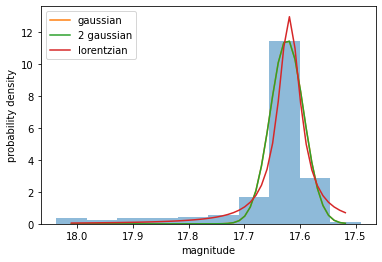

In [12]:
functions.fit_mag(806203400000031,plot=True)

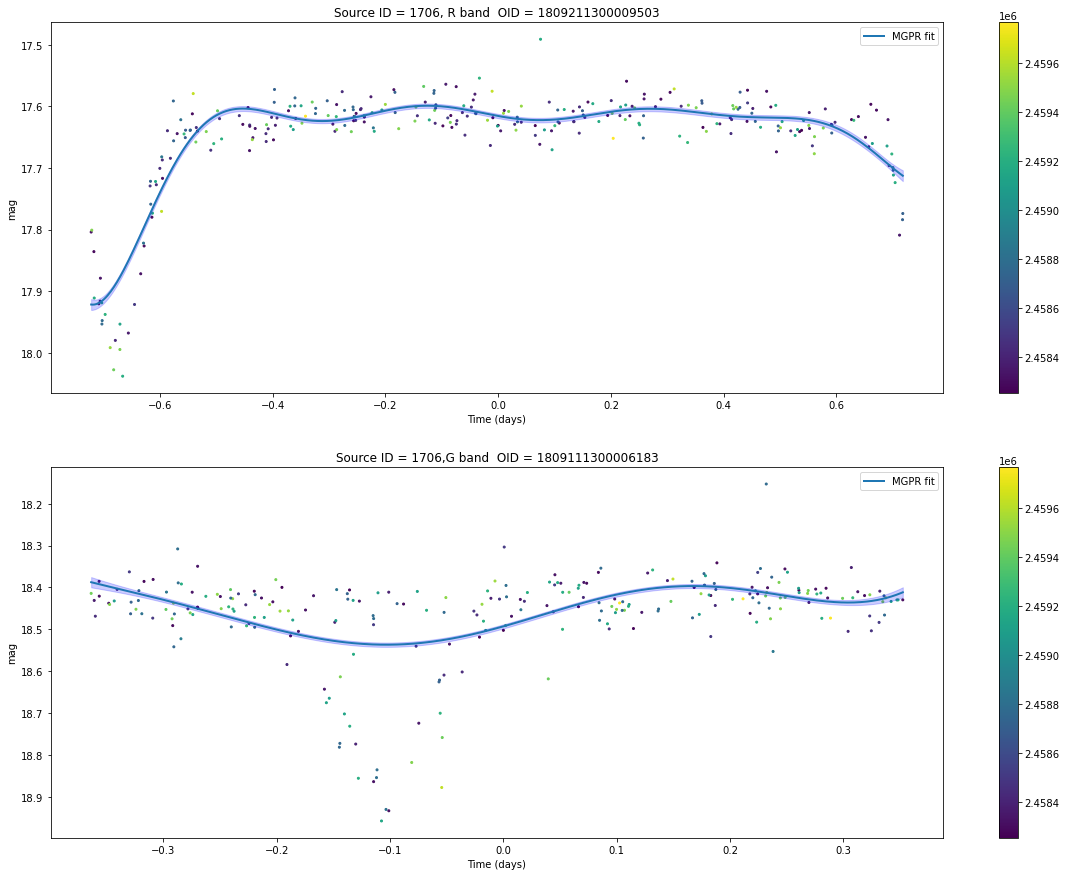

In [9]:
functions.MGPRfit(1706)

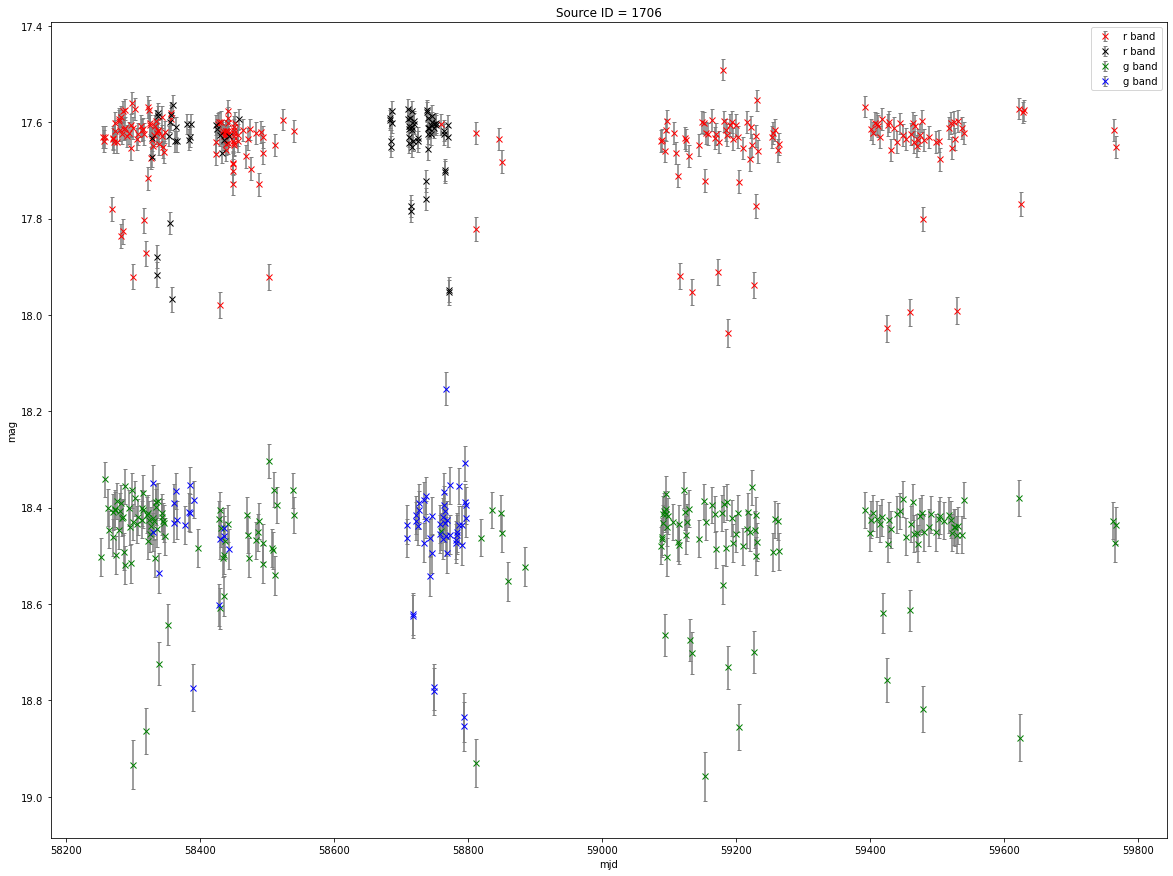

In [8]:
functions.draw_lightcurve(1706)

In [13]:
functions.query(208)

SourceID,filter,OID,RA,DEC,numobs,DELTA_SIG_MAG,CONST_CHI2,sf,rmse,LNP_SIG,period,period_c,power,power_c,mean,std,min,max,sigma_mean,sigma_std,upsilon_class,upsilon_prob,upsilon_flag,upsilon_period
int32,str2,str16,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str14,float64,float64,float64
208,zr,1809211300066600,5.0641514,59.3186377,69,54.95647430419922,23.989242156806093,1.3505024655969016e-128,0.4311656951904297,1.8123385606124472e-35,0.998898006947754,2800.0,0.9315617148518597,0.45684496845352723,19.807981491088867,0.4311656951904297,19.155311584472656,20.439895629882812,-1.5990476608276367,5.616694927215576,LPV_Mira_AGB_C,0.63,1.0,1325.6110067999907
208,zr,806203100063224,5.064121,59.3186488,785,57.229671478271484,14.973554136565346,0.0,0.36998096108436584,5.372709522621155e-121,706.5076598069519,0.997336033066433,0.7610530058290755,0.04136356170280423,19.66598129272461,0.36998096108436584,19.045684814453125,20.505390167236328,-1.0772920846939087,4.238379955291748,LPV_OSARG_AGB,0.4,0.0,647.9578075285723


SourceID,filter,OID,RA,DEC,numobs,DELTA_SIG_MAG,CONST_CHI2,sf,rmse,LNP_SIG,period,period_c,power,power_c,mean,std,min,max,sigma_mean,sigma_std,upsilon_class,upsilon_prob,upsilon_flag,upsilon_period
int32,str2,str16,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str14,float64,float64,float64


(1.2339996496192571, nan, 1.2035424437085265)

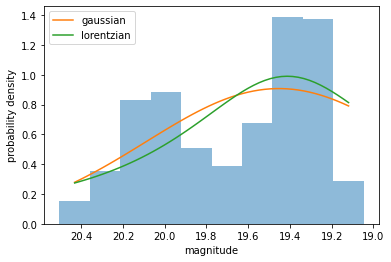

In [15]:
functions.fit_mag(806203100063224,plot=True)

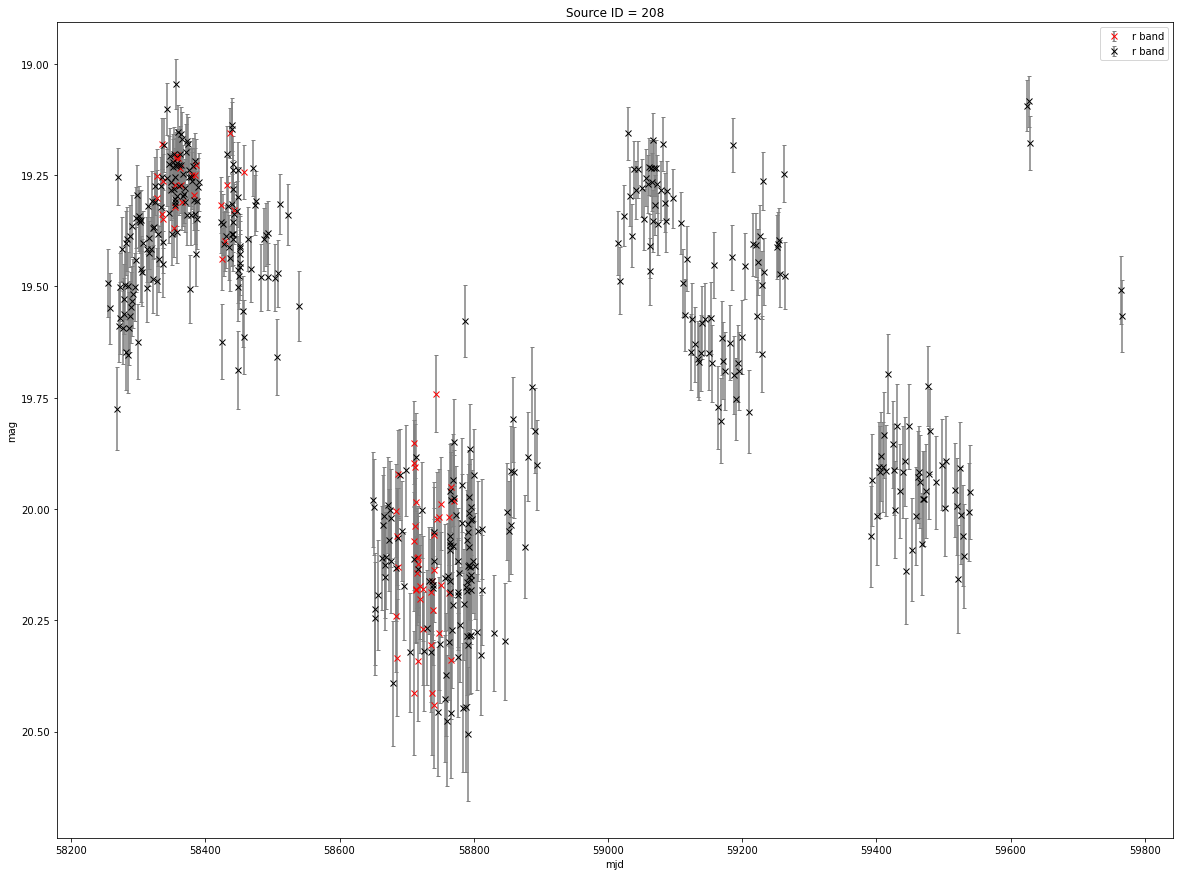

In [7]:
functions.draw_lightcurve(208)

In [6]:
obj_zg.show_in_notebook()

idx,SourceID,filter,OID,RA,DEC,numobs,DELTA_SIG_MAG,CONST_CHI2,sf,rmse,LNP_SIG,period,period_c,power,power_c,mean,std,min,max,sigma_mean,sigma_std,gaussian1_err,gaussian2_err,lorentzian_err,shape,upsilon_class,upsilon_prob,upsilon_flag,upsilon_period
0,73,zg,806103100048650,5.0758587,59.2958026,97,64.1142578125,8.935053528431245,1.364237212874404e-43,0.23146717250347137,1.5286033678611772e-06,1.0323211002809742,0.9972896868175051,0.35458712707540346,0.17918306600135617,20.327228546142578,0.23146717250347137,19.153165817260742,20.794662475585938,-0.3369257152080536,3.0768370628356934,0.06673400778207149,9.691270424125337,0.216602441139147,g1,CEPH_Other,0.49,1.0,2.150138196410262
1,77,zg,806103100029923,5.0869784,59.2997881,258,80.47639465332031,16.358047581022113,8.308402166762659e-291,0.31344184279441833,2.3170100655180286e-16,26.55360081018743,1.0000143393856216,0.29023605619128945,0.005352919590317105,20.02450942993164,0.31344184279441833,18.832887649536133,20.759401321411133,-0.705572783946991,4.285964488983154,0.09079469491452992,99999.0,0.15267809927977255,g1,CEPH_Other,0.42,0.0,26.525643273684214
2,90,zg,806103100049624,5.0834336,59.3114529,324,188.7042694091797,29.36702577363452,0.0,0.29480019211769104,3.044761670180407e-168,2043.2292424728973,1.0000143393856216,0.9125489407249586,0.43350509622734634,18.898109436035156,0.29480019211769104,18.297286987304688,19.611181259155273,-1.0131325721740723,5.650538921356201,1.6777069375503995,3.091578847696985,1.2345182826962693,l,LPV_OSARG_AGB,0.31,0.0,1511.9616666
3,443,zg,806103100029740,5.0330754,59.3138586,121,28.574586868286133,3.3070619221753326,6.971346953456639e-06,0.26791107654571533,3.359681295461664e-06,29.544695873850177,0.9973551322251167,0.2801948798759783,0.2318731325804575,21.151514053344727,0.26791107654571533,20.161453247070312,21.6740779876709,-0.17529430985450745,1.8428221940994263,0.0722151578425594,99999.0,0.05276792163479667,l,T2CEPH,0.27,1.0,29.58474232302639
4,959,zg,806103100020224,5.004683,59.2957142,88,36.86333084106445,4.684628152743749,1.3916365366418321e-11,0.2844848036766052,6.385254250041842e-06,0.9693858486637983,0.9972475558737529,0.3530172255660577,0.07943363226649049,21.140100479125977,0.2844848036766052,19.84897232055664,21.54222869873047,-0.21879763901233673,2.201746702194214,0.06445639209747522,99999.0,0.08253113418554565,g1,CEPH_Other,0.55,1.0,0.9693417887075744
5,1219,zg,806103100019623,5.1471037,59.3192505,227,50.598838806152344,3.1444243020941505,6.549911462187277e-08,0.19112929701805115,6.941202255880496e-07,29.447495953900567,0.997381150869086,0.17618709053449363,0.09778859934213133,20.59395980834961,0.19112929701805115,19.435989379882812,21.078689575195312,-0.1532217562198639,1.797919750213623,0.15214401581265416,0.0010752045788235286,0.008122308631935495,g2,CEPH_Other,0.19,1.0,29.563396567549706
6,1642,zg,806103400000039,5.125632,59.2614822,193,319.8429260253906,3.8277717316687054,2.0313202423838072e-13,0.03029390051960945,9.879192641170996e-17,333.4203659481394,1.000014139092549,0.3710084864897626,0.061699838152285046,14.649717330932617,0.03029390051960945,14.5626220703125,14.71679973602295,-0.004198555834591389,1.951535940170288,29.356143424212046,3.8415613914586175,11.910438860897447,g2,LPV_OSARG_RGB,0.77,0.0,324.4204513928578
7,1742,zg,806103100036041,5.1657575,59.3264781,100,39.18263626098633,5.1370541115192,9.344332088315628e-16,0.2907710373401642,1.1622696420569923e-06,1.0350954501329348,0.9973150583083484,0.3479967454274027,0.32068001120018785,21.214624404907227,0.2907710373401642,19.77669334411621,21.729793548583984,-0.22576093673706055,2.3101282119750977,0.053505075417440894,1.4169706622008302,0.15669623992196288,g1,CEPH_Other,0.47,1.0,0.9646255847324385
8,2091,zg,806103100042527,5.0300812,59.3603736,327,117.55354309082031,7.327556527488163,1.7014568121167147e-100,0.16449441015720367,1.4177251368775485e-06,29.449981881281207,1.0000143393856216,0.12390738368110238,0.03221883888291755,19.395851135253906,0.16449441015720367,1